# NYC SALE PRICE PREDICTION

In this Task, we will perform a data exploration, feature engineering, and on a house sale dataset.

The goal of this assignment is to analyze 1 year’(2020) house sales data provided by New York City (NYC) goverment and build regression model to predict house price. NYC has Queens.

#Pip Instal

In [1]:
#install some packages
%%capture
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install pandasql
!pip install --upgrade category_encoders
!pip install --upgrade azureml-sdk[notebooks,automl]
!pip install -U mljar-supervised

#Import Libraries

In [678]:
import pandas as pd
import numpy as np
from scipy import stats
import pandasql as ps 
#for plots
import missingno as msno 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings('ignore')
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

import fuzzywuzzy
from fuzzywuzzy import process
import chardet

from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder  #for encode the categorical data

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.impute import KNNImputer

#split the data
from sklearn.model_selection import train_test_split

#models Evaluations and reports
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

#ML models 
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor

from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#AUTOML
from sklearn.metrics import mean_squared_error
from supervised.automl import AutoML
import sklearn.metrics

from scipy.stats import f_oneway

#Task 1: Read dataset, and perform basic data exploration. check duplicates, missing values etc.dealing with (missing values, duplicate entries, outliers, etc.)

##Read Data

In [905]:
#load the data from my google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [906]:
#read the CSV file
df = pd.read_csv("/content/drive/MyDrive/DEBI/Queens/DA/Lab_2/2020_queens.csv")

In [907]:
df.head()

BOROUGH        NEIGHBORHOOD        BUILDING CLASS CATEGORY  \
0      4.0         AIRPORT JFK   39 TRANSPORTATION FACILITIES   
1      4.0  AIRPORT LA GUARDIA        01 ONE FAMILY DWELLINGS   
2      4.0  AIRPORT LA GUARDIA  12 CONDOS - WALKUP APARTMENTS   
3      4.0             ARVERNE        01 ONE FAMILY DWELLINGS   
4      4.0             ARVERNE        01 ONE FAMILY DWELLINGS   

  TAX CLASS AT PRESENT    BLOCK     LOT  EASE-MENT BUILDING CLASS AT PRESENT  \
0                    4  14260.0    80.0        NaN                        V7   
1                    1    949.0    41.0        NaN                        A5   
2                    2    949.0  1003.0        NaN                        R2   
3                    1  15830.0    20.0        NaN                        A5   
4                    1  15830.0    27.0        NaN                        A5   

                 ADDRESS APARTMENT NUMBER  ...  RESIDENTIAL UNITS  \
0      N/A ROCKAWAY BLVD              NaN  ...                0.0   
1      19-62 81ST STREET              NaN  ...                1.0   
2   19-37 80TH STREET, 1                1  ...                1.0   
3   3-20 BEACH 41 STREET              NaN  ...                1.0   
4  336 BEACH 41ST STREET              NaN  ...                1.0   

   COMMERCIAL UNITS  TOTAL UNITS  LAND SQUARE FEET GROSS SQUARE FEET  \
0               0.0          0.0           268,092                 0   
1               0.0          1.0             1,800             1,224   
2               NaN          1.0               NaN               NaN   
3               0.0          1.0             2,469             1,476   
4               0.0          1.0             2,325             1,350   

  YEAR BUILT  TAX CLASS AT TIME OF SALE  BUILDING CLASS AT TIME OF SALE  \
0        NaN                        4.0                              T1   
1     1945.0                        1.0                              A5   
2        NaN                        2.0                              R2   
3     2005.0                        1.0                              A5   
4     2005.0                        1.0                              A5   

  SALE PRICE   SALE DATE  
0  4,121,000  2020-07-16  
1    584,569  2020-08-28  
2    420,000  2020-03-12  
3    300,000  2020-12-16  
4    360,000  2020-06-23  

[5 rows x 21 columns]

##Some Important Methods

In [908]:
# plot method
def dist_plot(X, Num):
  plt.figure(figsize=(20,10))
  sns.set(palette="muted", color_codes=True)
  first_15 = sns.barplot(x=df[X].value_counts().head(Num).index, y=df[X].value_counts().head(Num).values)
  plt.xticks(rotation='90', fontsize=14, fontweight='bold')
  plt.xlabel(X, fontsize=16, fontweight='bold')
  plt.yticks(rotation='0', fontsize=14, fontweight='bold')
  plt.ylabel('Count', rotation=0, ha='right', fontsize=14, fontweight='bold')

  for patch in first_15.patches:
              first_15.annotate("%.0f" % patch.get_height(), (patch.get_x() + patch.get_width() / 2., patch.get_height()),
                  ha='center', va='center', fontsize=14, fontweight='bold', color='black', xytext=(0, 5),
                  textcoords='offset points')
  plt.grid()
  plt.show()

In [909]:
def pie_plot(X, n):
  #explsion
  explode = []
  for i in range(n):
    explode.append(0.1)

  explode = tuple(explode)
  # Pie chart
  df[X].value_counts().head(n).plot.pie(radius = 3.5, autopct='%.0f%%', pctdistance=0.7, explode = explode, textprops={'fontsize': 15})
  #draw circle
  fig = plt.gcf()
  # Equal aspect ratio ensures that pie is drawn as a circle
  plt.tight_layout()
  plt.show()

In [910]:
def distribution(X):
  sns.set(palette="muted", color_codes=True)
  f, axs = plt.subplots(1, 1, figsize=(12, 8), sharex=True)
  sns.despine(left=True)
  #Plot a histogram and kernel density estimate
  sns.distplot(df[X], color="b")
  # plt.setp(axs, yticks=[])
  plt.tight_layout()

> **Create function for calculate the number of missing and the ratio of missing**

In [911]:
def miss_number():
  # summary of the number of nulls and count the ratio of missing values
  total_miss = df.isnull().sum()
  percent_miss = (total_miss/df.isnull().count()*100)

  # sort attributes by missing value ratio
  missing_data = pd.DataFrame({'Total missing':total_miss,'% missing':percent_miss})
  missing_data = missing_data.sort_values(by='Total missing',ascending=False)

  return missing_data

##Information and describe the data

In [912]:
print('Shape of the Dataframe:', df.shape,'\n')

Shape of the Dataframe: (26118, 21) 



In [913]:
# summary of the data including non-null counts
print('data information: \n')
df.info()

data information: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26118 entries, 0 to 26117
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         20357 non-null  float64
 1   NEIGHBORHOOD                    20357 non-null  object 
 2   BUILDING CLASS CATEGORY         20357 non-null  object 
 3   TAX CLASS AT PRESENT            20356 non-null  object 
 4   BLOCK                           20357 non-null  float64
 5   LOT                             20357 non-null  float64
 6   EASE-MENT                       0 non-null      float64
 7   BUILDING CLASS AT PRESENT       20356 non-null  object 
 8   ADDRESS                         20357 non-null  object 
 9   APARTMENT NUMBER                2608 non-null   object 
 10  ZIP CODE                        20357 non-null  float64
 11  RESIDENTIAL UNITS               16414 non-null  float64
 12  COMMERCIAL U

In [914]:
#general summary of dataset
print("Data Description")
df.describe(include='all').transpose()

Data Description


count unique                      top  \
BOROUGH                         20357.0    NaN                      NaN   
NEIGHBORHOOD                      20357     61           FLUSHING-NORTH   
BUILDING CLASS CATEGORY           20357     40  01 ONE FAMILY DWELLINGS   
TAX CLASS AT PRESENT              20356     10                        1   
BLOCK                           20357.0    NaN                      NaN   
LOT                             20357.0    NaN                      NaN   
EASE-MENT                           0.0    NaN                      NaN   
BUILDING CLASS AT PRESENT         20356    111                       A1   
ADDRESS                           20357  19776        21-36 28TH STREET   
APARTMENT NUMBER                   2608   1089                       3B   
ZIP CODE                        20357.0    NaN                      NaN   
RESIDENTIAL UNITS               16414.0    NaN                      NaN   
COMMERCIAL UNITS                14784.0    NaN                      NaN   
TOTAL UNITS                     16910.0    NaN                      NaN   
LAND SQUARE FEET                  14288   2770                    4,000   
GROSS SQUARE FEET                 14288   2626                        0   
YEAR BUILT                      19498.0    NaN                      NaN   
TAX CLASS AT TIME OF SALE       20357.0    NaN                      NaN   
BUILDING CLASS AT TIME OF SALE    20357    111                       A1   
SALE PRICE                        20357   2711                        0   
SALE DATE                         20357    359               2020-09-09   

                                 freq          mean          std      min  \
BOROUGH                           NaN           4.0          0.0      4.0   
NEIGHBORHOOD                     2006           NaN          NaN      NaN   
BUILDING CLASS CATEGORY          7330           NaN          NaN      NaN   
TAX CLASS AT PRESENT            12812           NaN          NaN      NaN   
BLOCK                             NaN   6914.861866  4482.172669     15.0   
LOT                               NaN    209.179594   441.273336      1.0   
EASE-MENT                         NaN           NaN          NaN      NaN   
BUILDING CLASS AT PRESENT        3481           NaN          NaN      NaN   
ADDRESS                            10           NaN          NaN      NaN   
APARTMENT NUMBER                   42           NaN          NaN      NaN   
ZIP CODE                          NaN  11374.850371   119.554457  11001.0   
RESIDENTIAL UNITS                 NaN      1.761971     5.982168      0.0   
COMMERCIAL UNITS                  NaN      0.135417     1.065624      0.0   
TOTAL UNITS                       NaN      1.828681     5.995685      0.0   
LAND SQUARE FEET                 1777           NaN          NaN      NaN   
GROSS SQUARE FEET                 446           NaN          NaN      NaN   
YEAR BUILT                        NaN   1949.336599    29.627932   1018.0   
TAX CLASS AT TIME OF SALE         NaN       1.46048     0.776176      1.0   
BUILDING CLASS AT TIME OF SALE   3486           NaN          NaN      NaN   
SALE PRICE                       7159           NaN          NaN      NaN   
SALE DATE                         174           NaN          NaN      NaN   

                                    25%      50%      75%      max  
BOROUGH                             4.0      4.0      4.0      4.0  
NEIGHBORHOOD                        NaN      NaN      NaN      NaN  
BUILDING CLASS CATEGORY             NaN      NaN      NaN      NaN  
TAX CLASS AT PRESENT                NaN      NaN      NaN      NaN  
BLOCK                            2977.0   6598.0  10587.0  16350.0  
LOT                                17.0     40.0     83.0   7113.0  
EASE-MENT                           NaN      NaN      NaN      NaN  
BUILDING CLASS AT PRESENT           NaN      NaN      NaN      NaN  
ADDRESS                             NaN      NaN      NaN      NaN 

> As we can see, We have only two types of data
1. Object ==> `11 Column`
2. Float64 ==> `10 Column`

> And there are also some columns is object but has numerical values but need to handling 

> So in this task W will work with `[Duplicates, Missing, Outliers, handling the object columns which has numeric values]`

##Checking for duplications

In [915]:
## using the DataFrame.duplicated() method to return a series of boolean values [True , False] for each row
df.duplicated(subset = None)

0        False
1        False
2        False
3        False
4        False
         ...  
26113     True
26114     True
26115     True
26116     True
26117     True
Length: 26118, dtype: bool

In [916]:
#check if there exist any true value to check for duplications
df.duplicated(subset = None).value_counts()

False    20344
True      5774
dtype: int64

In [917]:
#checking for number of duplications
df.duplicated().sum()

5774

> As we see, we have `5774` Duplicated records

> So I will remove all duplications

In [918]:
#checking for duplications
# use the DataFrame.duplicated() method to return a series of boolean values for each rows then but apply the results on the data frame to return all the duplicates rows
df_duplication = df[df.duplicated(subset = None)]
df_duplication

BOROUGH    NEIGHBORHOOD         BUILDING CLASS CATEGORY  \
3229       4.0          CORONA       03 THREE FAMILY DWELLINGS   
3597       4.0      DOUGLASTON    09 COOPS - WALKUP APARTMENTS   
5079       4.0  FLUSHING-NORTH         01 ONE FAMILY DWELLINGS   
6005       4.0  FLUSHING-NORTH  10 COOPS - ELEVATOR APARTMENTS   
6223       4.0  FLUSHING-NORTH  10 COOPS - ELEVATOR APARTMENTS   
...        ...             ...                             ...   
26113      NaN             NaN                             NaN   
26114      NaN             NaN                             NaN   
26115      NaN             NaN                             NaN   
26116      NaN             NaN                             NaN   
26117      NaN             NaN                             NaN   

      TAX CLASS AT PRESENT   BLOCK   LOT  EASE-MENT BUILDING CLASS AT PRESENT  \
3229                     1  1929.0  61.0        NaN                        C0   
3597                     2  8276.0  20.0        NaN                        C6   
5079                     1  4891.0   6.0        NaN                        A1   
6005                     2  4371.0   8.0        NaN                        D4   
6223                     2  5374.0  27.0        NaN                        D4   
...                    ...     ...   ...        ...                       ...   
26113                  NaN     NaN   NaN        NaN                       NaN   
26114                  NaN     NaN   NaN        NaN                       NaN   
26115                  NaN     NaN   NaN        NaN                       NaN   
26116                  NaN     NaN   NaN        NaN                       NaN   
26117                  NaN     NaN   NaN        NaN                       NaN   

                           ADDRESS APARTMENT NUMBER  ...  RESIDENTIAL UNITS  \
3229          103-08 CORONA AVENUE              NaN  ...                3.0   
3597   58-39 246TH CRESCENT, F16LO              NaN  ...                NaN   
5079            160-07 32ND AVENUE              NaN  ...                1.0   
6005        29-30 137TH STREET, 3A              NaN  ...                NaN   
6223     144-54 SANFORD AVENUE, 56              NaN  ...                NaN   
...                            ...              ...  ...                ...   
26113                          NaN              NaN  ...                NaN   
26114                          NaN              NaN  ...                NaN   
26115                          NaN              NaN  ...                NaN   
26116                          NaN              NaN  ...                NaN   
26117                          NaN              NaN  ...                NaN   

       COMMERCIAL UNITS  TOTAL UNITS  LAND SQUARE FEET GROSS SQUARE FEET  \
3229                0.0          3.0             2,645             2,290   
3597                NaN          NaN               NaN               NaN   
5079                0.0          1.0             4,242             2,172   
6005                NaN          NaN               NaN               NaN   
6223                NaN          NaN               NaN               NaN   
...                 ...          ...               ...               ...   
26113               NaN          NaN               NaN               NaN   
26114               NaN          NaN               NaN               NaN   
26115               NaN          NaN               NaN               NaN   
26116               NaN          NaN               NaN               NaN   
26117               NaN          NaN               NaN               NaN   

      YEAR BUILT  TAX CLASS AT TIME OF SALE  BUILDING CLASS AT TIME OF SALE  \
3229      1901.0                        1.0                              C0   
3597      1952.0                        2.0                              C6   
5079      1930.0                        1.0                              A1   
6005      1960.0                        2.0                    

> if we looking to the duplicated data frame We will see that the most of the duplicated data is `[Nulls]` data

> it's not important for Us at all We will drop all the duplicates

In [919]:
#remove all duplicate values
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [920]:
print('Shape of the Dataframe:', df.shape,'\n')

Shape of the Dataframe: (20344, 21) 



##Checking for missing values

In [921]:
# summary of the number of nulls and count the ratio of missing values
miss_number()

Total missing   % missing
EASE-MENT                               20344  100.000000
APARTMENT NUMBER                        17736   87.180495
LAND SQUARE FEET                         6066   29.817145
GROSS SQUARE FEET                        6066   29.817145
COMMERCIAL UNITS                         5570   27.379080
RESIDENTIAL UNITS                        3940   19.366890
TOTAL UNITS                              3444   16.928824
YEAR BUILT                                860    4.227291
TAX CLASS AT PRESENT                        2    0.009831
BUILDING CLASS AT PRESENT                   2    0.009831
BOROUGH                                     1    0.004915
SALE PRICE                                  1    0.004915
BUILDING CLASS AT TIME OF SALE              1    0.004915
TAX CLASS AT TIME OF SALE                   1    0.004915
ZIP CODE                                    1    0.004915
NEIGHBORHOOD                                1    0.004915
ADDRESS                                     1    0.004915
LOT                                         1    0.004915
BLOCK                                       1    0.004915
BUILDING CLASS CATEGORY                     1    0.004915
SALE DATE                                   1    0.004915

> As we can see, we have many columns with missing values

> So we will drop all columns which have missing values of more than `50%`

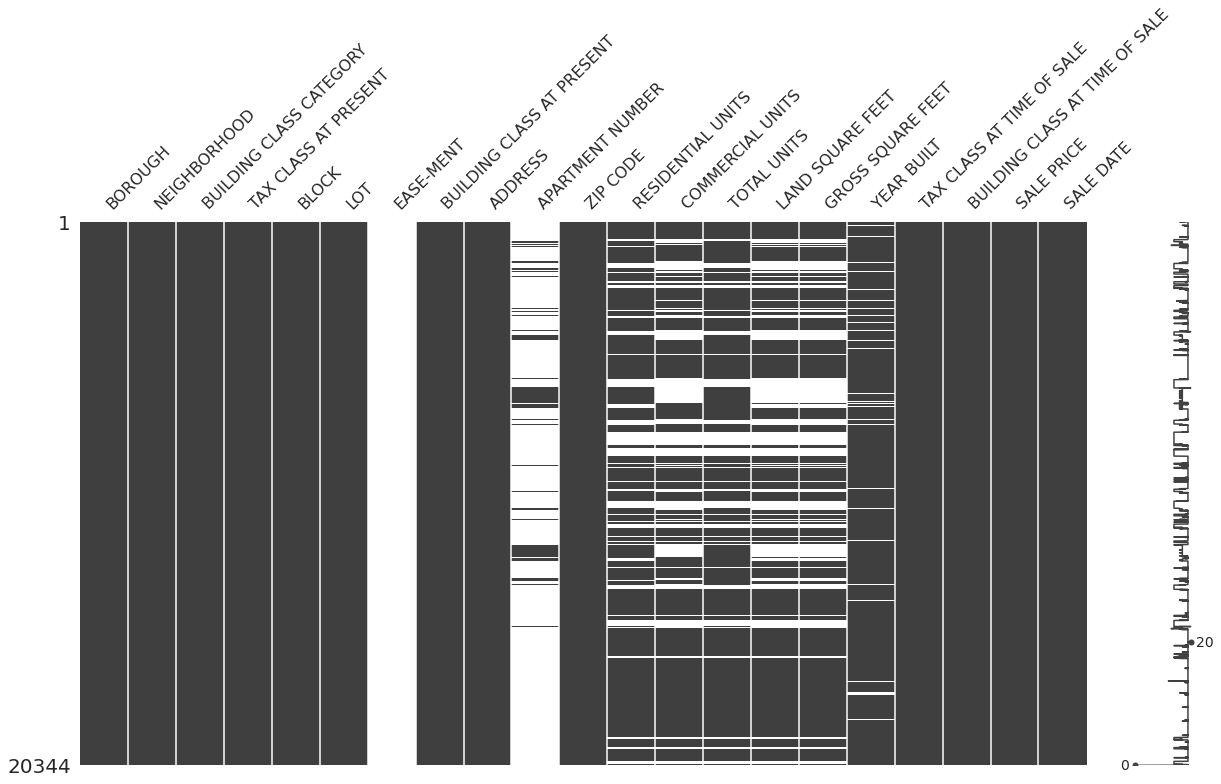

In [922]:
#visualize missing values as a matrix
msno.matrix(df, figsize=(20,10))

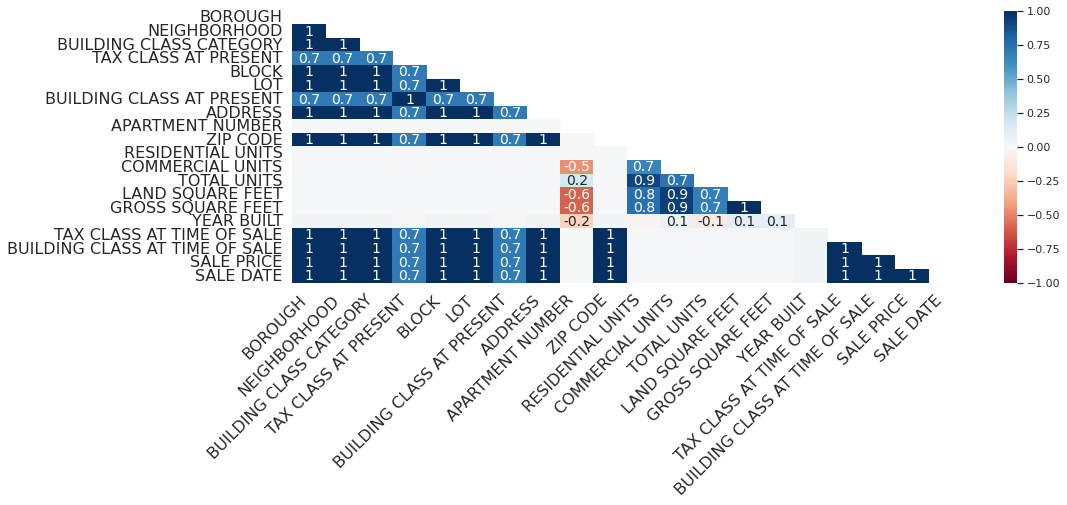

In [923]:
#bar chart
msno.heatmap(df, figsize=(15,5))

##Handling Every Column

###EASE-MENT & APARTMENT NUMBER

> As we can see, Now we can handle every column

> now We will remove all columns which has missing values ratio more than or equal 50% of data

In [924]:
# specify the percentage of the missing data then remove it
percent = 50.0 # Like N %
min_count =  int(((100 - percent) / 100) * df.shape[0] + 1)
df.dropna(axis=1, thresh = min_count, inplace = True)

In [925]:
# summary of the number of nulls and count the ratio of missing values
miss_number()

Total missing  % missing
GROSS SQUARE FEET                        6066  29.817145
LAND SQUARE FEET                         6066  29.817145
COMMERCIAL UNITS                         5570  27.379080
RESIDENTIAL UNITS                        3940  19.366890
TOTAL UNITS                              3444  16.928824
YEAR BUILT                                860   4.227291
TAX CLASS AT PRESENT                        2   0.009831
BUILDING CLASS AT PRESENT                   2   0.009831
SALE PRICE                                  1   0.004915
BUILDING CLASS AT TIME OF SALE              1   0.004915
TAX CLASS AT TIME OF SALE                   1   0.004915
BOROUGH                                     1   0.004915
NEIGHBORHOOD                                1   0.004915
ZIP CODE                                    1   0.004915
ADDRESS                                     1   0.004915
LOT                                         1   0.004915
BLOCK                                       1   0.004915
BUILDING CLASS CATEGORY                     1   0.004915
SALE DATE                                   1   0.004915

###BOROUGH

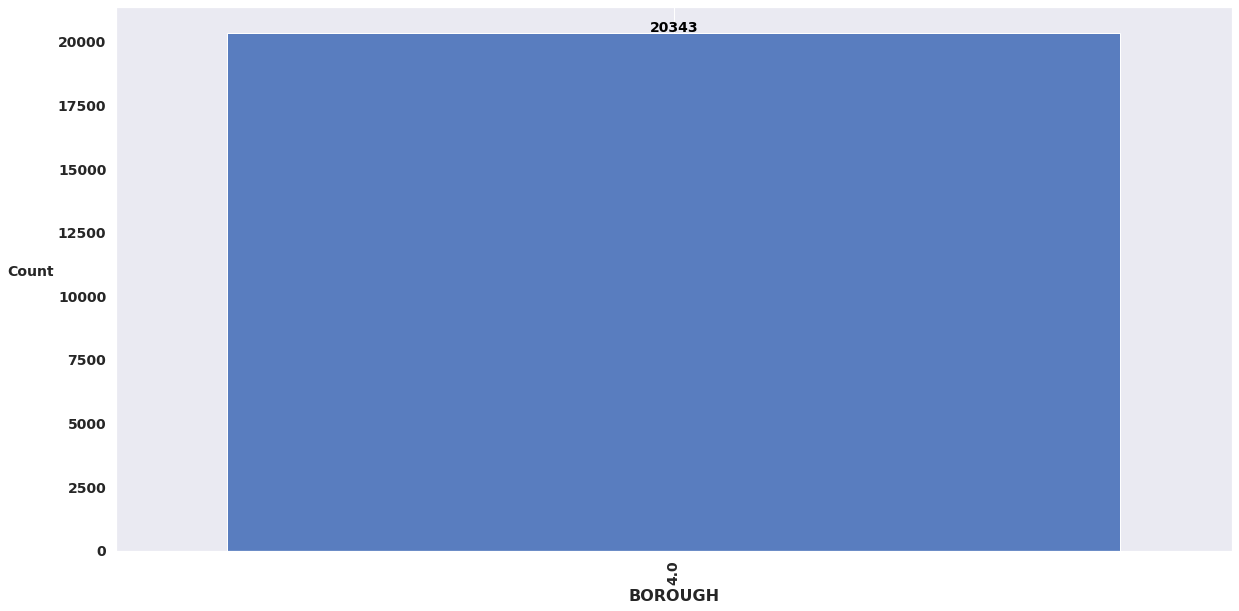

In [926]:
dist_plot('BOROUGH', len(df['BOROUGH'].value_counts()))

> As we can see, this column contains only one value, So we will drop it

In [927]:
df.drop('BOROUGH', axis=1, inplace=True)

###SALE PRICE

> As we can see, We have one Null value in `SALE PRICE` column, So we will drop this record because We can't train any model with any Missing values in Target column

In [928]:
# drop the record which has null value in the target column
df.dropna(axis = 'rows', subset = ['SALE PRICE'], inplace = True)

In [929]:
# dist_plot('SALE PRICE', len(df['SALE PRICE'].value_counts()))

In [930]:
df["SALE PRICE"].value_counts()

0            7147
10            235
750,000       113
850,000       113
700,000       113
             ... 
972,500         1
990,095         1
681,000         1
319,297         1
3,775,000       1
Name: SALE PRICE, Length: 2711, dtype: int64

> Convert this column from `Oject` to `numerical`

In [931]:
df['SALE PRICE'] = df['SALE PRICE'].str.replace(',', '')
df['SALE PRICE'] = df['SALE PRICE'].str.replace('$', '').str.strip().astype(float)

In [932]:
df["SALE PRICE"].value_counts()

0.0          7147
10.0          235
750000.0      113
850000.0      113
700000.0      113
             ... 
972500.0        1
990095.0        1
681000.0        1
319297.0        1
3775000.0       1
Name: SALE PRICE, Length: 2711, dtype: int64

> As we can see, We have `Sale Price` = `0` which is wrong so there are three soluions 
  * > Firtst: drop all records which contains `0` value
  * > Second: convert all of these records which have `0` values to `10.0` which is the less value
  * > Third: let the this column contain `0` value

> so we will use the first solution because this is a label column

In [933]:
df = df[df["SALE PRICE"] != 0]

In [934]:
df["SALE PRICE"].value_counts()

10.0         235
700000.0     113
750000.0     113
850000.0     113
600000.0     109
            ... 
972500.0       1
990095.0       1
681000.0       1
319297.0       1
3775000.0      1
Name: SALE PRICE, Length: 2710, dtype: int64

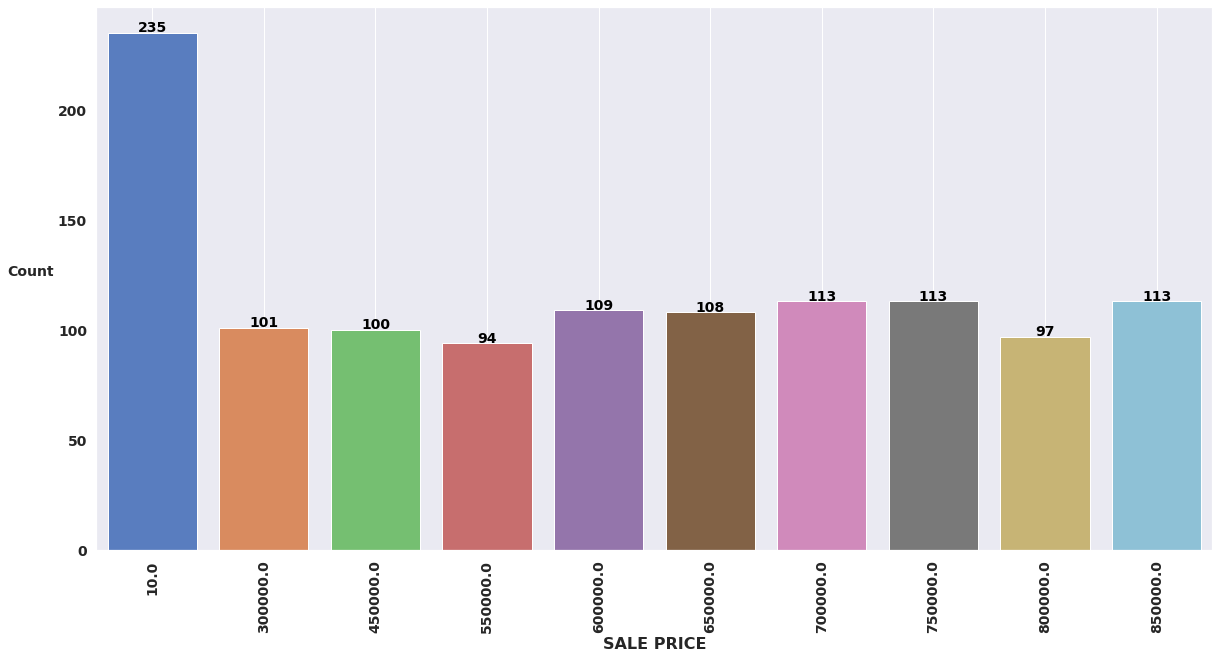

In [935]:
dist_plot('SALE PRICE', 10)

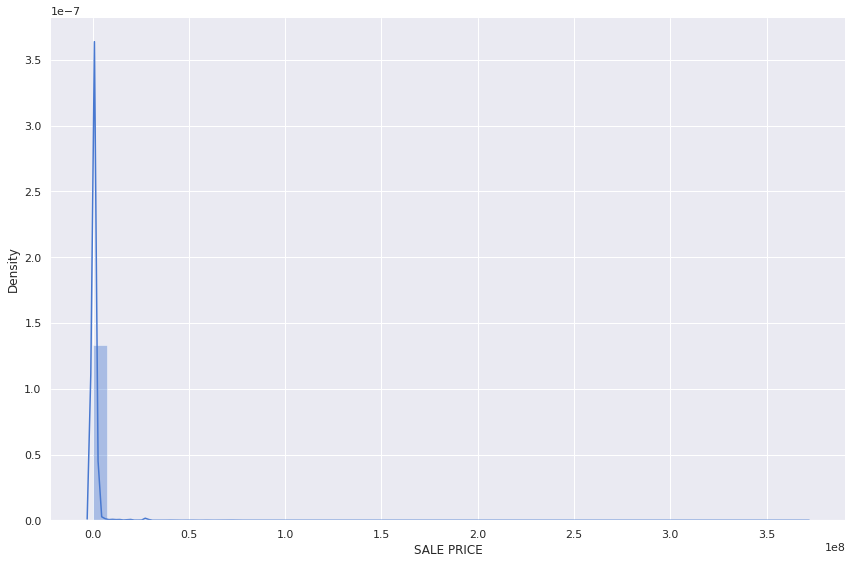

In [936]:
distribution("SALE PRICE")

In [937]:
print('Shape of the Dataframe:', df.shape,'\n')

Shape of the Dataframe: (13196, 18) 



###BUILDING CLASS AT PRESENT

In [938]:
# summary of the number of nulls and count the ratio of missing values
miss_number()

Total missing  % missing
GROSS SQUARE FEET                        5049  38.261594
LAND SQUARE FEET                         5049  38.261594
COMMERCIAL UNITS                         4667  35.366778
RESIDENTIAL UNITS                        3379  25.606244
TOTAL UNITS                              2997  22.711428
YEAR BUILT                                527   3.993634
SALE PRICE                                  0   0.000000
BUILDING CLASS AT TIME OF SALE              0   0.000000
TAX CLASS AT TIME OF SALE                   0   0.000000
NEIGHBORHOOD                                0   0.000000
BUILDING CLASS CATEGORY                     0   0.000000
ZIP CODE                                    0   0.000000
ADDRESS                                     0   0.000000
BUILDING CLASS AT PRESENT                   0   0.000000
LOT                                         0   0.000000
BLOCK                                       0   0.000000
TAX CLASS AT PRESENT                        0   0.000000
SALE DATE                                   0   0.000000

In [939]:
df['BUILDING CLASS AT PRESENT'].value_counts()

A1    2141
D4    2082
R4    1162
A5    1111
B3     931
      ... 
M3       1
H3       1
Z3       1
E7       1
RA       1
Name: BUILDING CLASS AT PRESENT, Length: 97, dtype: int64

In [940]:
len(df['BUILDING CLASS AT PRESENT'].value_counts())

97

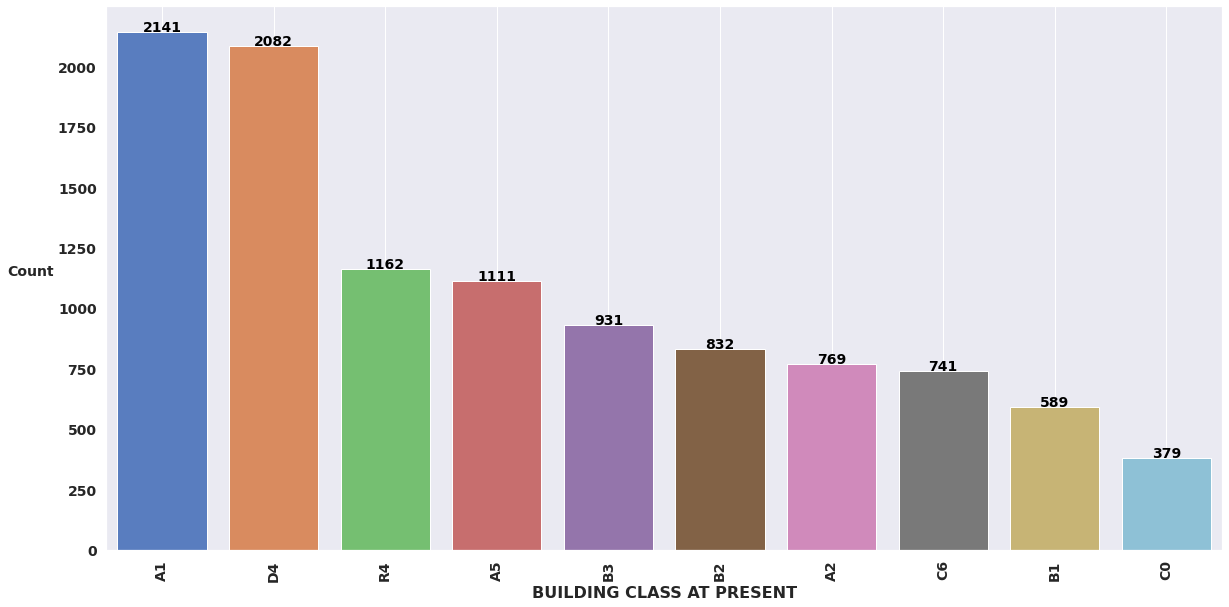

In [941]:
dist_plot('BUILDING CLASS AT PRESENT', 10)

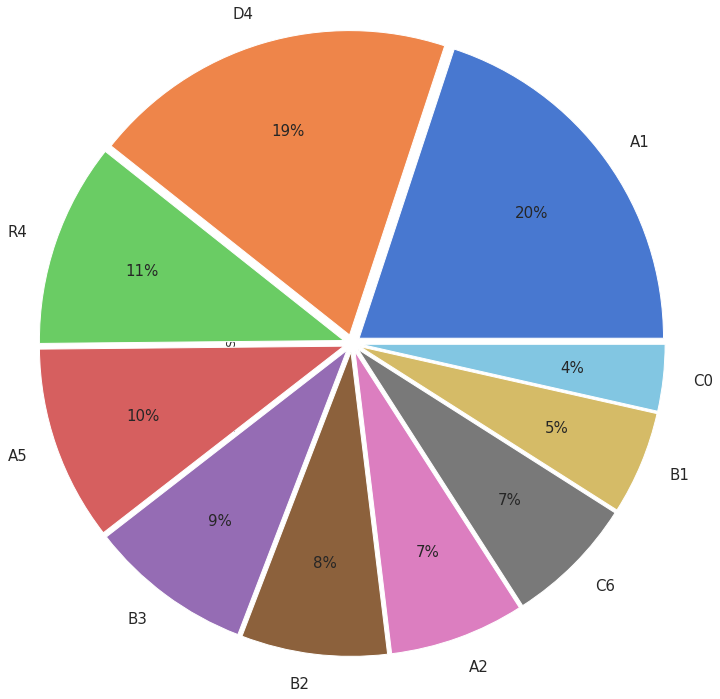

In [942]:
pie_plot('BUILDING CLASS AT PRESENT', 10)

###TAX CLASS AT PRESENT

In [943]:
len(df['TAX CLASS AT PRESENT'].value_counts())

10

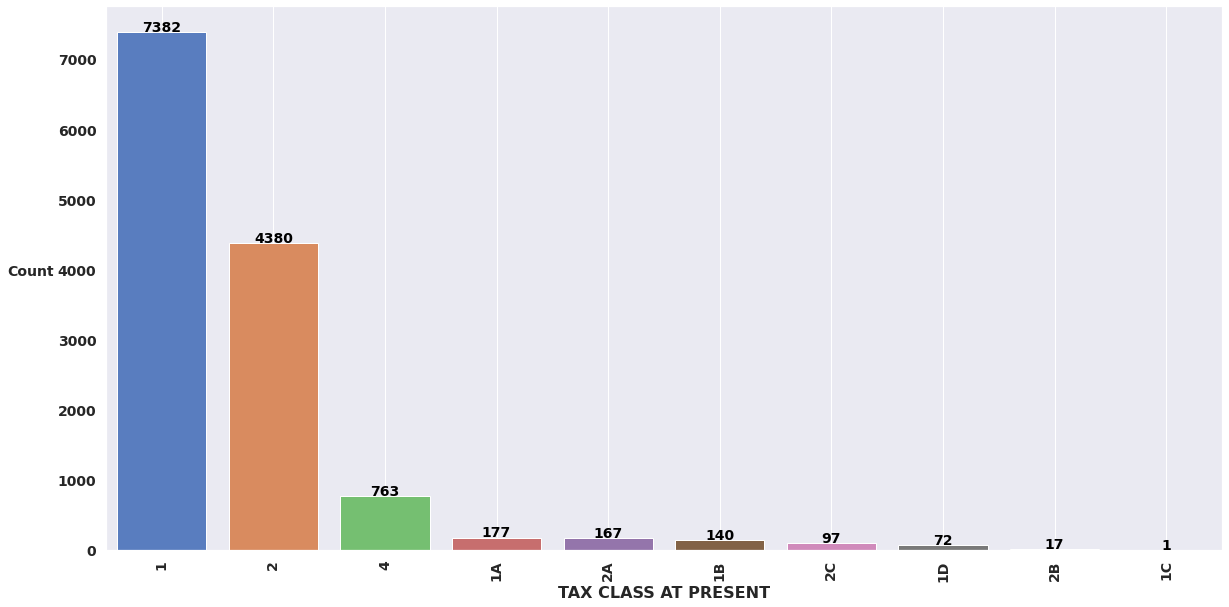

In [944]:
dist_plot('TAX CLASS AT PRESENT', 10)

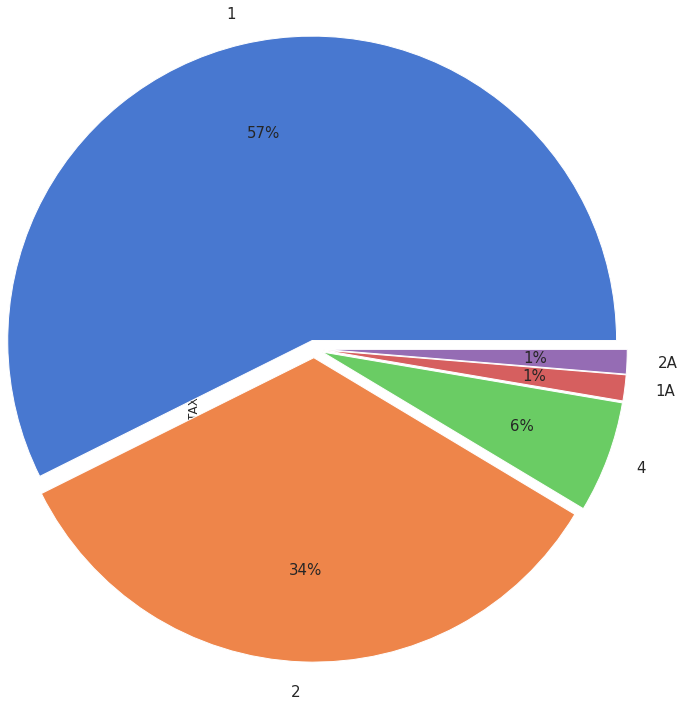

In [945]:
pie_plot('TAX CLASS AT PRESENT', 5)

###ZIP CODE

In [946]:
# summary of the number of nulls and count the ratio of missing values
miss_number()

Total missing  % missing
GROSS SQUARE FEET                        5049  38.261594
LAND SQUARE FEET                         5049  38.261594
COMMERCIAL UNITS                         4667  35.366778
RESIDENTIAL UNITS                        3379  25.606244
TOTAL UNITS                              2997  22.711428
YEAR BUILT                                527   3.993634
SALE PRICE                                  0   0.000000
BUILDING CLASS AT TIME OF SALE              0   0.000000
TAX CLASS AT TIME OF SALE                   0   0.000000
NEIGHBORHOOD                                0   0.000000
BUILDING CLASS CATEGORY                     0   0.000000
ZIP CODE                                    0   0.000000
ADDRESS                                     0   0.000000
BUILDING CLASS AT PRESENT                   0   0.000000
LOT                                         0   0.000000
BLOCK                                       0   0.000000
TAX CLASS AT PRESENT                        0   0.000000
SALE DATE                                   0   0.000000

> As we can see, `ZIP CODE` has no missing Values

In [947]:
df['ZIP CODE'].value_counts()

11375.0    657
11101.0    510
11354.0    437
11355.0    431
11434.0    400
          ... 
11104.0     70
11363.0     67
11001.0     36
11040.0     20
11109.0     20
Name: ZIP CODE, Length: 63, dtype: int64

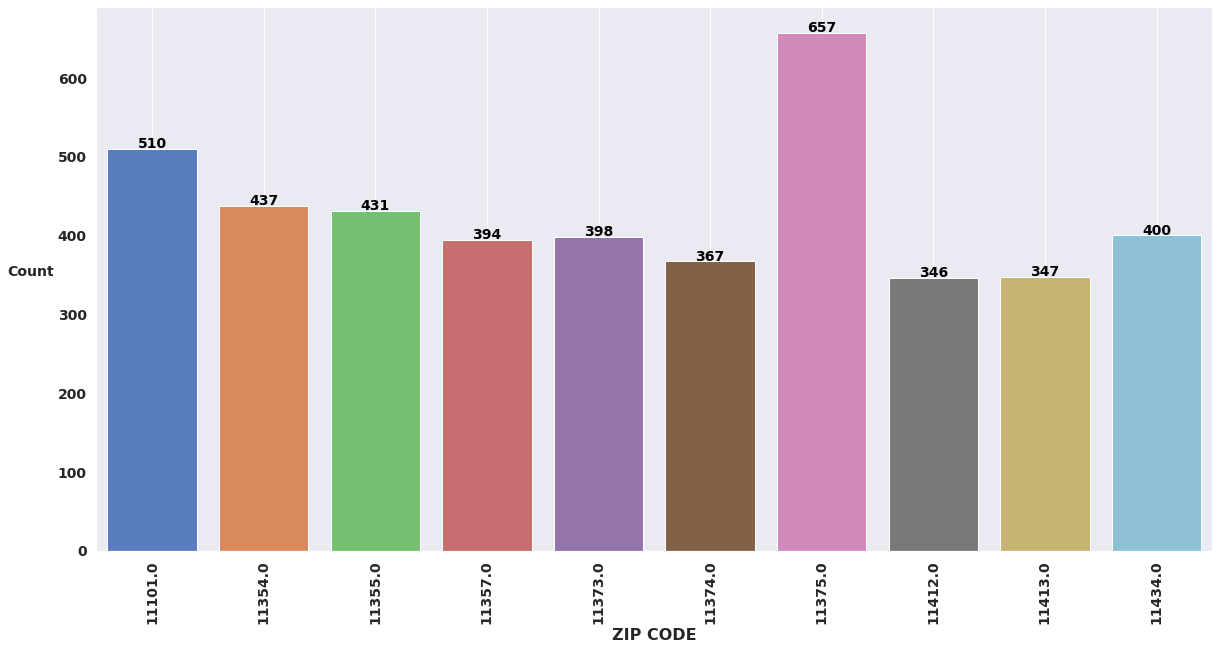

In [948]:
dist_plot('ZIP CODE', 10)

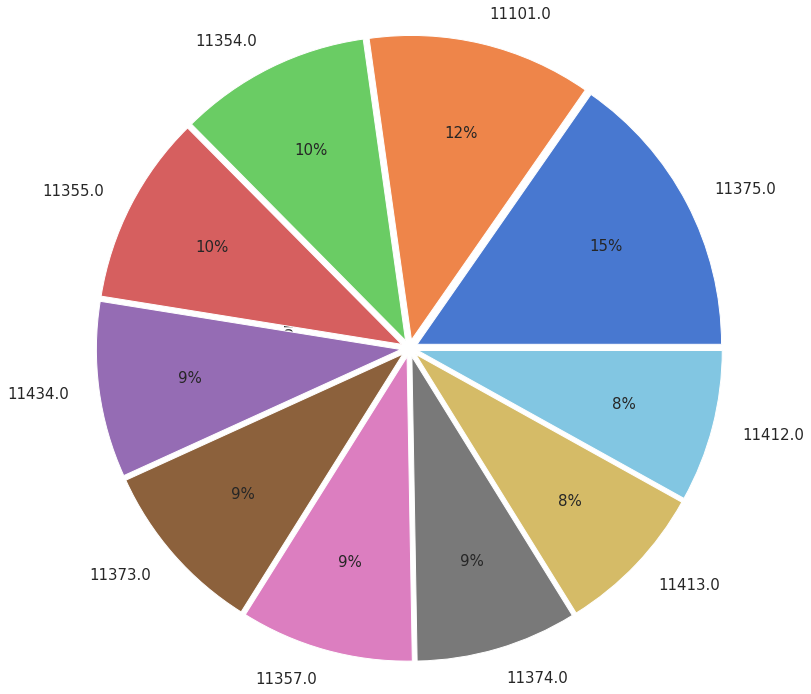

In [949]:
pie_plot('ZIP CODE', 10)

###YEAR BUILT

In [950]:
# summary of the number of nulls and count the ratio of missing values
miss_number()

Total missing  % missing
GROSS SQUARE FEET                        5049  38.261594
LAND SQUARE FEET                         5049  38.261594
COMMERCIAL UNITS                         4667  35.366778
RESIDENTIAL UNITS                        3379  25.606244
TOTAL UNITS                              2997  22.711428
YEAR BUILT                                527   3.993634
SALE PRICE                                  0   0.000000
BUILDING CLASS AT TIME OF SALE              0   0.000000
TAX CLASS AT TIME OF SALE                   0   0.000000
NEIGHBORHOOD                                0   0.000000
BUILDING CLASS CATEGORY                     0   0.000000
ZIP CODE                                    0   0.000000
ADDRESS                                     0   0.000000
BUILDING CLASS AT PRESENT                   0   0.000000
LOT                                         0   0.000000
BLOCK                                       0   0.000000
TAX CLASS AT PRESENT                        0   0.000000
SALE DATE                                   0   0.000000

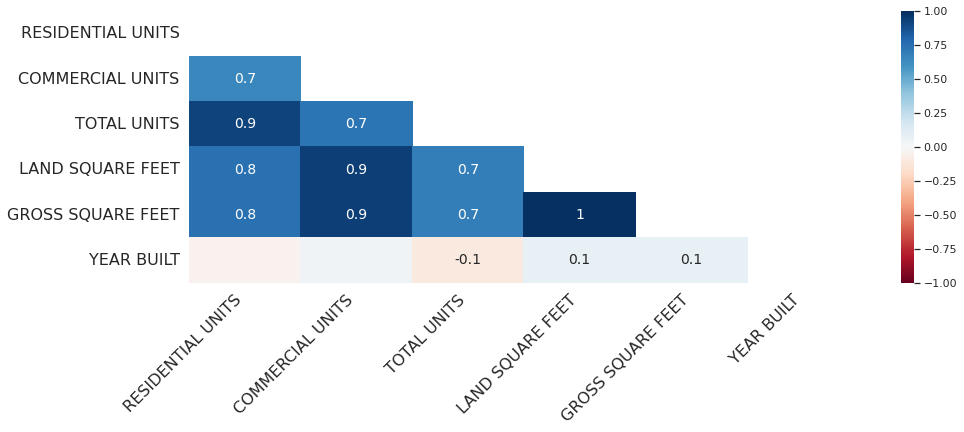

In [951]:
#bar chart
msno.heatmap(df, figsize=(15,5))

####Hanling the missing values

> As we can see from the previous figures and results, The `YEAR BUILT` column has no missing corrolation with any of these missing values columns so I will search for any pattern to see why these records are missing then I will decide if I will using single imputer or multiple imputer

In [952]:
#display all the nulls records for these two columns
df[df['YEAR BUILT'].isna()].sort_values(by = list(df.columns))

NEIGHBORHOOD        BUILDING CLASS CATEGORY TAX CLASS AT PRESENT  \
0             AIRPORT JFK   39 TRANSPORTATION FACILITIES                    4   
2      AIRPORT LA GUARDIA  12 CONDOS - WALKUP APARTMENTS                    2   
145               ARVERNE     05 TAX CLASS 1 VACANT LAND                   1B   
147               ARVERNE     05 TAX CLASS 1 VACANT LAND                   1B   
149               ARVERNE     05 TAX CLASS 1 VACANT LAND                   1B   
...                   ...                            ...                  ...   
20059           WOODHAVEN     05 TAX CLASS 1 VACANT LAND                   1B   
20306            WOODSIDE  12 CONDOS - WALKUP APARTMENTS                    2   
20340            WOODSIDE          29 COMMERCIAL GARAGES                    4   
20343            WOODSIDE      31 COMMERCIAL VACANT LAND                    4   
20344            WOODSIDE      31 COMMERCIAL VACANT LAND                    4   

         BLOCK     LOT BUILDING CLASS AT PRESENT                  ADDRESS  \
0      14260.0    80.0                        V7        N/A ROCKAWAY BLVD   
2        949.0  1003.0                        R2     19-37 80TH STREET, 1   
145    15849.0    17.0                        V0  N/A ROCKAWAY BEACH BLVD   
147    15905.0   500.0                        V0  N/A ROCKAWAY BEACH BLVD   
149    15966.0    77.0                        V0      N/A BEACH 44 STREET   
...        ...     ...                       ...                      ...   
20059   8909.0    25.0                        V0          N/A 90TH AVENUE   
20306   1336.0  1007.0                        R2   61-20 WOODSIDE AVE, 1E   
20340   1335.0    53.0                        G7          N/A 61ST STREET   
20343   1323.0    53.0                        V1        43-35 54TH STREET   
20344   1323.0    54.0                        V1        43-31 54TH STREET   

       ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS  TOTAL UNITS  \
0       11434.0                0.0               0.0          0.0   
2       11370.0                1.0               NaN          1.0   
145     11691.0                0.0               0.0          0.0   
147     11692.0                0.0               0.0          0.0   
149     11691.0                0.0               0.0          0.0   
...         ...                ...               ...          ...   
20059   11421.0                0.0               0.0          0.0   
20306   11377.0                1.0               NaN          1.0   
20340   11377.0                0.0               0.0          0.0   
20343   11377.0                0.0               0.0          0.0   
20344   11377.0                0.0               0.0          0.0   

      LAND SQUARE FEET GROSS SQUARE FEET  YEAR BUILT  \
0              268,092                 0         NaN   
2                  NaN               NaN         NaN   
145              2,936                 0         NaN   
147             22,482                 0         NaN   
149              1,706                 0         NaN   
...                ...               ...         ...   
20059            2,220                 0         NaN   
20306              NaN               NaN         NaN   
20340            3,480                 0         NaN   
20343            2,000                 0         NaN   
20344            4,000                 0         NaN   

       TAX CLASS AT TIME OF SALE BUILDING CLASS AT TIME OF SALE  SALE PRICE  \
0                            4.0                             T1   4121000.0   
2                            2.0                             R2    420000.0   
145                          1.0                             V0     80000.0   
147                          1.0                             V0    300000.0   
149                          1.0                             V0     30000.0   
...                          ...                            ...         ...   
20059                        1.0                            

> I didn't find any observation for those missing values so I will use `SimpleImputer` with `median` strategy to fill these null values

In [953]:
#using SimpleImputer model to fill the null values by using `Median`
imputer = SimpleImputer(missing_values=np.NaN, strategy='median')
df['YEAR BUILT'] = imputer.fit_transform(df['YEAR BUILT'].values.reshape(-1,1))

In [954]:
#take the round of the values because the years numbers not include aany decimal number
df['YEAR BUILT'] = df['YEAR BUILT'].round()

In [955]:
#checking for null values
df['YEAR BUILT'].isna().sum()

0

In [956]:
# checking for the distribution
df['YEAR BUILT'].value_counts()

1920.0    1211
1950.0    1085
1930.0    1080
1925.0     943
1940.0     712
          ... 
1881.0       1
1880.0       1
1908.0       1
1913.0       1
1018.0       1
Name: YEAR BUILT, Length: 123, dtype: int64

####Outliers

In [957]:
#convert from scientific notation to describe dataset
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)).transpose()

count           mean            std  \
BLOCK                      13196.00000     6855.02940     4513.25766   
LOT                        13196.00000      241.46681      460.09069   
ZIP CODE                   13196.00000    11374.87125      121.09149   
RESIDENTIAL UNITS           9817.00000        1.65662        5.37963   
COMMERCIAL UNITS            8529.00000        0.14773        1.32065   
TOTAL UNITS                10199.00000        1.71811        5.43675   
YEAR BUILT                 13196.00000     1951.25455       30.19844   
TAX CLASS AT TIME OF SALE  13196.00000        1.52751        0.77303   
SALE PRICE                 13196.00000  1071191.06457  6308969.78872   

                                   min           25%           50%  \
BLOCK                         15.00000    2975.75000    6429.00000   
LOT                            1.00000      16.00000      41.00000   
ZIP CODE                   11001.00000   11361.00000   11375.00000   
RESIDENTIAL UNITS              0.00000       1.00000       1.00000   
COMMERCIAL UNITS               0.00000       0.00000       0.00000   
TOTAL UNITS                    0.00000       1.00000       1.00000   
YEAR BUILT                  1018.00000    1930.00000    1949.00000   
TAX CLASS AT TIME OF SALE      1.00000       1.00000       1.00000   
SALE PRICE                     1.00000  369000.00000  615000.00000   

                                    75%              max  
BLOCK                       10604.00000      16350.00000  
LOT                           105.00000       4607.00000  
ZIP CODE                    11420.00000      11697.00000  
RESIDENTIAL UNITS               2.00000        291.00000  
COMMERCIAL UNITS                0.00000         89.00000  
TOTAL UNITS                     2.00000        292.00000  
YEAR BUILT                   1960.00000       2020.00000  
TAX CLASS AT TIME OF SALE       2.00000          4.00000  
SALE PRICE                 875000.00000  369300000.00000

In [958]:
#Checking for outliers boundaries
fig = px.histogram(df, x="YEAR BUILT", marginal="box")
fig.show()

> If we looking for this diagram we will find that
* lower fence = 1890
* q1 = 1930
* median = 1949
* q3 = 1960
* upper = 2005

> So I will Replace all values that's less than `1890` and more than `2005` with median `1949`

In [959]:
df['YEAR BUILT'] = np.where(df['YEAR BUILT'] > 2005, 1949, df['YEAR BUILT'])
df['YEAR BUILT'] = np.where(df['YEAR BUILT'] < 1890, 1949, df['YEAR BUILT'])
df.describe()

BLOCK           LOT      ZIP CODE  RESIDENTIAL UNITS  \
count  13196.000000  13196.000000  13196.000000        9817.000000   
mean    6855.029403    241.466808  11374.871249           1.656616   
std     4513.257661    460.090690    121.091491           5.379633   
min       15.000000      1.000000  11001.000000           0.000000   
25%     2975.750000     16.000000  11361.000000           1.000000   
50%     6429.000000     41.000000  11375.000000           1.000000   
75%    10604.000000    105.000000  11420.000000           2.000000   
max    16350.000000   4607.000000  11697.000000         291.000000   

       COMMERCIAL UNITS   TOTAL UNITS    YEAR BUILT  \
count       8529.000000  10199.000000  13196.000000   
mean           0.147731      1.718110   1944.030540   
std            1.320651      5.436746     18.656389   
min            0.000000      0.000000   1890.000000   
25%            0.000000      1.000000   1930.000000   
50%            0.000000      1.000000   1949.000000   
75%            0.000000      2.000000   1952.000000   
max           89.000000    292.000000   2005.000000   

       TAX CLASS AT TIME OF SALE    SALE PRICE  
count               13196.000000  1.319600e+04  
mean                    1.527508  1.071191e+06  
std                     0.773030  6.308970e+06  
min                     1.000000  1.000000e+00  
25%                     1.000000  3.690000e+05  
50%                     1.000000  6.150000e+05  
75%                     2.000000  8.750000e+05  
max                     4.000000  3.693000e+08

In [960]:
#Checking for outliers boundaries
fig = px.histogram(df, x="YEAR BUILT", marginal="box")
fig.show()

####Virtualization

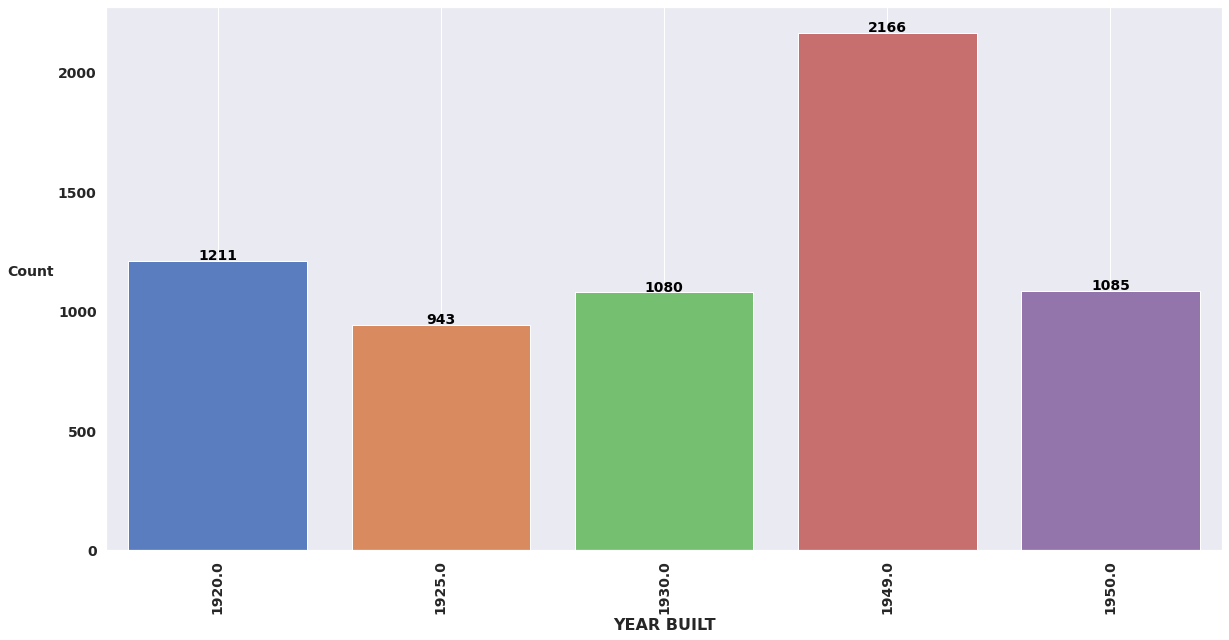

In [961]:
dist_plot('YEAR BUILT', 5)

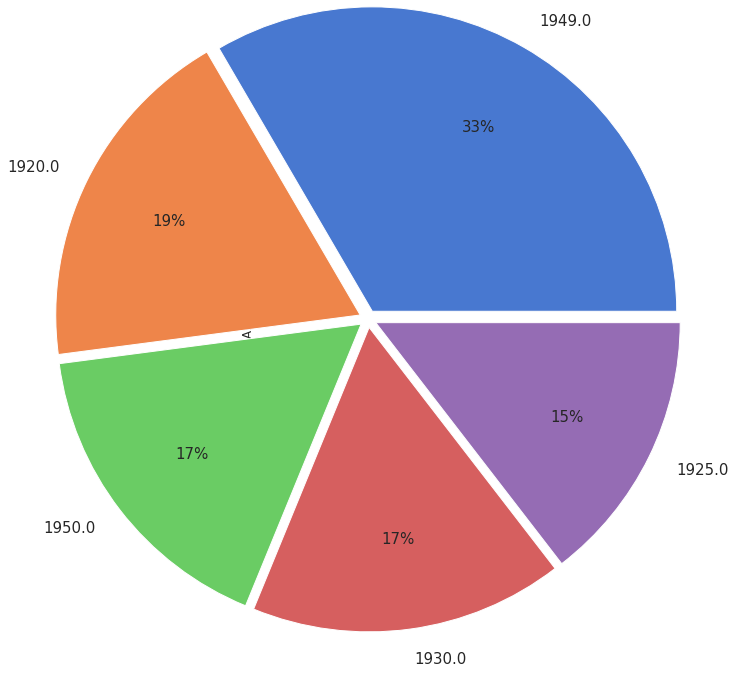

In [962]:
pie_plot('YEAR BUILT', 5)

###COMMERCIAL UNITS & RESIDENTIAL UNITS & TOTAL UNITS

In [963]:
# summary of the number of nulls and count the ratio of missing values
miss_number()

Total missing  % missing
GROSS SQUARE FEET                        5049  38.261594
LAND SQUARE FEET                         5049  38.261594
COMMERCIAL UNITS                         4667  35.366778
RESIDENTIAL UNITS                        3379  25.606244
TOTAL UNITS                              2997  22.711428
SALE PRICE                                  0   0.000000
BUILDING CLASS AT TIME OF SALE              0   0.000000
TAX CLASS AT TIME OF SALE                   0   0.000000
YEAR BUILT                                  0   0.000000
NEIGHBORHOOD                                0   0.000000
BUILDING CLASS CATEGORY                     0   0.000000
ZIP CODE                                    0   0.000000
ADDRESS                                     0   0.000000
BUILDING CLASS AT PRESENT                   0   0.000000
LOT                                         0   0.000000
BLOCK                                       0   0.000000
TAX CLASS AT PRESENT                        0   0.000000
SALE DATE                                   0   0.000000

####COMMERCIAL UNITS

In [964]:
# checking for the distribution
len(df['COMMERCIAL UNITS'].value_counts())

11

In [965]:
df['COMMERCIAL UNITS'].value_counts()

0.0     7648
1.0      766
2.0       60
3.0       23
4.0       17
5.0        8
6.0        2
7.0        2
89.0       1
72.0       1
10.0       1
Name: COMMERCIAL UNITS, dtype: int64

In [966]:
#convert categorical to numerical 
df['COMMERCIAL UNITS'] = pd.to_numeric(df['COMMERCIAL UNITS'], errors='coerce')

In [967]:
# checking for the distribution
len(df['COMMERCIAL UNITS'].value_counts())

11

####RESIDENTIAL UNITS

In [968]:
# checking for the distribution
len(df['RESIDENTIAL UNITS'].value_counts())

36

In [969]:
df['RESIDENTIAL UNITS'].value_counts()

1.0      6170
2.0      2518
0.0       508
3.0       394
4.0        93
6.0        43
48.0       23
5.0        20
10.0        4
8.0         4
7.0         3
60.0        3
12.0        3
17.0        3
23.0        2
112.0       2
18.0        2
28.0        2
9.0         2
11.0        2
32.0        1
44.0        1
25.0        1
105.0       1
27.0        1
81.0        1
38.0        1
132.0       1
21.0        1
24.0        1
165.0       1
16.0        1
291.0       1
181.0       1
20.0        1
77.0        1
Name: RESIDENTIAL UNITS, dtype: int64

In [970]:
#convert categorical to numerical 
df['RESIDENTIAL UNITS'] = pd.to_numeric(df['RESIDENTIAL UNITS'], errors='coerce')

In [971]:
# checking for the distribution
len(df['RESIDENTIAL UNITS'].value_counts())

36

####TOTAL UNITS

In [972]:
# checking for the distribution
len(df['TOTAL UNITS'].value_counts())

41

In [973]:
df['TOTAL UNITS'].value_counts()

1.0      6673
2.0      2501
3.0       490
0.0       253
4.0       101
6.0        54
5.0        45
49.0       21
7.0        10
9.0         5
23.0        3
10.0        3
60.0        3
17.0        3
16.0        2
18.0        2
12.0        2
8.0         2
20.0        2
48.0        2
28.0        2
292.0       1
27.0        1
25.0        1
32.0        1
44.0        1
15.0        1
112.0       1
13.0        1
105.0       1
81.0        1
89.0        1
114.0       1
11.0        1
132.0       1
72.0        1
24.0        1
167.0       1
38.0        1
181.0       1
77.0        1
Name: TOTAL UNITS, dtype: int64

In [974]:
#convert categorical to numerical 
df['TOTAL UNITS'] = pd.to_numeric(df['TOTAL UNITS'], errors='coerce')

In [975]:
# checking for the distribution
len(df['TOTAL UNITS'].value_counts())

41

####Handling Missing values

In [976]:
# summary of the number of nulls and count the ratio of missing values
miss_number()

Total missing  % missing
GROSS SQUARE FEET                        5049  38.261594
LAND SQUARE FEET                         5049  38.261594
COMMERCIAL UNITS                         4667  35.366778
RESIDENTIAL UNITS                        3379  25.606244
TOTAL UNITS                              2997  22.711428
SALE PRICE                                  0   0.000000
BUILDING CLASS AT TIME OF SALE              0   0.000000
TAX CLASS AT TIME OF SALE                   0   0.000000
YEAR BUILT                                  0   0.000000
NEIGHBORHOOD                                0   0.000000
BUILDING CLASS CATEGORY                     0   0.000000
ZIP CODE                                    0   0.000000
ADDRESS                                     0   0.000000
BUILDING CLASS AT PRESENT                   0   0.000000
LOT                                         0   0.000000
BLOCK                                       0   0.000000
TAX CLASS AT PRESENT                        0   0.000000
SALE DATE                                   0   0.000000

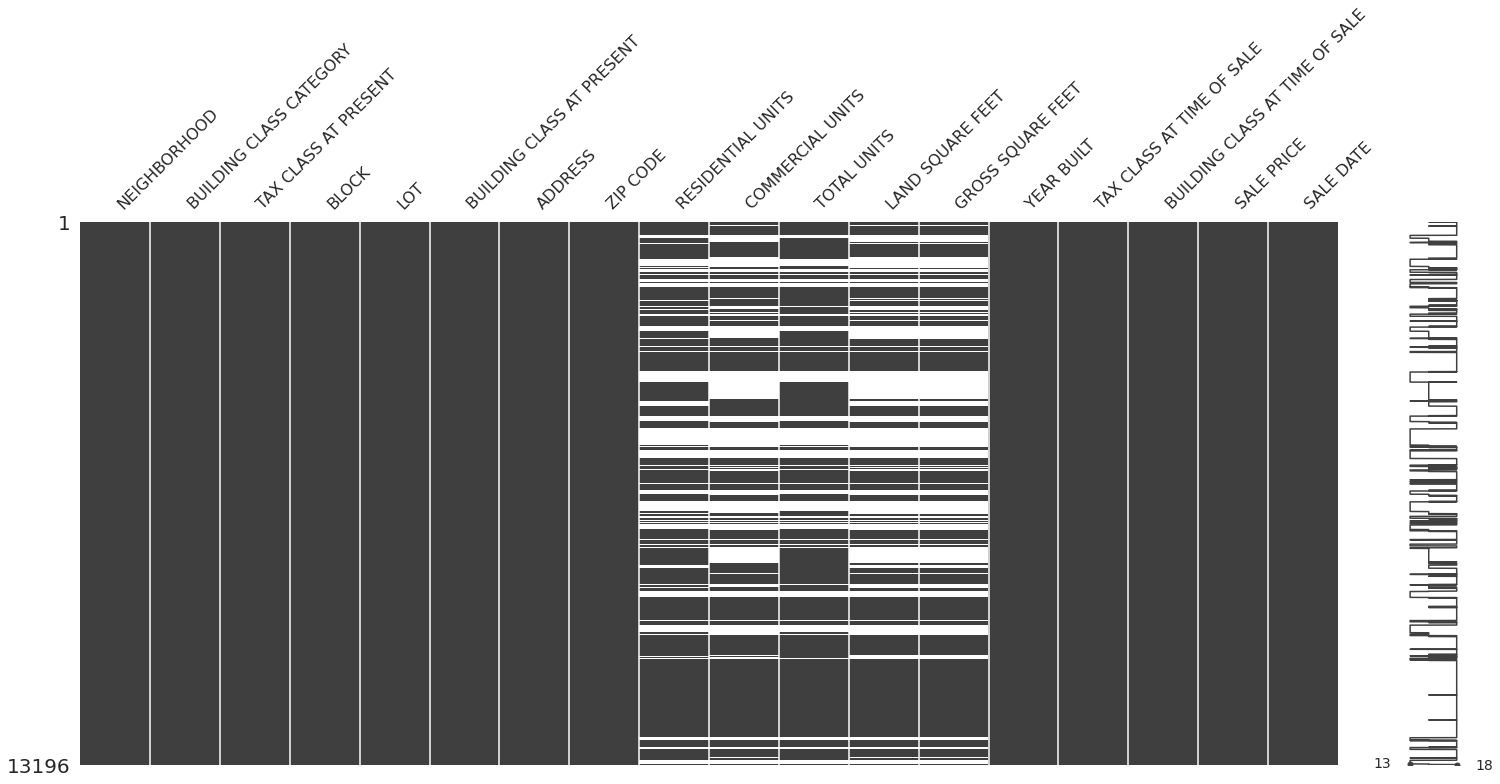

In [977]:
#visualize missing values as a matrix
msno.matrix(df, figsize=(25,10))

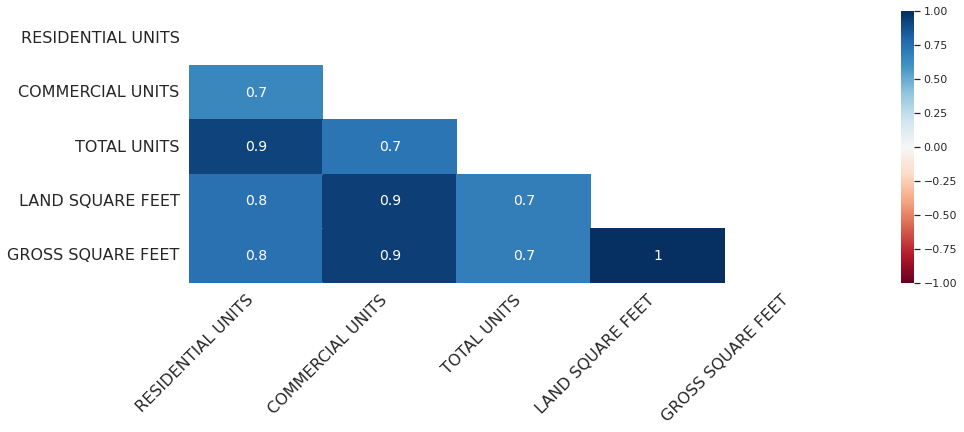

In [978]:
#bar chart
msno.heatmap(df, figsize=(15,5))

> I did search for any observation for why these data is missing but I didn't find any observation

> As we can see there is a pattern between these `3` columns and they have very high missing correlation between each other, So I will use them to fill the nulls

> I will use `IterativeImputer` to fill the null values for all of these columns

In [979]:
imputer = IterativeImputer(max_iter=20, random_state=42)
df[['COMMERCIAL UNITS',  'RESIDENTIAL UNITS', 'TOTAL UNITS']] = imputer.fit_transform(df[['COMMERCIAL UNITS',  'RESIDENTIAL UNITS', 'TOTAL UNITS']])

In [980]:
df[['COMMERCIAL UNITS',  'RESIDENTIAL UNITS', 'TOTAL UNITS']] = df[['COMMERCIAL UNITS',  'RESIDENTIAL UNITS', 'TOTAL UNITS']].abs().apply(np.ceil)

In [981]:
# summary of the number of nulls and count the ratio of missing values
miss_number()

Total missing  % missing
GROSS SQUARE FEET                        5049  38.261594
LAND SQUARE FEET                         5049  38.261594
NEIGHBORHOOD                                0   0.000000
BUILDING CLASS CATEGORY                     0   0.000000
SALE PRICE                                  0   0.000000
BUILDING CLASS AT TIME OF SALE              0   0.000000
TAX CLASS AT TIME OF SALE                   0   0.000000
YEAR BUILT                                  0   0.000000
TOTAL UNITS                                 0   0.000000
COMMERCIAL UNITS                            0   0.000000
RESIDENTIAL UNITS                           0   0.000000
ZIP CODE                                    0   0.000000
ADDRESS                                     0   0.000000
BUILDING CLASS AT PRESENT                   0   0.000000
LOT                                         0   0.000000
BLOCK                                       0   0.000000
TAX CLASS AT PRESENT                        0   0.000000
SALE DATE                                   0   0.000000

####Handling Outliers values

#####COMMERCIAL UNITS

In [982]:
#convert from scientific notation to describe dataset
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)).transpose()

count           mean            std  \
BLOCK                      13196.00000     6855.02940     4513.25766   
LOT                        13196.00000      241.46681      460.09069   
ZIP CODE                   13196.00000    11374.87125      121.09149   
RESIDENTIAL UNITS          13196.00000        1.71560        4.64382   
COMMERCIAL UNITS           13196.00000        0.44915        1.13723   
TOTAL UNITS                13196.00000        1.78213        4.78106   
YEAR BUILT                 13196.00000     1944.03054       18.65639   
TAX CLASS AT TIME OF SALE  13196.00000        1.52751        0.77303   
SALE PRICE                 13196.00000  1071191.06457  6308969.78872   

                                   min           25%           50%  \
BLOCK                         15.00000    2975.75000    6429.00000   
LOT                            1.00000      16.00000      41.00000   
ZIP CODE                   11001.00000   11361.00000   11375.00000   
RESIDENTIAL UNITS              0.00000       1.00000       1.00000   
COMMERCIAL UNITS               0.00000       0.00000       0.00000   
TOTAL UNITS                    0.00000       1.00000       1.00000   
YEAR BUILT                  1890.00000    1930.00000    1949.00000   
TAX CLASS AT TIME OF SALE      1.00000       1.00000       1.00000   
SALE PRICE                     1.00000  369000.00000  615000.00000   

                                    75%              max  
BLOCK                       10604.00000      16350.00000  
LOT                           105.00000       4607.00000  
ZIP CODE                    11420.00000      11697.00000  
RESIDENTIAL UNITS               2.00000        291.00000  
COMMERCIAL UNITS                1.00000         89.00000  
TOTAL UNITS                     2.00000        292.00000  
YEAR BUILT                   1952.00000       2005.00000  
TAX CLASS AT TIME OF SALE       2.00000          4.00000  
SALE PRICE                 875000.00000  369300000.00000

In [983]:
#Checking for outliers boundaries
fig = px.histogram(df, x="COMMERCIAL UNITS", marginal="box")
fig.show()

In [984]:
print(df['COMMERCIAL UNITS'].quantile(0.10))
print(df['COMMERCIAL UNITS'].quantile(0.95))

0.0
1.0


> If we looking for this diagram we will find that
* 10% = 0
* median = 1
* 95% = 1
* upper = 2

> So I will Replace all values that's less than `0`  with `0` and more than `2` with median `1`

In [985]:
df['COMMERCIAL UNITS'] = np.where(df['COMMERCIAL UNITS'] > 2, 1, df['COMMERCIAL UNITS'])
df['COMMERCIAL UNITS'] = np.where(df['COMMERCIAL UNITS'] < 0, 1, df['COMMERCIAL UNITS'])
df.describe()

BLOCK           LOT      ZIP CODE  RESIDENTIAL UNITS  \
count  13196.000000  13196.000000  13196.000000       13196.000000   
mean    6855.029403    241.466808  11374.871249           1.715596   
std     4513.257661    460.090690    121.091491           4.643825   
min       15.000000      1.000000  11001.000000           0.000000   
25%     2975.750000     16.000000  11361.000000           1.000000   
50%     6429.000000     41.000000  11375.000000           1.000000   
75%    10604.000000    105.000000  11420.000000           2.000000   
max    16350.000000   4607.000000  11697.000000         291.000000   

       COMMERCIAL UNITS   TOTAL UNITS    YEAR BUILT  \
count      13196.000000  13196.000000  13196.000000   
mean           0.424977      1.782131   1944.030540   
std            0.503472      4.781062     18.656389   
min            0.000000      0.000000   1890.000000   
25%            0.000000      1.000000   1930.000000   
50%            0.000000      1.000000   1949.000000   
75%            1.000000      2.000000   1952.000000   
max            2.000000    292.000000   2005.000000   

       TAX CLASS AT TIME OF SALE    SALE PRICE  
count               13196.000000  1.319600e+04  
mean                    1.527508  1.071191e+06  
std                     0.773030  6.308970e+06  
min                     1.000000  1.000000e+00  
25%                     1.000000  3.690000e+05  
50%                     1.000000  6.150000e+05  
75%                     2.000000  8.750000e+05  
max                     4.000000  3.693000e+08

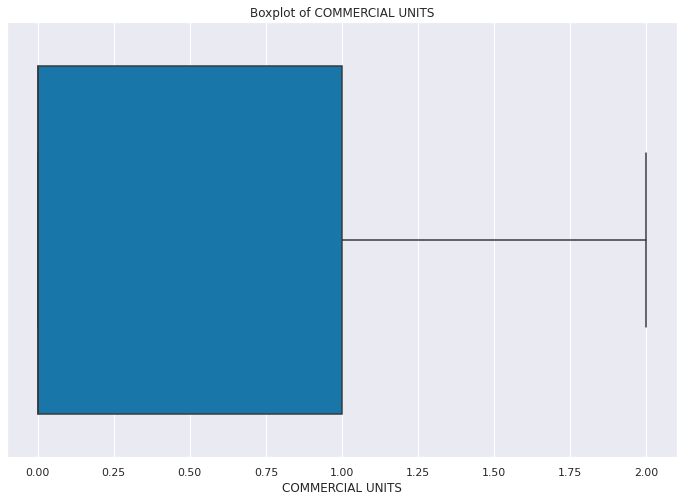

In [986]:
#Set the size of the plot
plt.figure(figsize=(12,8))
df_ = df['COMMERCIAL UNITS']
sns.boxplot(x=df_, palette="winter_r")
plt.title('Boxplot of COMMERCIAL UNITS')
plt.show()

#####RESIDENTIAL UNITS

In [987]:
#convert from scientific notation to describe dataset
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)).transpose()

count           mean            std  \
BLOCK                      13196.00000     6855.02940     4513.25766   
LOT                        13196.00000      241.46681      460.09069   
ZIP CODE                   13196.00000    11374.87125      121.09149   
RESIDENTIAL UNITS          13196.00000        1.71560        4.64382   
COMMERCIAL UNITS           13196.00000        0.42498        0.50347   
TOTAL UNITS                13196.00000        1.78213        4.78106   
YEAR BUILT                 13196.00000     1944.03054       18.65639   
TAX CLASS AT TIME OF SALE  13196.00000        1.52751        0.77303   
SALE PRICE                 13196.00000  1071191.06457  6308969.78872   

                                   min           25%           50%  \
BLOCK                         15.00000    2975.75000    6429.00000   
LOT                            1.00000      16.00000      41.00000   
ZIP CODE                   11001.00000   11361.00000   11375.00000   
RESIDENTIAL UNITS              0.00000       1.00000       1.00000   
COMMERCIAL UNITS               0.00000       0.00000       0.00000   
TOTAL UNITS                    0.00000       1.00000       1.00000   
YEAR BUILT                  1890.00000    1930.00000    1949.00000   
TAX CLASS AT TIME OF SALE      1.00000       1.00000       1.00000   
SALE PRICE                     1.00000  369000.00000  615000.00000   

                                    75%              max  
BLOCK                       10604.00000      16350.00000  
LOT                           105.00000       4607.00000  
ZIP CODE                    11420.00000      11697.00000  
RESIDENTIAL UNITS               2.00000        291.00000  
COMMERCIAL UNITS                1.00000          2.00000  
TOTAL UNITS                     2.00000        292.00000  
YEAR BUILT                   1952.00000       2005.00000  
TAX CLASS AT TIME OF SALE       2.00000          4.00000  
SALE PRICE                 875000.00000  369300000.00000

In [988]:
#Checking for outliers boundaries
fig = px.histogram(df, x="RESIDENTIAL UNITS", marginal="box")
fig.show()

In [989]:
print(df['RESIDENTIAL UNITS'].quantile(0.10))
print(df['RESIDENTIAL UNITS'].quantile(0.96))

1.0
3.0


> If we looking for this diagram we will find that
* 10% = 1
* median = 1
* 96% = 3
* upper = 3

> So I will Replace all values that's less than `0`  with `0` and more than `3` with median `1`

In [990]:
df['RESIDENTIAL UNITS'] = np.where(df['RESIDENTIAL UNITS'] > 3, 1, df['RESIDENTIAL UNITS'])
df['RESIDENTIAL UNITS'] = np.where(df['RESIDENTIAL UNITS'] < 0, 1, df['RESIDENTIAL UNITS'])
df.describe()

BLOCK           LOT      ZIP CODE  RESIDENTIAL UNITS  \
count  13196.000000  13196.000000  13196.000000       13196.000000   
mean    6855.029403    241.466808  11374.871249           1.439148   
std     4513.257661    460.090690    121.091491           0.618898   
min       15.000000      1.000000  11001.000000           0.000000   
25%     2975.750000     16.000000  11361.000000           1.000000   
50%     6429.000000     41.000000  11375.000000           1.000000   
75%    10604.000000    105.000000  11420.000000           2.000000   
max    16350.000000   4607.000000  11697.000000           3.000000   

       COMMERCIAL UNITS   TOTAL UNITS    YEAR BUILT  \
count      13196.000000  13196.000000  13196.000000   
mean           0.424977      1.782131   1944.030540   
std            0.503472      4.781062     18.656389   
min            0.000000      0.000000   1890.000000   
25%            0.000000      1.000000   1930.000000   
50%            0.000000      1.000000   1949.000000   
75%            1.000000      2.000000   1952.000000   
max            2.000000    292.000000   2005.000000   

       TAX CLASS AT TIME OF SALE    SALE PRICE  
count               13196.000000  1.319600e+04  
mean                    1.527508  1.071191e+06  
std                     0.773030  6.308970e+06  
min                     1.000000  1.000000e+00  
25%                     1.000000  3.690000e+05  
50%                     1.000000  6.150000e+05  
75%                     2.000000  8.750000e+05  
max                     4.000000  3.693000e+08

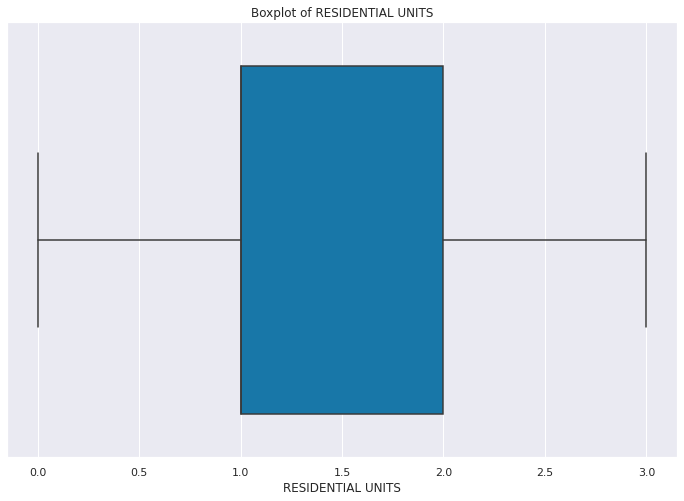

In [991]:
#Set the size of the plot
plt.figure(figsize=(12,8))
df_ = df['RESIDENTIAL UNITS']
sns.boxplot(x=df_, palette="winter_r")
plt.title('Boxplot of RESIDENTIAL UNITS')
plt.show()

#####TOTAL UNITS

In [992]:
#convert from scientific notation to describe dataset
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)).transpose()

count           mean            std  \
BLOCK                      13196.00000     6855.02940     4513.25766   
LOT                        13196.00000      241.46681      460.09069   
ZIP CODE                   13196.00000    11374.87125      121.09149   
RESIDENTIAL UNITS          13196.00000        1.43915        0.61890   
COMMERCIAL UNITS           13196.00000        0.42498        0.50347   
TOTAL UNITS                13196.00000        1.78213        4.78106   
YEAR BUILT                 13196.00000     1944.03054       18.65639   
TAX CLASS AT TIME OF SALE  13196.00000        1.52751        0.77303   
SALE PRICE                 13196.00000  1071191.06457  6308969.78872   

                                   min           25%           50%  \
BLOCK                         15.00000    2975.75000    6429.00000   
LOT                            1.00000      16.00000      41.00000   
ZIP CODE                   11001.00000   11361.00000   11375.00000   
RESIDENTIAL UNITS              0.00000       1.00000       1.00000   
COMMERCIAL UNITS               0.00000       0.00000       0.00000   
TOTAL UNITS                    0.00000       1.00000       1.00000   
YEAR BUILT                  1890.00000    1930.00000    1949.00000   
TAX CLASS AT TIME OF SALE      1.00000       1.00000       1.00000   
SALE PRICE                     1.00000  369000.00000  615000.00000   

                                    75%              max  
BLOCK                       10604.00000      16350.00000  
LOT                           105.00000       4607.00000  
ZIP CODE                    11420.00000      11697.00000  
RESIDENTIAL UNITS               2.00000          3.00000  
COMMERCIAL UNITS                1.00000          2.00000  
TOTAL UNITS                     2.00000        292.00000  
YEAR BUILT                   1952.00000       2005.00000  
TAX CLASS AT TIME OF SALE       2.00000          4.00000  
SALE PRICE                 875000.00000  369300000.00000

In [993]:
#Checking for outliers boundaries
fig = px.histogram(df, x="TOTAL UNITS", marginal="box")
fig.show()

In [994]:
print(df['TOTAL UNITS'].quantile(0.10))
print(df['TOTAL UNITS'].quantile(0.95))

1.0
3.0


> If we looking for this diagram we will find that
* 10% = 0
* median = 1
* 95% = 3
* upper = 3

> So I will Replace all values that's less than `0`  with `0` and more than `3` with median `1`

In [995]:
df['TOTAL UNITS'] = np.where(df['TOTAL UNITS'] > 3, 1, df['TOTAL UNITS'])
df['TOTAL UNITS'] = np.where(df['TOTAL UNITS'] < 0, 1, df['TOTAL UNITS'])
df.describe()

BLOCK           LOT      ZIP CODE  RESIDENTIAL UNITS  \
count  13196.000000  13196.000000  13196.000000       13196.000000   
mean    6855.029403    241.466808  11374.871249           1.439148   
std     4513.257661    460.090690    121.091491           0.618898   
min       15.000000      1.000000  11001.000000           0.000000   
25%     2975.750000     16.000000  11361.000000           1.000000   
50%     6429.000000     41.000000  11375.000000           1.000000   
75%    10604.000000    105.000000  11420.000000           2.000000   
max    16350.000000   4607.000000  11697.000000           3.000000   

       COMMERCIAL UNITS   TOTAL UNITS    YEAR BUILT  \
count      13196.000000  13196.000000  13196.000000   
mean           0.424977      1.471734   1944.030540   
std            0.503472      0.601530     18.656389   
min            0.000000      0.000000   1890.000000   
25%            0.000000      1.000000   1930.000000   
50%            0.000000      1.000000   1949.000000   
75%            1.000000      2.000000   1952.000000   
max            2.000000      3.000000   2005.000000   

       TAX CLASS AT TIME OF SALE    SALE PRICE  
count               13196.000000  1.319600e+04  
mean                    1.527508  1.071191e+06  
std                     0.773030  6.308970e+06  
min                     1.000000  1.000000e+00  
25%                     1.000000  3.690000e+05  
50%                     1.000000  6.150000e+05  
75%                     2.000000  8.750000e+05  
max                     4.000000  3.693000e+08

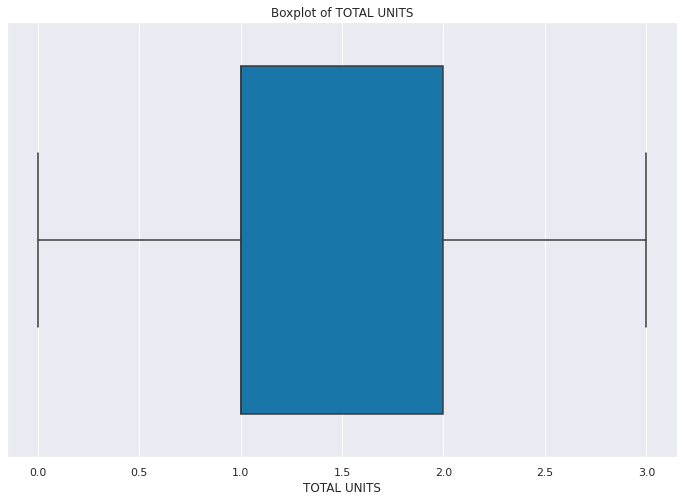

In [996]:
#Set the size of the plot
plt.figure(figsize=(12,8))
df_ = df['TOTAL UNITS']
sns.boxplot(x=df_, palette="winter_r")
plt.title('Boxplot of TOTAL UNITS')
plt.show()

####Virtualization

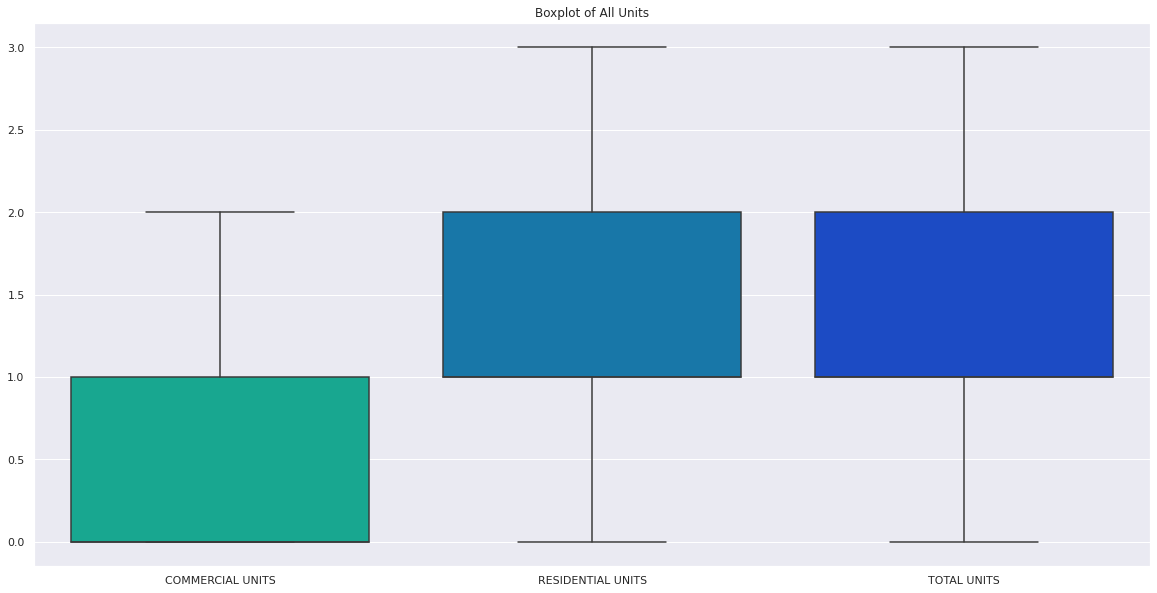

In [997]:
#Set the size of the plot
plt.figure(figsize=(20,10))

df_ = df[['COMMERCIAL UNITS','RESIDENTIAL UNITS','TOTAL UNITS']]
sns.boxplot(data=df_, palette="winter_r")
plt.title('Boxplot of All Units')
plt.show()

#####COMMERCIAL UNITS

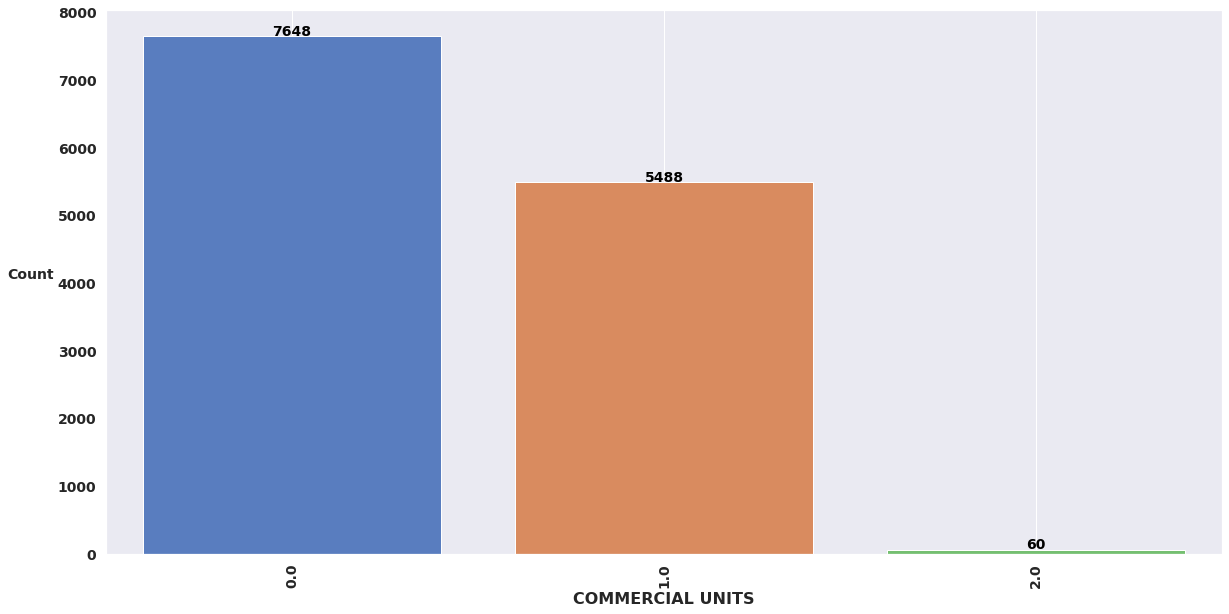

In [998]:
dist_plot('COMMERCIAL UNITS', 10)

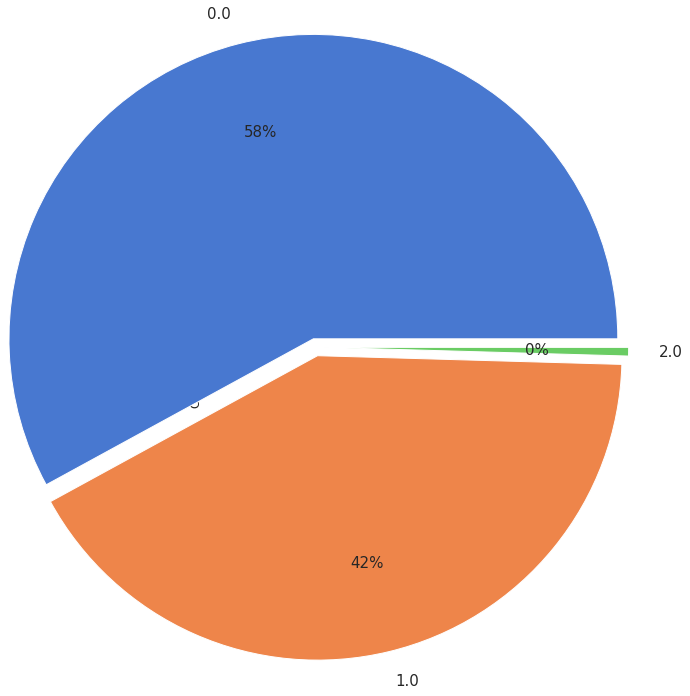

In [999]:
pie_plot('COMMERCIAL UNITS', 3)

#####RESIDENTIAL UNITS

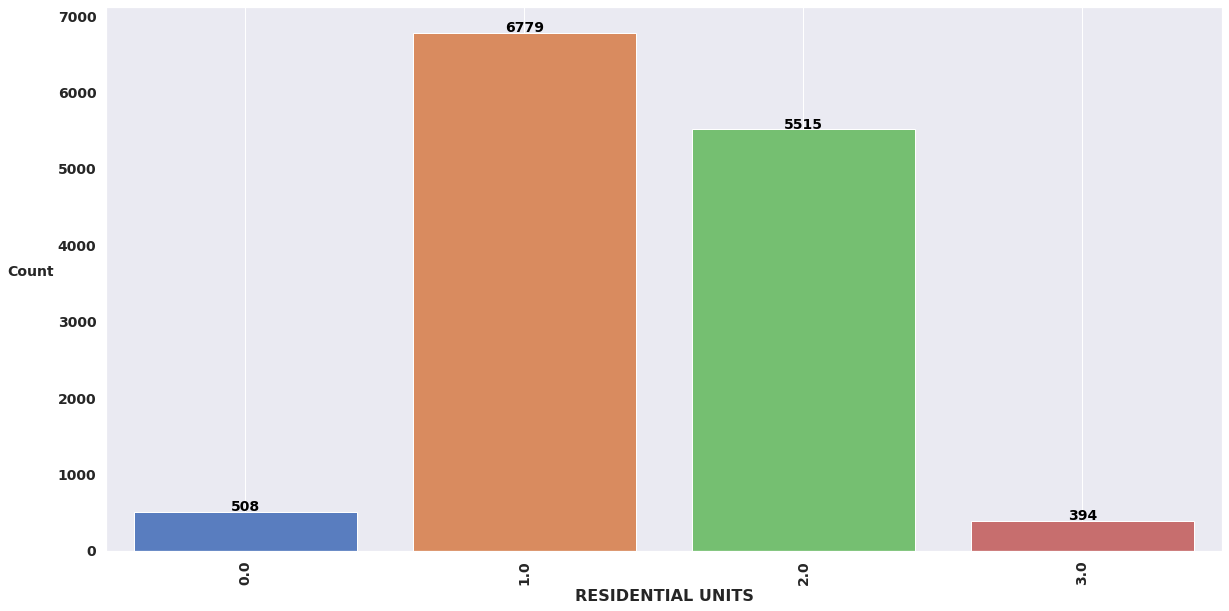

In [1000]:
dist_plot('RESIDENTIAL UNITS', 10)

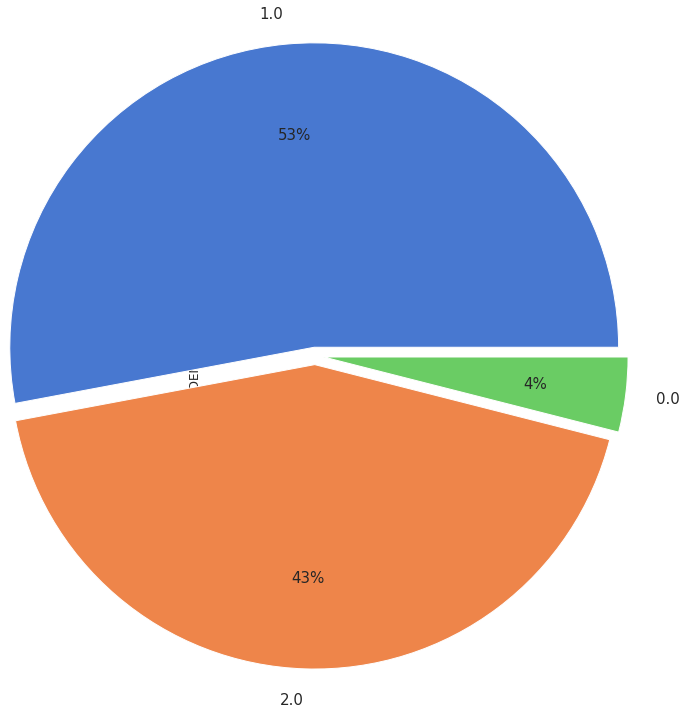

In [1001]:
pie_plot('RESIDENTIAL UNITS', 3)

#####TOTAL UNITS

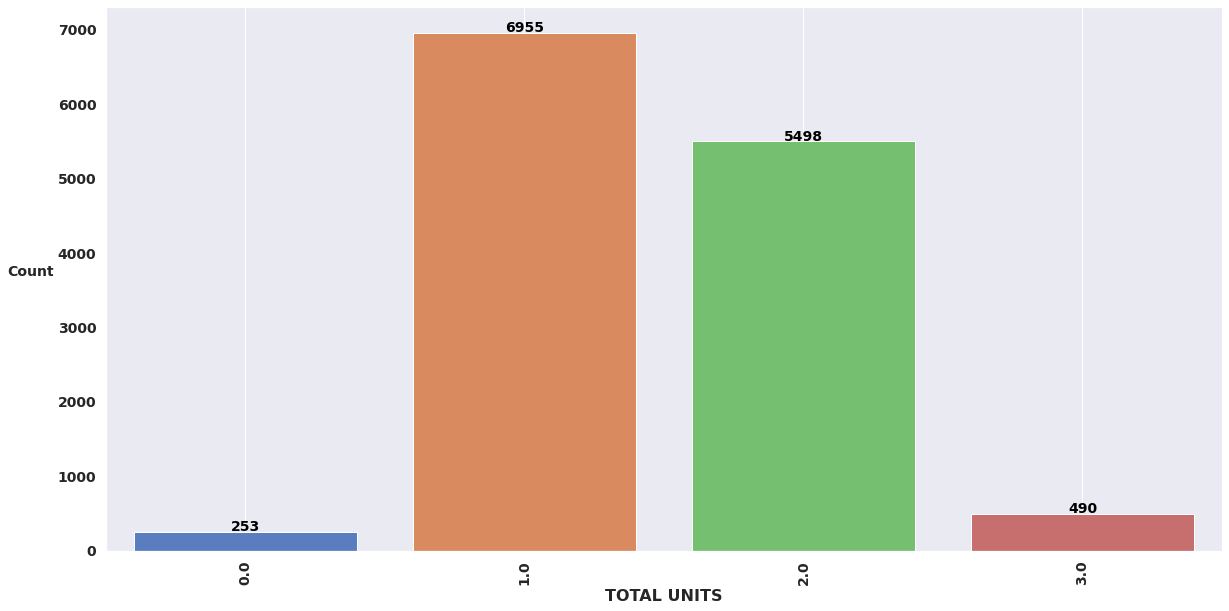

In [1002]:
dist_plot('TOTAL UNITS', 10)

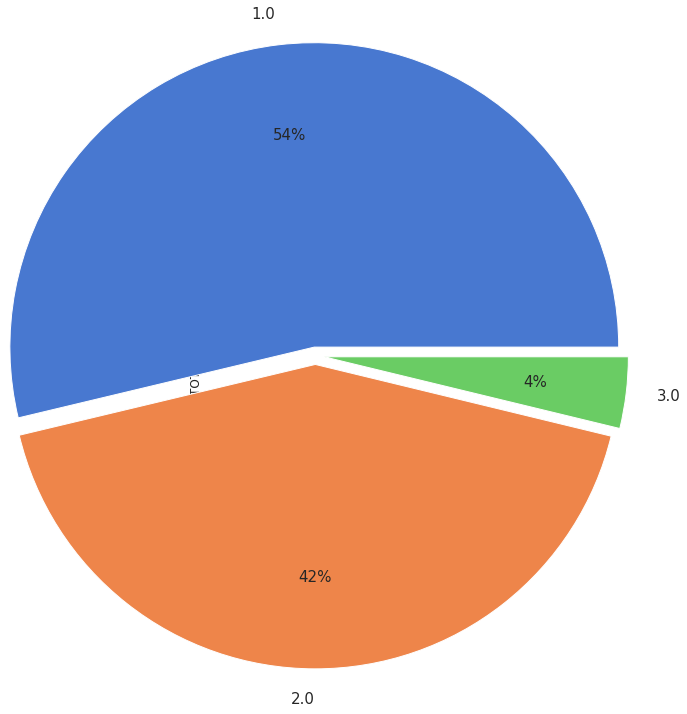

In [1003]:
pie_plot('TOTAL UNITS', 3)

###LAND SQUARE FEET & GROSS SQUARE FEET

####LAND SQUARE FEET

In [1004]:
# checking for the distribution
len(df['LAND SQUARE FEET'].value_counts())

1939

In [1005]:
df['LAND SQUARE FEET'].value_counts()

4,000     1065
2,000      610
2,500      549
3,000      358
1,800      205
          ... 
4,853        1
2,478        1
6,840        1
994          1
16,900       1
Name: LAND SQUARE FEET, Length: 1939, dtype: int64

In [1006]:
clean = lambda x: x.str.replace(',', '').str.strip().astype(float)

In [1007]:
#convert categorical to numerical 
df['LAND SQUARE FEET'] = clean(df['LAND SQUARE FEET'])

In [1008]:
# checking for the distribution
len(df['LAND SQUARE FEET'].value_counts())

1939

In [1009]:
df['LAND SQUARE FEET'].value_counts()

4000.0     1065
2000.0      610
2500.0      549
3000.0      358
1800.0      205
           ... 
4853.0        1
2478.0        1
6840.0        1
994.0         1
16900.0       1
Name: LAND SQUARE FEET, Length: 1939, dtype: int64

####GROSS SQUARE FEET

In [1010]:
# checking for the distribution
len(df['GROSS SQUARE FEET'].value_counts())

1995

In [1011]:
df['GROSS SQUARE FEET'].value_counts()

0         251
1,224      84
1,440      74
2,000      72
1,280      69
         ... 
1,629       1
2,504       1
2,465       1
4,158       1
16,800      1
Name: GROSS SQUARE FEET, Length: 1995, dtype: int64

In [1012]:
clean = lambda x: x.str.replace(',', '').str.strip().astype(float)

In [1013]:
#convert categorical to numerical 
df['GROSS SQUARE FEET'] = clean(df['GROSS SQUARE FEET'])

In [1014]:
# checking for the distribution
len(df['GROSS SQUARE FEET'].value_counts())

1995

####Handling missing values

In [1015]:
# summary of the number of nulls and count the ratio of missing values
miss_number()

Total missing  % missing
GROSS SQUARE FEET                        5049  38.261594
LAND SQUARE FEET                         5049  38.261594
NEIGHBORHOOD                                0   0.000000
BUILDING CLASS CATEGORY                     0   0.000000
SALE PRICE                                  0   0.000000
BUILDING CLASS AT TIME OF SALE              0   0.000000
TAX CLASS AT TIME OF SALE                   0   0.000000
YEAR BUILT                                  0   0.000000
TOTAL UNITS                                 0   0.000000
COMMERCIAL UNITS                            0   0.000000
RESIDENTIAL UNITS                           0   0.000000
ZIP CODE                                    0   0.000000
ADDRESS                                     0   0.000000
BUILDING CLASS AT PRESENT                   0   0.000000
LOT                                         0   0.000000
BLOCK                                       0   0.000000
TAX CLASS AT PRESENT                        0   0.000000
SALE DATE                                   0   0.000000

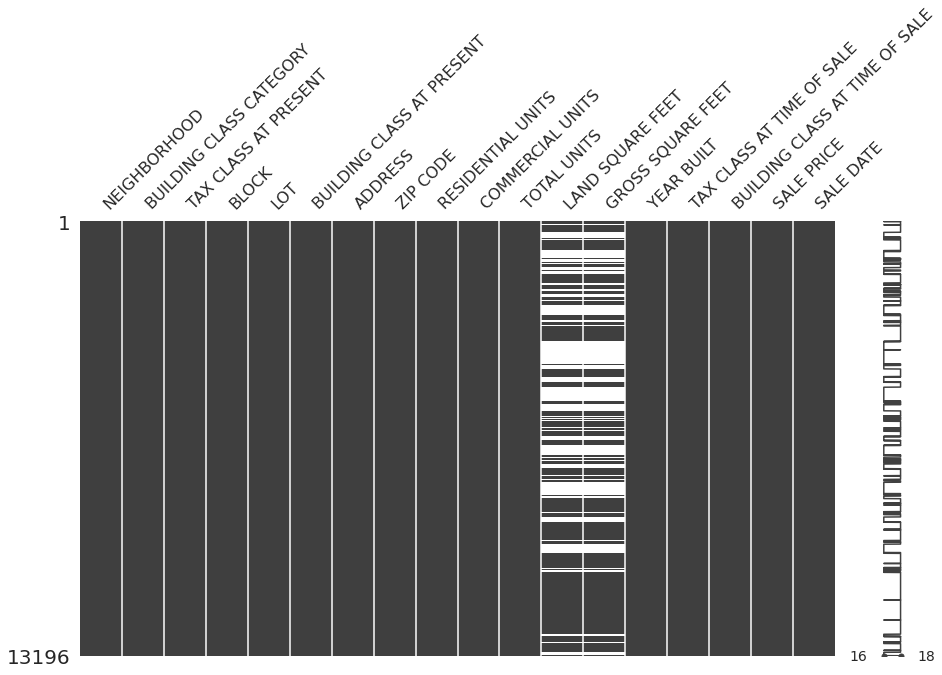

In [1016]:
#visualize missing values as a matrix
msno.matrix(df, figsize=(15,8))

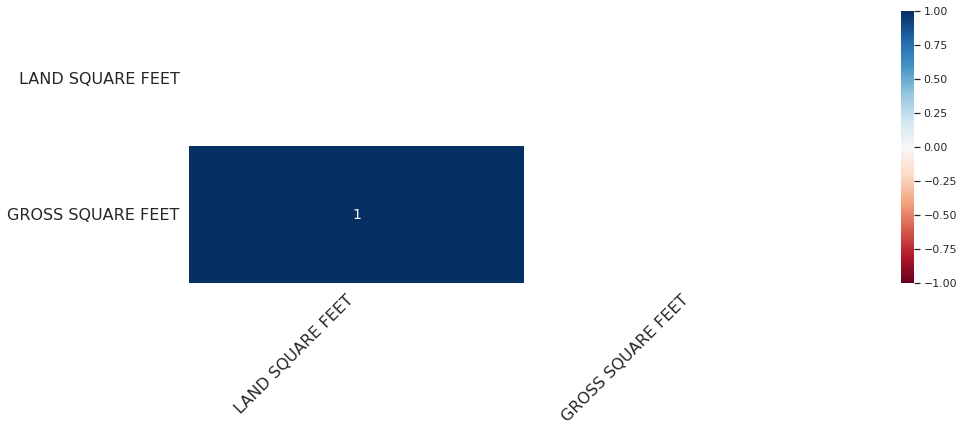

In [1017]:
#bar chart
msno.heatmap(df, figsize=(15,5))

> I did search for any observation for why these data is missing but I didn't find any observation

> As we can see there is a pattern between these `2` columns and they have very high missing correlation between each other, So I will use them to fill the nulls in each other

> I will use `IterativeImputer` to fill the null values for all of these columns

In [1018]:
imputer = IterativeImputer(max_iter=30, random_state=42)
df[['LAND SQUARE FEET', 'GROSS SQUARE FEET']] = imputer.fit_transform(df[['LAND SQUARE FEET', 'GROSS SQUARE FEET']])

In [1019]:
df[['LAND SQUARE FEET', 'GROSS SQUARE FEET']] = df[['LAND SQUARE FEET', 'GROSS SQUARE FEET']].abs().apply(np.ceil)

####Handling Outliers values

#####LAND SQUARE FEET

In [1020]:
#convert from scientific notation to describe dataset
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)).transpose()

count           mean            std  \
BLOCK                      13196.00000     6855.02940     4513.25766   
LOT                        13196.00000      241.46681      460.09069   
ZIP CODE                   13196.00000    11374.87125      121.09149   
RESIDENTIAL UNITS          13196.00000        1.43915        0.61890   
COMMERCIAL UNITS           13196.00000        0.42498        0.50347   
TOTAL UNITS                13196.00000        1.47173        0.60153   
LAND SQUARE FEET           13196.00000     3808.63148     5876.68411   
GROSS SQUARE FEET          13196.00000     2417.71491     5984.72742   
YEAR BUILT                 13196.00000     1944.03054       18.65639   
TAX CLASS AT TIME OF SALE  13196.00000        1.52751        0.77303   
SALE PRICE                 13196.00000  1071191.06457  6308969.78872   

                                   min           25%           50%  \
BLOCK                         15.00000    2975.75000    6429.00000   
LOT                            1.00000      16.00000      41.00000   
ZIP CODE                   11001.00000   11361.00000   11375.00000   
RESIDENTIAL UNITS              0.00000       1.00000       1.00000   
COMMERCIAL UNITS               0.00000       0.00000       0.00000   
TOTAL UNITS                    0.00000       1.00000       1.00000   
LAND SQUARE FEET              50.00000    2500.00000    3809.00000   
GROSS SQUARE FEET              0.00000    1437.50000    2350.00000   
YEAR BUILT                  1890.00000    1930.00000    1949.00000   
TAX CLASS AT TIME OF SALE      1.00000       1.00000       1.00000   
SALE PRICE                     1.00000  369000.00000  615000.00000   

                                    75%              max  
BLOCK                       10604.00000      16350.00000  
LOT                           105.00000       4607.00000  
ZIP CODE                    11420.00000      11697.00000  
RESIDENTIAL UNITS               2.00000          3.00000  
COMMERCIAL UNITS                1.00000          2.00000  
TOTAL UNITS                     2.00000          3.00000  
LAND SQUARE FEET             3809.00000     268092.00000  
GROSS SQUARE FEET            2418.00000     357885.00000  
YEAR BUILT                   1952.00000       2005.00000  
TAX CLASS AT TIME OF SALE       2.00000          4.00000  
SALE PRICE                 875000.00000  369300000.00000

In [1021]:
#Checking for outliers boundaries
fig = px.histogram(df, x="LAND SQUARE FEET", marginal="box")
fig.show()

In [1022]:
print(df['LAND SQUARE FEET'].quantile(0.10))
print(df['LAND SQUARE FEET'].quantile(0.95))

2000.0
5465.0


> If we looking for this diagram we will find that
* lower = 600
* q1 = 2500
* median = 3809
* 95% = 5465
* upper = 5763

> So I will Replace all values that's less than `600`  with `3809` and more than `5763`also with `3809`

In [1023]:
df['LAND SQUARE FEET'] = np.where(df['LAND SQUARE FEET'] > 5763, 3809 , df['LAND SQUARE FEET'])
df['LAND SQUARE FEET'] = np.where(df['LAND SQUARE FEET'] < 600, 3809 , df['LAND SQUARE FEET'])
df.describe()

BLOCK           LOT      ZIP CODE  RESIDENTIAL UNITS  \
count  13196.000000  13196.000000  13196.000000       13196.000000   
mean    6855.029403    241.466808  11374.871249           1.439148   
std     4513.257661    460.090690    121.091491           0.618898   
min       15.000000      1.000000  11001.000000           0.000000   
25%     2975.750000     16.000000  11361.000000           1.000000   
50%     6429.000000     41.000000  11375.000000           1.000000   
75%    10604.000000    105.000000  11420.000000           2.000000   
max    16350.000000   4607.000000  11697.000000           3.000000   

       COMMERCIAL UNITS   TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET  \
count      13196.000000  13196.000000      13196.000000       13196.000000   
mean           0.424977      1.471734       3328.875568        2417.714914   
std            0.503472      0.601530        872.953359        5984.727422   
min            0.000000      0.000000        600.000000           0.000000   
25%            0.000000      1.000000       2500.000000        1437.500000   
50%            0.000000      1.000000       3809.000000        2350.000000   
75%            1.000000      2.000000       3809.000000        2418.000000   
max            2.000000      3.000000       5763.000000      357885.000000   

         YEAR BUILT  TAX CLASS AT TIME OF SALE    SALE PRICE  
count  13196.000000               13196.000000  1.319600e+04  
mean    1944.030540                   1.527508  1.071191e+06  
std       18.656389                   0.773030  6.308970e+06  
min     1890.000000                   1.000000  1.000000e+00  
25%     1930.000000                   1.000000  3.690000e+05  
50%     1949.000000                   1.000000  6.150000e+05  
75%     1952.000000                   2.000000  8.750000e+05  
max     2005.000000                   4.000000  3.693000e+08

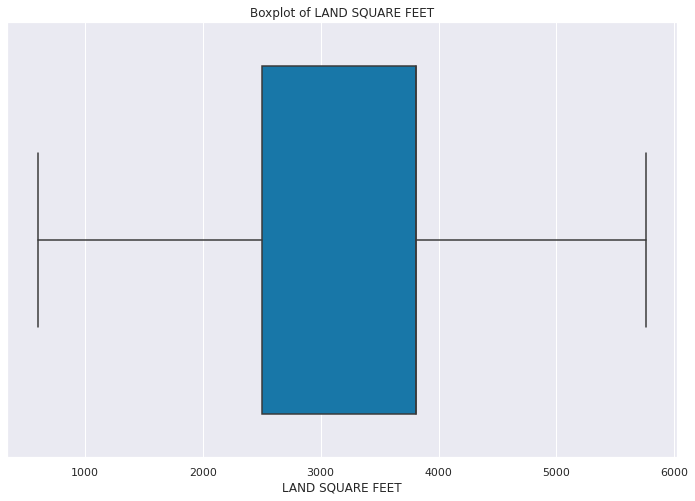

In [1024]:
#Set the size of the plot
plt.figure(figsize=(12,8))
df_ = df['LAND SQUARE FEET']
sns.boxplot(x=df_, palette="winter_r")
plt.title('Boxplot of LAND SQUARE FEET')
plt.show()

#####GROSS SQUARE FEET

In [1025]:
#convert from scientific notation to describe dataset
df.describe().apply(lambda s: s.apply('{0:.5f}'.format)).transpose()

count           mean            std  \
BLOCK                      13196.00000     6855.02940     4513.25766   
LOT                        13196.00000      241.46681      460.09069   
ZIP CODE                   13196.00000    11374.87125      121.09149   
RESIDENTIAL UNITS          13196.00000        1.43915        0.61890   
COMMERCIAL UNITS           13196.00000        0.42498        0.50347   
TOTAL UNITS                13196.00000        1.47173        0.60153   
LAND SQUARE FEET           13196.00000     3328.87557      872.95336   
GROSS SQUARE FEET          13196.00000     2417.71491     5984.72742   
YEAR BUILT                 13196.00000     1944.03054       18.65639   
TAX CLASS AT TIME OF SALE  13196.00000        1.52751        0.77303   
SALE PRICE                 13196.00000  1071191.06457  6308969.78872   

                                   min           25%           50%  \
BLOCK                         15.00000    2975.75000    6429.00000   
LOT                            1.00000      16.00000      41.00000   
ZIP CODE                   11001.00000   11361.00000   11375.00000   
RESIDENTIAL UNITS              0.00000       1.00000       1.00000   
COMMERCIAL UNITS               0.00000       0.00000       0.00000   
TOTAL UNITS                    0.00000       1.00000       1.00000   
LAND SQUARE FEET             600.00000    2500.00000    3809.00000   
GROSS SQUARE FEET              0.00000    1437.50000    2350.00000   
YEAR BUILT                  1890.00000    1930.00000    1949.00000   
TAX CLASS AT TIME OF SALE      1.00000       1.00000       1.00000   
SALE PRICE                     1.00000  369000.00000  615000.00000   

                                    75%              max  
BLOCK                       10604.00000      16350.00000  
LOT                           105.00000       4607.00000  
ZIP CODE                    11420.00000      11697.00000  
RESIDENTIAL UNITS               2.00000          3.00000  
COMMERCIAL UNITS                1.00000          2.00000  
TOTAL UNITS                     2.00000          3.00000  
LAND SQUARE FEET             3809.00000       5763.00000  
GROSS SQUARE FEET            2418.00000     357885.00000  
YEAR BUILT                   1952.00000       2005.00000  
TAX CLASS AT TIME OF SALE       2.00000          4.00000  
SALE PRICE                 875000.00000  369300000.00000

In [1026]:
#Checking for outliers boundaries
fig = px.histogram(df, x="GROSS SQUARE FEET", marginal="box")
fig.show()

In [1027]:
print(df['GROSS SQUARE FEET'].quantile(0.1))
print(df['GROSS SQUARE FEET'].quantile(0.95))

1125.0
3200.0


> If we looking for this diagram we will find that
* 10% = 1125
* q1 = 1437
* median = 2350
* q3 = 2418
* upper = 3888

> So I will Replace all values that's less than `1125.0`  with `2350` and more than `3200` also with the `median`(`2350`)

In [1028]:
df['GROSS SQUARE FEET'] = np.where(df['GROSS SQUARE FEET'] > 3200 , 2350, df['GROSS SQUARE FEET'])
df['GROSS SQUARE FEET'] = np.where(df['GROSS SQUARE FEET'] < 1125.0, 2350, df['GROSS SQUARE FEET'])
df.describe()

BLOCK           LOT      ZIP CODE  RESIDENTIAL UNITS  \
count  13196.000000  13196.000000  13196.000000       13196.000000   
mean    6855.029403    241.466808  11374.871249           1.439148   
std     4513.257661    460.090690    121.091491           0.618898   
min       15.000000      1.000000  11001.000000           0.000000   
25%     2975.750000     16.000000  11361.000000           1.000000   
50%     6429.000000     41.000000  11375.000000           1.000000   
75%    10604.000000    105.000000  11420.000000           2.000000   
max    16350.000000   4607.000000  11697.000000           3.000000   

       COMMERCIAL UNITS   TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET  \
count      13196.000000  13196.000000      13196.000000       13196.000000   
mean           0.424977      1.471734       3328.875568        2103.902849   
std            0.503472      0.601530        872.953359         465.154370   
min            0.000000      0.000000        600.000000        1125.000000   
25%            0.000000      1.000000       2500.000000        1698.000000   
50%            0.000000      1.000000       3809.000000        2350.000000   
75%            1.000000      2.000000       3809.000000        2418.000000   
max            2.000000      3.000000       5763.000000        3200.000000   

         YEAR BUILT  TAX CLASS AT TIME OF SALE    SALE PRICE  
count  13196.000000               13196.000000  1.319600e+04  
mean    1944.030540                   1.527508  1.071191e+06  
std       18.656389                   0.773030  6.308970e+06  
min     1890.000000                   1.000000  1.000000e+00  
25%     1930.000000                   1.000000  3.690000e+05  
50%     1949.000000                   1.000000  6.150000e+05  
75%     1952.000000                   2.000000  8.750000e+05  
max     2005.000000                   4.000000  3.693000e+08

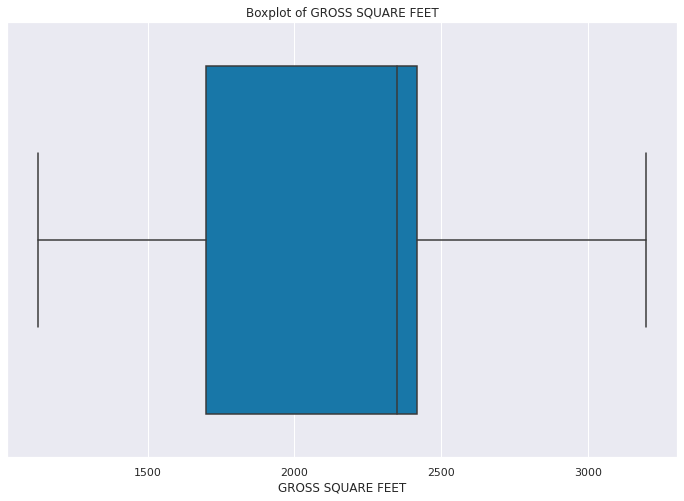

In [1029]:
#Set the size of the plot
plt.figure(figsize=(12,8))
df_ = df['GROSS SQUARE FEET']
sns.boxplot(x=df_, palette="winter_r")
plt.title('Boxplot of GROSS SQUARE FEET')
plt.show()

####Virtualization

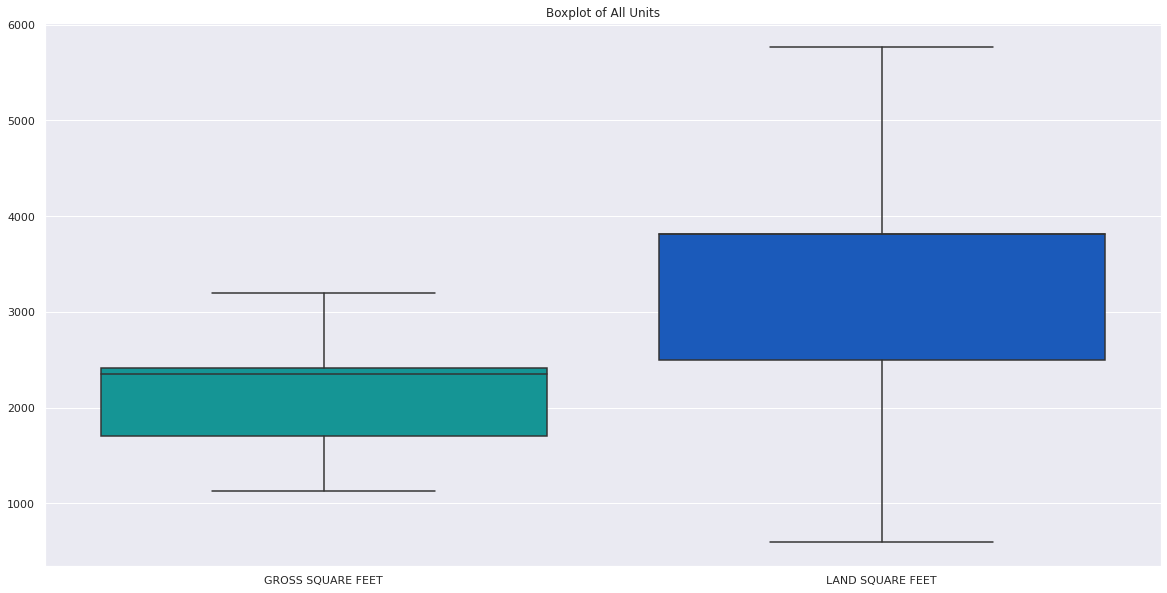

In [1030]:
#Set the size of the plot
plt.figure(figsize=(20,10))

df_ = df[['GROSS SQUARE FEET', 'LAND SQUARE FEET']]
sns.boxplot(data=df_, palette="winter_r")
plt.title('Boxplot of All Units')
plt.show()

#####GROSS SQUARE FEET

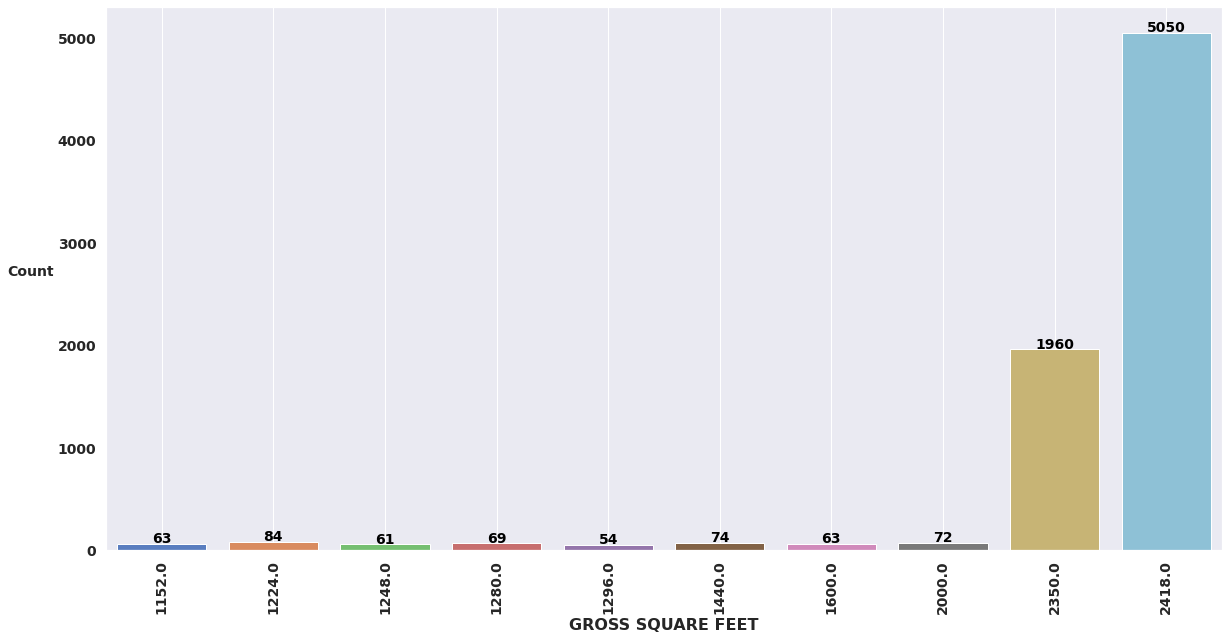

In [1031]:
dist_plot('GROSS SQUARE FEET', 10)

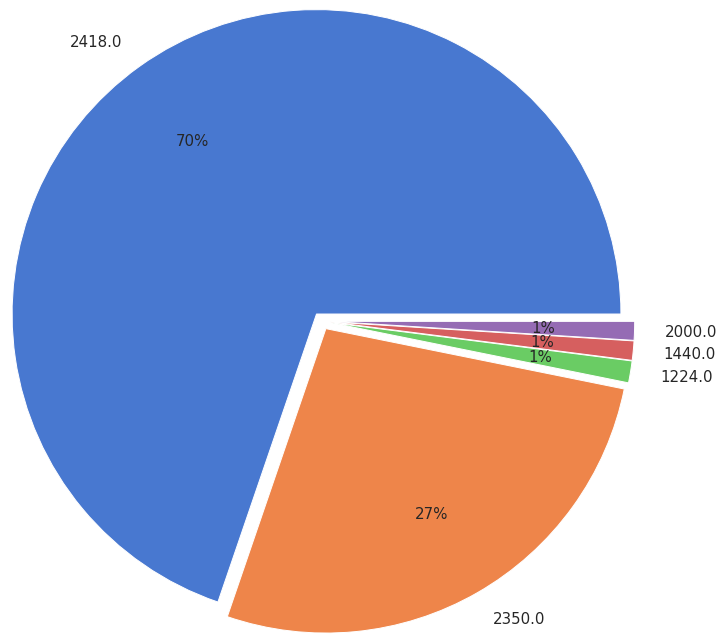

In [1032]:
pie_plot('GROSS SQUARE FEET', 5)

#####LAND SQUARE FEET

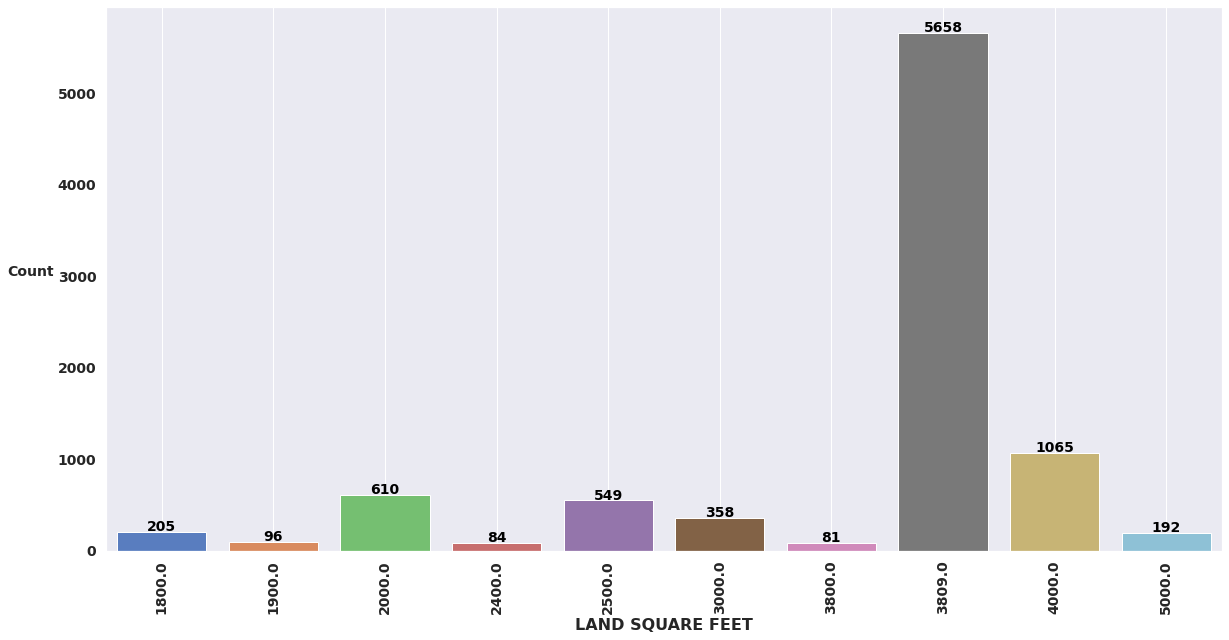

In [1033]:
dist_plot('LAND SQUARE FEET', 10)

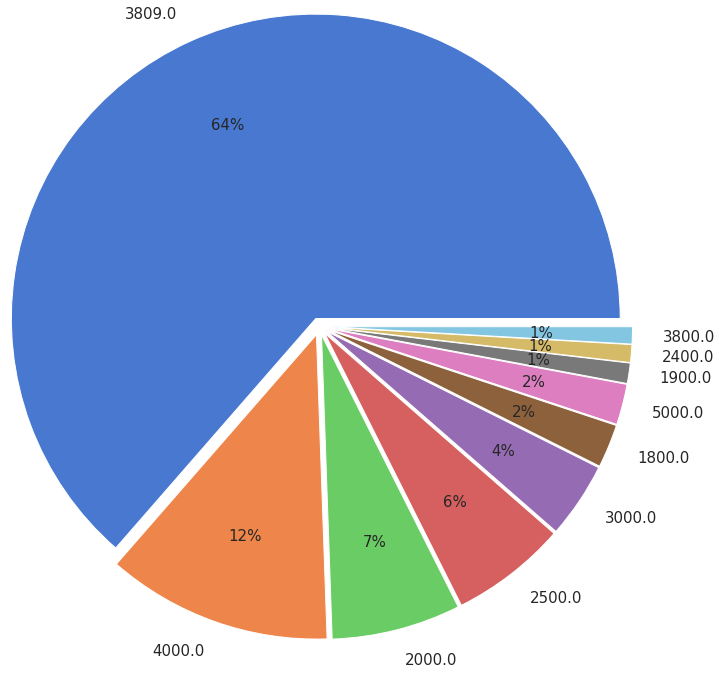

In [1034]:
pie_plot('LAND SQUARE FEET', 10)

###NEIGHBORHOOD

In [1035]:
# summary of the number of nulls and count the ratio of missing values
miss_number()

Total missing  % missing
NEIGHBORHOOD                                0        0.0
BUILDING CLASS CATEGORY                     0        0.0
SALE PRICE                                  0        0.0
BUILDING CLASS AT TIME OF SALE              0        0.0
TAX CLASS AT TIME OF SALE                   0        0.0
YEAR BUILT                                  0        0.0
GROSS SQUARE FEET                           0        0.0
LAND SQUARE FEET                            0        0.0
TOTAL UNITS                                 0        0.0
COMMERCIAL UNITS                            0        0.0
RESIDENTIAL UNITS                           0        0.0
ZIP CODE                                    0        0.0
ADDRESS                                     0        0.0
BUILDING CLASS AT PRESENT                   0        0.0
LOT                                         0        0.0
BLOCK                                       0        0.0
TAX CLASS AT PRESENT                        0        0.0
SALE DATE                                   0        0.0

In [1036]:
len(df['NEIGHBORHOOD'].value_counts())

61

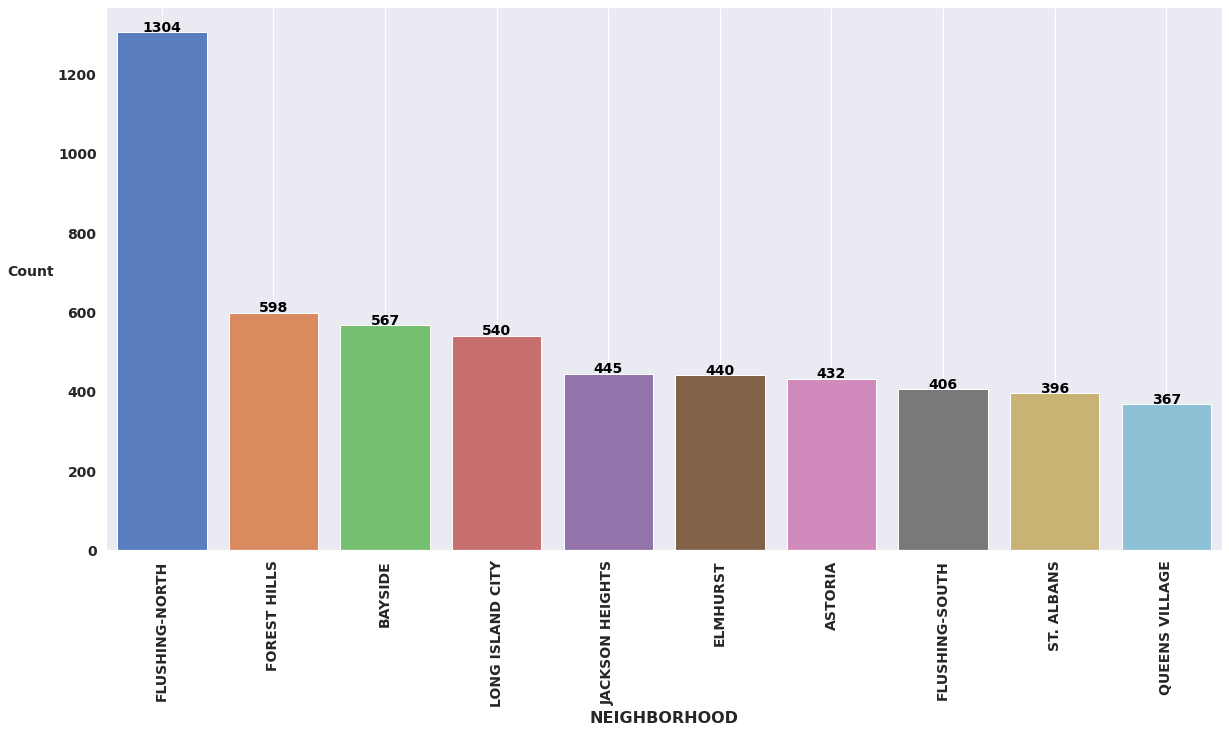

In [1037]:
dist_plot('NEIGHBORHOOD', 10)

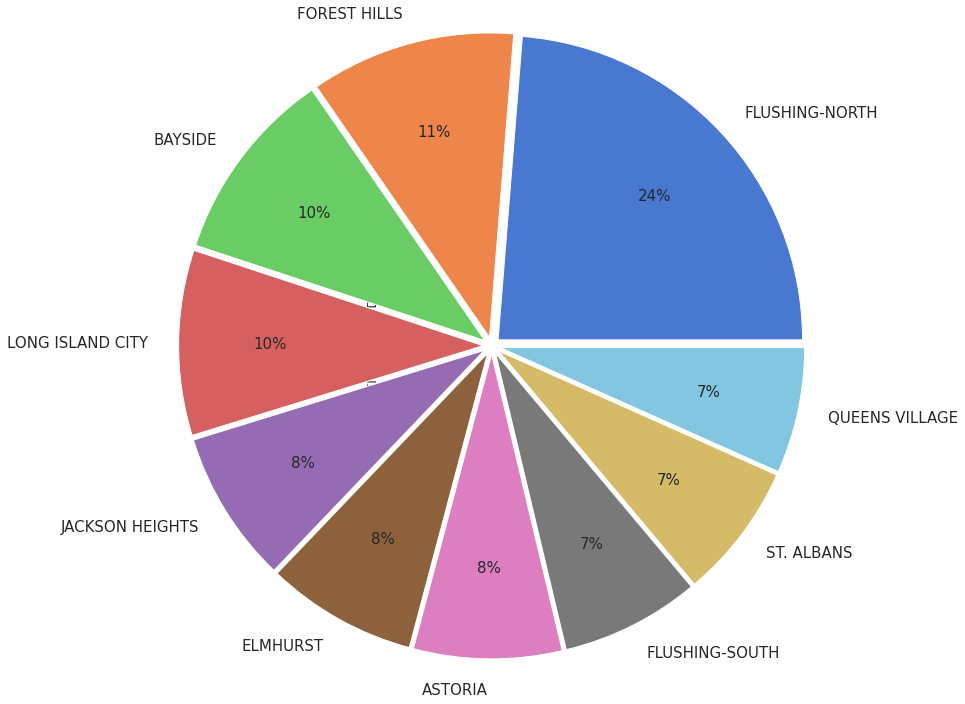

In [1038]:
pie_plot('NEIGHBORHOOD', 10)

###BUILDING CLASS CATEGORY

In [1039]:
df['BUILDING CLASS CATEGORY'].value_counts()

01 ONE FAMILY DWELLINGS                       4564
02 TWO FAMILY DWELLINGS                       2476
10 COOPS - ELEVATOR APARTMENTS                2082
13 CONDOS - ELEVATOR APARTMENTS               1155
09 COOPS - WALKUP APARTMENTS                   741
03 THREE FAMILY DWELLINGS                      379
44 CONDO PARKING                               261
12 CONDOS - WALKUP APARTMENTS                  241
04 TAX CLASS 1 CONDOS                          176
07 RENTALS - WALKUP APARTMENTS                 151
05 TAX CLASS 1 VACANT LAND                     139
22 STORE BUILDINGS                             119
17 CONDO COOPS                                 102
15 CONDOS - 2-10 UNIT RESIDENTIAL               81
29 COMMERCIAL GARAGES                           77
43 CONDO OFFICE BUILDINGS                       57
14 RENTALS - 4-10 UNIT                          54
30 WAREHOUSES                                   48
47 CONDO NON-BUSINESS STORAGE                   44
08 RENTALS - ELEVATOR APARTMENT

In [1040]:
len(df['BUILDING CLASS CATEGORY'].value_counts())

40

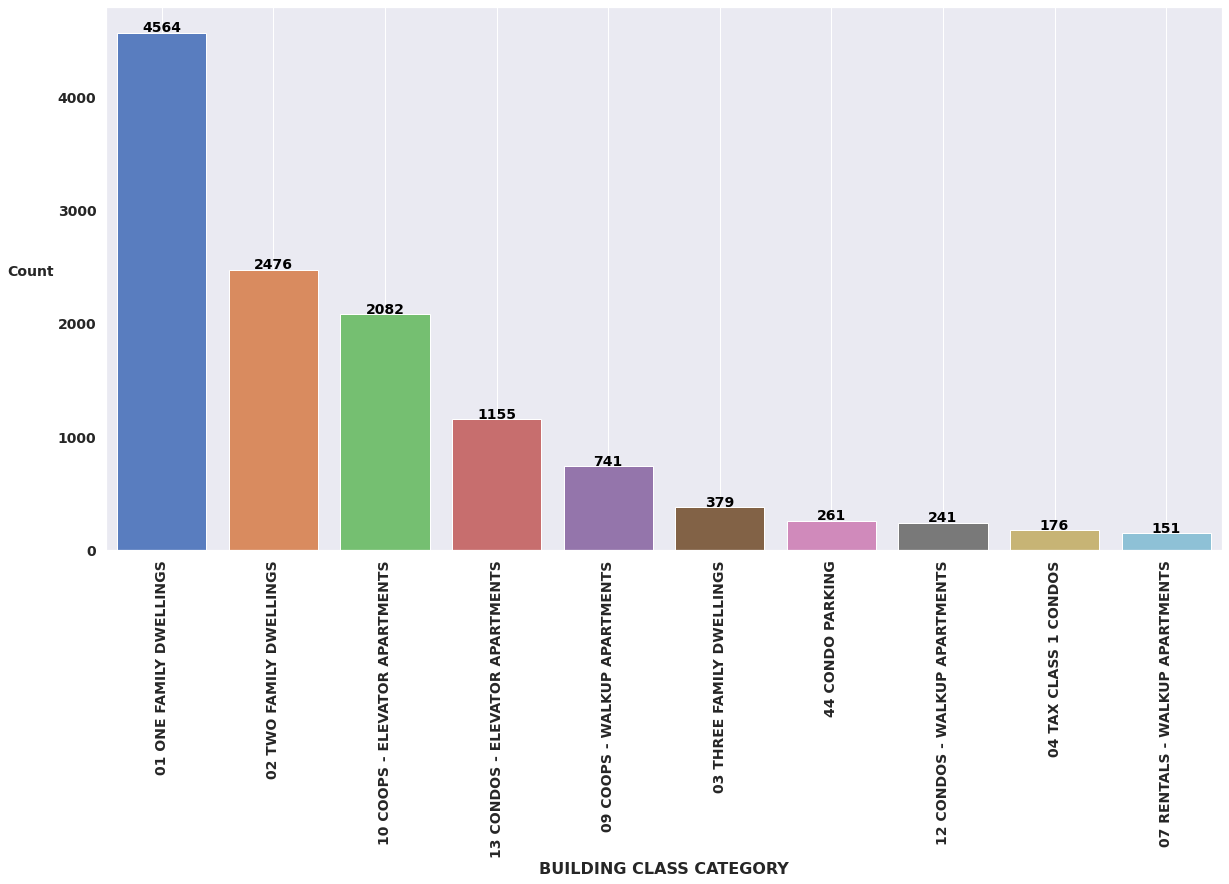

In [1041]:
dist_plot('BUILDING CLASS CATEGORY', 10)

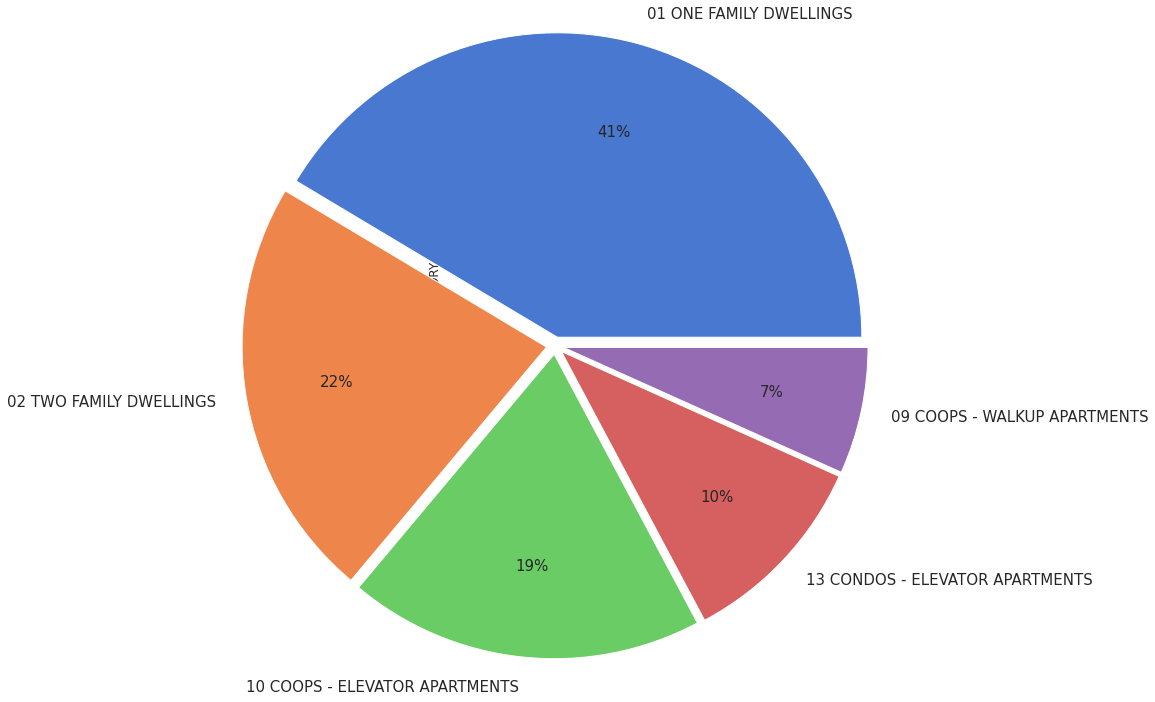

In [1042]:
pie_plot('BUILDING CLASS CATEGORY', 5)

###BLOCK

In [1043]:
df['BLOCK'].value_counts()

1536.0     136
4972.0     107
8489.0      85
424.0       69
2977.0      69
          ... 
10881.0      1
10883.0      1
10900.0      1
10907.0      1
1321.0       1
Name: BLOCK, Length: 5640, dtype: int64

In [1044]:
len(df['BLOCK'].value_counts())

5640

In [1045]:
#Checking for outliers boundaries
fig = px.histogram(df, x="BLOCK", marginal="box")
fig.show()

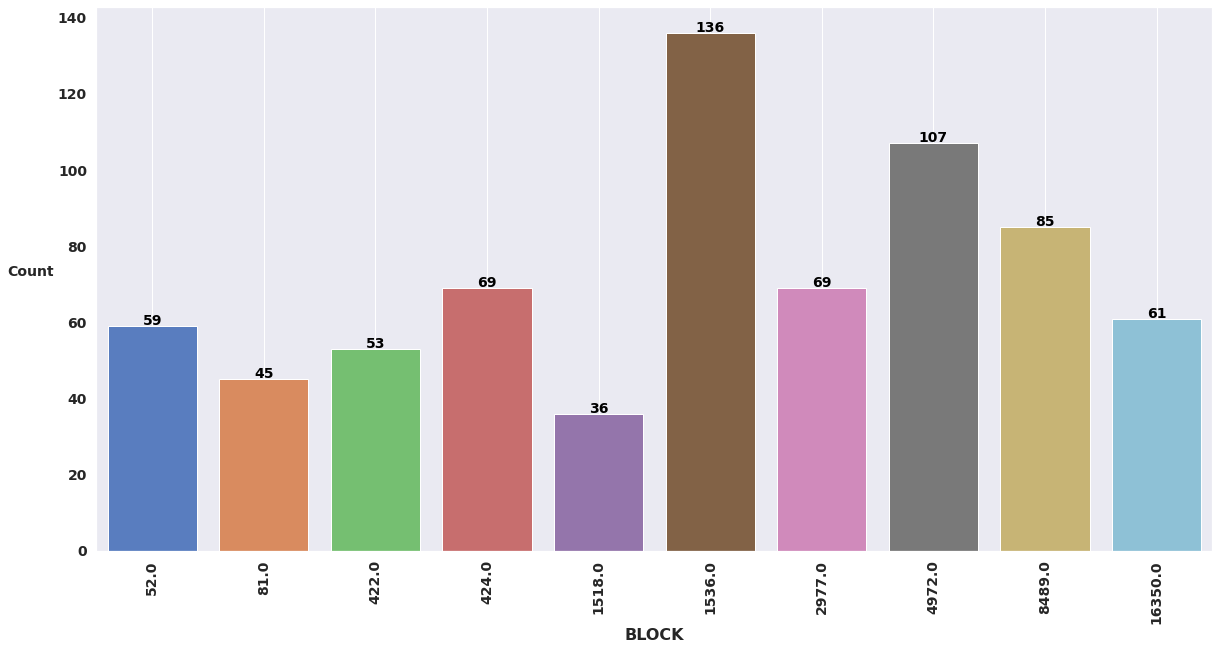

In [1046]:
dist_plot('BLOCK', 10)

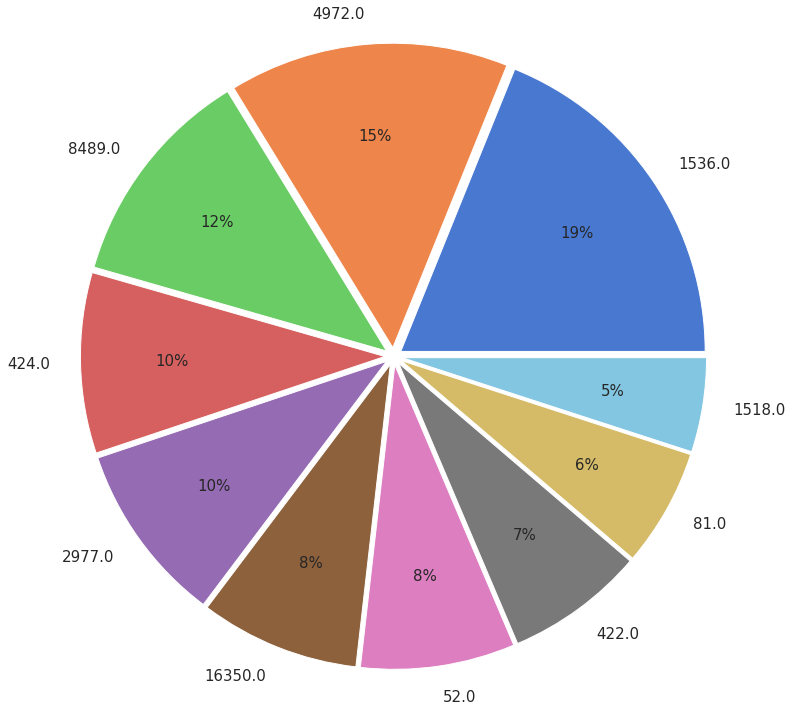

In [1047]:
pie_plot('BLOCK', 10)

###LOT

In [1048]:
df['LOT'].value_counts()

1.0       918
2.0       273
3.0       217
50.0      204
25.0      183
         ... 
1498.0      1
2311.0      1
1354.0      1
1356.0      1
216.0       1
Name: LOT, Length: 936, dtype: int64

In [1049]:
len(df['LOT'].value_counts())

936

In [1050]:
#Checking for outliers boundaries
fig = px.histogram(df, x="LOT", marginal="box")
fig.show()

In [1051]:
print(df['LOT'].quantile(0.10))
print(df['LOT'].quantile(0.95))

3.0
1202.0


> If we looking for this diagram we will find that
* min = 1
* q1 = 16
* median = 41
* q3 = 105
* upper = 237

> So I will Replace all values that's less than `1` with `41` and more than `237` with `41`

In [1052]:
df['LOT'] = np.where(df['LOT'] > 237, 41, df['LOT'])
df['LOT'] = np.where(df['LOT'] < 1, 41, df['LOT'])
df.describe()

BLOCK           LOT      ZIP CODE  RESIDENTIAL UNITS  \
count  13196.000000  13196.000000  13196.000000       13196.000000   
mean    6855.029403     40.383904  11374.871249           1.439148   
std     4513.257661     35.332367    121.091491           0.618898   
min       15.000000      1.000000  11001.000000           0.000000   
25%     2975.750000     16.000000  11361.000000           1.000000   
50%     6429.000000     41.000000  11375.000000           1.000000   
75%    10604.000000     48.000000  11420.000000           2.000000   
max    16350.000000    237.000000  11697.000000           3.000000   

       COMMERCIAL UNITS   TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET  \
count      13196.000000  13196.000000      13196.000000       13196.000000   
mean           0.424977      1.471734       3328.875568        2103.902849   
std            0.503472      0.601530        872.953359         465.154370   
min            0.000000      0.000000        600.000000        1125.000000   
25%            0.000000      1.000000       2500.000000        1698.000000   
50%            0.000000      1.000000       3809.000000        2350.000000   
75%            1.000000      2.000000       3809.000000        2418.000000   
max            2.000000      3.000000       5763.000000        3200.000000   

         YEAR BUILT  TAX CLASS AT TIME OF SALE    SALE PRICE  
count  13196.000000               13196.000000  1.319600e+04  
mean    1944.030540                   1.527508  1.071191e+06  
std       18.656389                   0.773030  6.308970e+06  
min     1890.000000                   1.000000  1.000000e+00  
25%     1930.000000                   1.000000  3.690000e+05  
50%     1949.000000                   1.000000  6.150000e+05  
75%     1952.000000                   2.000000  8.750000e+05  
max     2005.000000                   4.000000  3.693000e+08

In [1053]:
#Checking for outliers boundaries
fig = px.histogram(df, x="LOT", marginal="box")
fig.show()

> We will apply the same method for this new outliers

In [1054]:
df['LOT'] = np.where(df['LOT'] > 96, 41, df['LOT'])
df['LOT'] = np.where(df['LOT'] < 1, 41, df['LOT'])
df.describe()

BLOCK           LOT      ZIP CODE  RESIDENTIAL UNITS  \
count  13196.000000  13196.000000  13196.000000       13196.000000   
mean    6855.029403     33.355411  11374.871249           1.439148   
std     4513.257661     20.490738    121.091491           0.618898   
min       15.000000      1.000000  11001.000000           0.000000   
25%     2975.750000     16.000000  11361.000000           1.000000   
50%     6429.000000     41.000000  11375.000000           1.000000   
75%    10604.000000     41.000000  11420.000000           2.000000   
max    16350.000000     96.000000  11697.000000           3.000000   

       COMMERCIAL UNITS   TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET  \
count      13196.000000  13196.000000      13196.000000       13196.000000   
mean           0.424977      1.471734       3328.875568        2103.902849   
std            0.503472      0.601530        872.953359         465.154370   
min            0.000000      0.000000        600.000000        1125.000000   
25%            0.000000      1.000000       2500.000000        1698.000000   
50%            0.000000      1.000000       3809.000000        2350.000000   
75%            1.000000      2.000000       3809.000000        2418.000000   
max            2.000000      3.000000       5763.000000        3200.000000   

         YEAR BUILT  TAX CLASS AT TIME OF SALE    SALE PRICE  
count  13196.000000               13196.000000  1.319600e+04  
mean    1944.030540                   1.527508  1.071191e+06  
std       18.656389                   0.773030  6.308970e+06  
min     1890.000000                   1.000000  1.000000e+00  
25%     1930.000000                   1.000000  3.690000e+05  
50%     1949.000000                   1.000000  6.150000e+05  
75%     1952.000000                   2.000000  8.750000e+05  
max     2005.000000                   4.000000  3.693000e+08

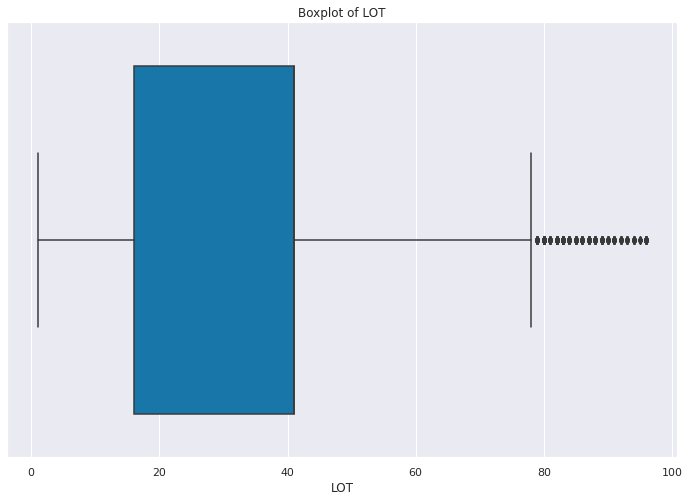

In [1055]:
#Set the size of the plot
plt.figure(figsize=(12,8))
df_ = df['LOT']
sns.boxplot(x=df_, palette="winter_r")
plt.title('Boxplot of LOT')
plt.show()

In [1056]:
df['LOT'].value_counts()

41.0    3562
1.0      918
2.0      273
3.0      217
50.0     204
        ... 
90.0      14
94.0      13
92.0      13
93.0      12
95.0       4
Name: LOT, Length: 96, dtype: int64

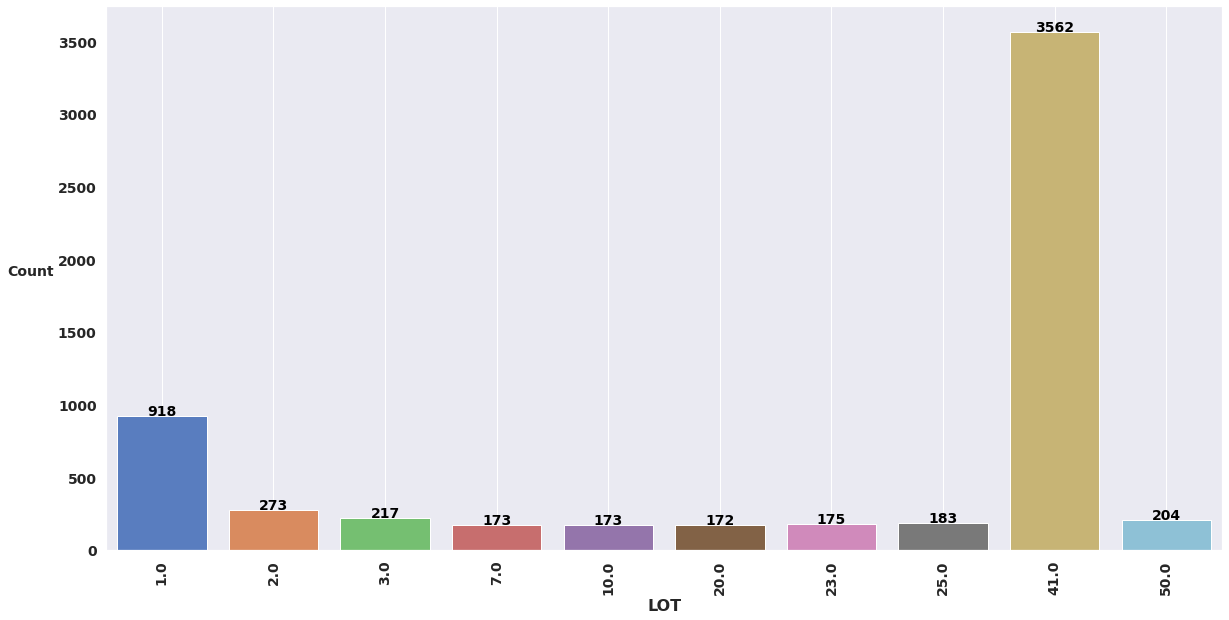

In [1057]:
dist_plot('LOT', 10)

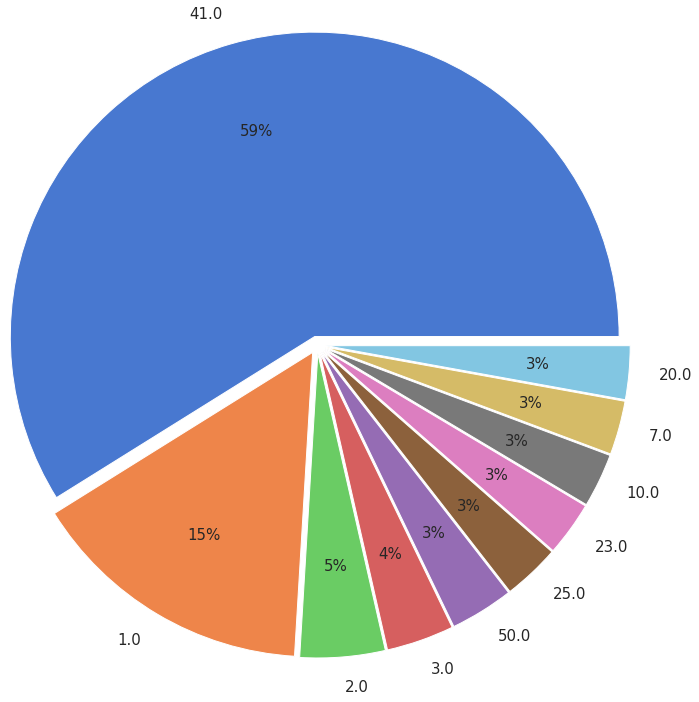

In [1058]:
pie_plot('LOT', 10)

##In the end of this task
> Now We have `No Missing Data` which is so good for the next step

> No duplicates

> the data shape is `13196 Records` , `18 column`

In [1059]:
df.shape

(13196, 18)

In [1060]:
#checking for number of duplications
df.duplicated().sum()

0

In [1061]:
# summary of the number of nulls and count the ratio of missing values
miss_number()

Total missing  % missing
NEIGHBORHOOD                                0        0.0
BUILDING CLASS CATEGORY                     0        0.0
SALE PRICE                                  0        0.0
BUILDING CLASS AT TIME OF SALE              0        0.0
TAX CLASS AT TIME OF SALE                   0        0.0
YEAR BUILT                                  0        0.0
GROSS SQUARE FEET                           0        0.0
LAND SQUARE FEET                            0        0.0
TOTAL UNITS                                 0        0.0
COMMERCIAL UNITS                            0        0.0
RESIDENTIAL UNITS                           0        0.0
ZIP CODE                                    0        0.0
ADDRESS                                     0        0.0
BUILDING CLASS AT PRESENT                   0        0.0
LOT                                         0        0.0
BLOCK                                       0        0.0
TAX CLASS AT PRESENT                        0        0.0
SALE DATE                                   0        0.0

#Task 2: Data exploration using data visualization. Raise two questions that can be answered by performing data visualization.

##Question 2.1: {put your raised question here}

###what are the number of units are sold for each month?

> In the begining I want to create `[MONTH SELL`,`YEAR SELL]` Column to know the distribution of all sells for all months in every year

> This question is important for real estate companies to know the best time of the year to buy buildings to save more money and to know the best time of the year to sell buildings to make a lot of money

> **who is your audience:** any company or any person want to buy an apartment

In [1062]:
# convert it into date type
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])

# create two new columns
df['YEAR SELL'] = (df['SALE DATE']).dt.year
df['MONTH SELL']= (df['SALE DATE']).dt.month

Text(0.5, 0.9, 'Monthly Sales')

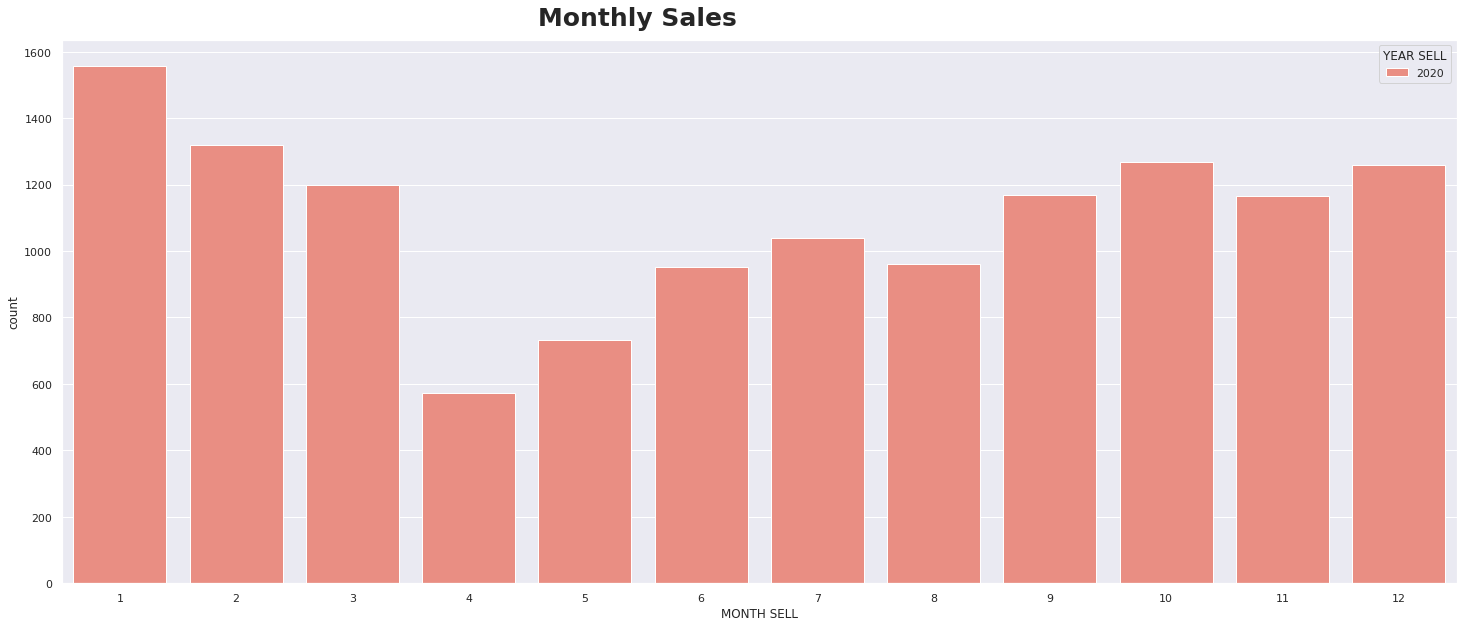

In [1063]:
# Housing Sales per Borough by Months
sns.set(palette="muted", color_codes=True)
plt.figure(figsize=(25,10))
sns.countplot('MONTH SELL', hue='YEAR SELL', data=df, palette='dark:salmon_r')
plt.figtext(.5,.9,"Monthly Sales", fontsize=25, fontweight='bold', fontname='helvetica', ha='right') #title formatting

> So As we see from the previous results we can get that 
* The `Maximum` value is `around 1600` Data ==> `[Month : 1, Year : 2020]`
* The `Minimum` value is `around 600` Data ==> `[Month : 4, Year : 2020]`

##Question 2.2: {put your raised question here.}

### **What is the `new building` at the `lowest selling price`?**

> **This question is very important for everyone because all people are looking for new homes with low budget**

> **who is your audience:** Who wants to buy a new building or apartment

> in the begining I will create a new column with the age of every building by substract the number of current year `[2022]` from all `YEAR BUILT` values

In [1064]:
df['AGE'] = 2022 - df['YEAR BUILT'] 
df.head()

NEIGHBORHOOD        BUILDING CLASS CATEGORY TAX CLASS AT PRESENT  \
0         AIRPORT JFK   39 TRANSPORTATION FACILITIES                    4   
1  AIRPORT LA GUARDIA        01 ONE FAMILY DWELLINGS                    1   
2  AIRPORT LA GUARDIA  12 CONDOS - WALKUP APARTMENTS                    2   
3             ARVERNE        01 ONE FAMILY DWELLINGS                    1   
4             ARVERNE        01 ONE FAMILY DWELLINGS                    1   

     BLOCK   LOT BUILDING CLASS AT PRESENT                ADDRESS  ZIP CODE  \
0  14260.0  80.0                        V7      N/A ROCKAWAY BLVD   11434.0   
1    949.0  41.0                        A5      19-62 81ST STREET   11370.0   
2    949.0  41.0                        R2   19-37 80TH STREET, 1   11370.0   
3  15830.0  20.0                        A5   3-20 BEACH 41 STREET   11691.0   
4  15830.0  27.0                        A5  336 BEACH 41ST STREET   11691.0   

   RESIDENTIAL UNITS  COMMERCIAL UNITS  ...  LAND SQUARE FEET  \
0                0.0               0.0  ...            3809.0   
1                1.0               0.0  ...            1800.0   
2                1.0               1.0  ...            3809.0   
3                1.0               0.0  ...            2469.0   
4                1.0               0.0  ...            2325.0   

   GROSS SQUARE FEET  YEAR BUILT  TAX CLASS AT TIME OF SALE  \
0             2350.0      1949.0                        4.0   
1             1224.0      1945.0                        1.0   
2             2418.0      1949.0                        2.0   
3             1476.0      2005.0                        1.0   
4             1350.0      2005.0                        1.0   

   BUILDING CLASS AT TIME OF SALE SALE PRICE  SALE DATE YEAR SELL  MONTH SELL  \
0                              T1  4121000.0 2020-07-16      2020           7   
1                              A5   584569.0 2020-08-28      2020           8   
2                              R2   420000.0 2020-03-12      2020           3   
3                              A5   300000.0 2020-12-16      2020          12   
4                              A5   360000.0 2020-06-23      2020           6   

    AGE  
0  73.0  
1  77.0  
2  73.0  
3  17.0  
4  17.0  

[5 rows x 21 columns]

> Draw scatter plot for all `AGE` values with `SALE PRICE` values

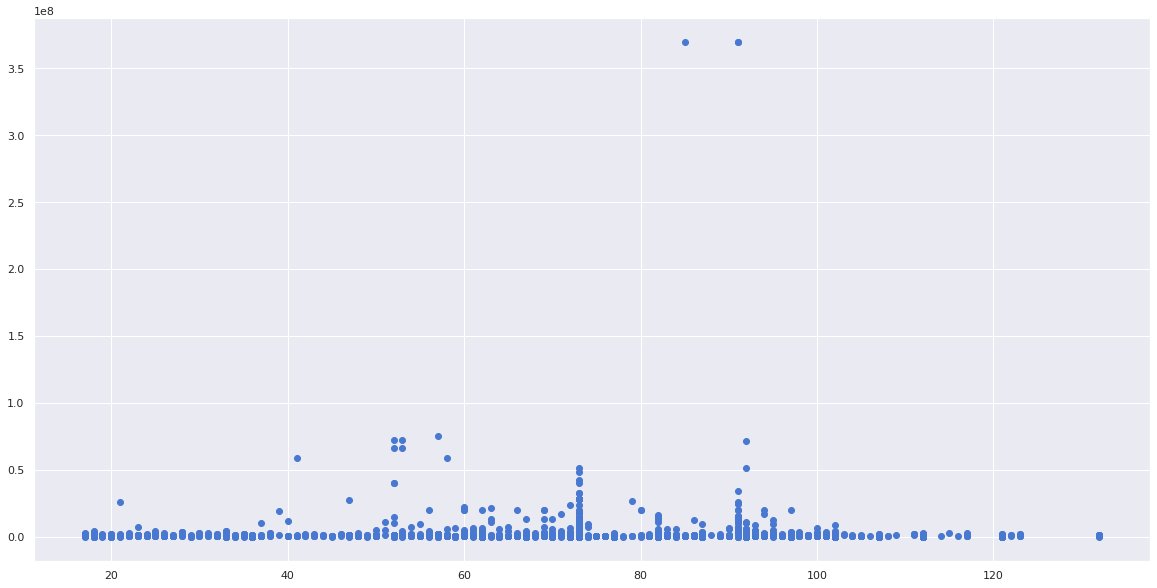

In [1065]:
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
plt.scatter(x = df['AGE'], y = df['SALE PRICE'])

> We couldn't find specific which one is the less one

> so I will use nsmallest method to found the the lower values for `SALE PRICE` and `AGE` column at the same time to answer our question

In [1066]:
df_new = df.nsmallest(20, ["SALE PRICE", 'AGE'])
df_new

NEIGHBORHOOD         BUILDING CLASS CATEGORY  \
17594             SOUTH JAMAICA         02 TWO FAMILY DWELLINGS   
17600             SOUTH JAMAICA         02 TWO FAMILY DWELLINGS   
4036                   ELMHURST       03 THREE FAMILY DWELLINGS   
1051                    BAYSIDE         01 ONE FAMILY DWELLINGS   
2029               BELLE HARBOR         02 TWO FAMILY DWELLINGS   
6214             FLUSHING-NORTH  10 COOPS - ELEVATOR APARTMENTS   
1137                    BAYSIDE         01 ONE FAMILY DWELLINGS   
7029             FLUSHING-SOUTH         01 ONE FAMILY DWELLINGS   
18716                ST. ALBANS         01 ONE FAMILY DWELLINGS   
11626                 LAURELTON         01 ONE FAMILY DWELLINGS   
16518                  ROSEDALE         01 ONE FAMILY DWELLINGS   
1004                    BAYSIDE         01 ONE FAMILY DWELLINGS   
2960              COLLEGE POINT           04 TAX CLASS 1 CONDOS   
12611          LONG ISLAND CITY       31 COMMERCIAL VACANT LAND   
16582                  ROSEDALE         02 TWO FAMILY DWELLINGS   
16623                  ROSEDALE         02 TWO FAMILY DWELLINGS   
17230  SO. JAMAICA-BAISLEY PARK       03 THREE FAMILY DWELLINGS   
17596             SOUTH JAMAICA         02 TWO FAMILY DWELLINGS   
17597             SOUTH JAMAICA         02 TWO FAMILY DWELLINGS   
19093                ST. ALBANS         02 TWO FAMILY DWELLINGS   

      TAX CLASS AT PRESENT    BLOCK   LOT BUILDING CLASS AT PRESENT  \
17594                    1  12143.0   4.0                        B2   
17600                    1  12148.0  41.0                        B2   
4036                     1   1600.0  41.0                        C0   
1051                     1   6019.0  87.0                        A2   
2029                     1  16225.0  63.0                        B2   
6214                     2   5374.0  16.0                        D4   
1137                     1   6161.0  40.0                        A2   
7029                     1   6427.0  17.0                        A5   
18716                    1  10277.0  20.0                        A2   
11626                    1  12970.0  30.0                        A2   
16518                    1  13652.0   4.0                        A5   
1004                     1   5807.0  44.0                        A1   
2960                    1A   3916.0  41.0                        R3   
12611                    4    432.0  21.0                        V1   
16582                    1  13494.0  63.0                        B2   
16623                    1  13609.0  10.0                        B1   
17230                    1  12390.0  41.0                        C0   
17596                    1  12143.0  41.0                        B2   
17597                    1  12144.0  11.0                        B2   
19093                    1  10437.0  40.0                        B3   

                         ADDRESS  ZIP CODE  RESIDENTIAL UNITS  \
17594        109-13 153RD STREET   11433.0                2.0   
17600        157-10 109TH AVENUE   11433.0                2.0   
4036           92-14 43RD AVENUE   11373.0                3.0   
1051          28-23 216TH STREET   11360.0                1.0   
2029        246 BEACH 130 STREET   11694.0                2.0   
6214      144-30 SANFORD AVE, 1G   11355.0                2.0   
1137              35-25 209TH ST   11361.0                1.0   
7029           61-50 148TH PLACE   11367.0                1.0   
18716        110-03 178TH STREET   11433.0                1.0   
11626        133-02 231ST STREET   11413.0                1.0   
16518         25306 148TH AVENUE   11422.0                1.0   
1004          23-81 207TH STREET   11360.0                1.0   
2960   120-23 RIVIERA COURT, 4/B   11356.0                1.0   
12611       27-01 JACKSON AVENUE   11101.0                0.0   
16582        144-19 224TH STREET   11413.0                2.0   
16623        139-39 250TH STREET   11422.0                2.0   
17230   172-27

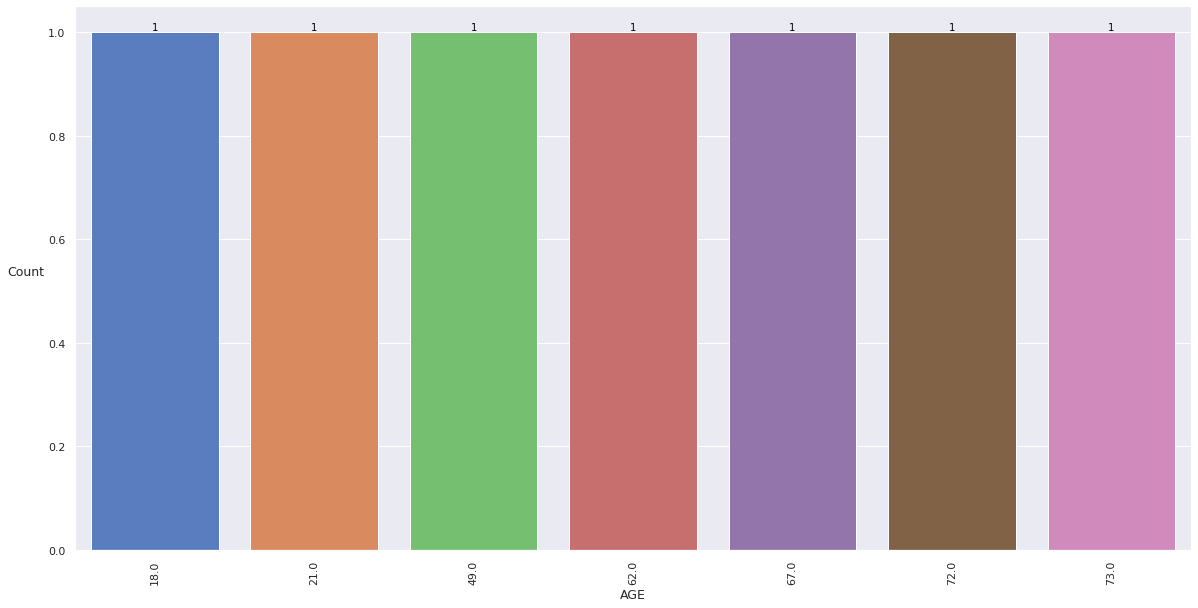

In [1067]:
plt.figure(figsize=(20,10)) #figsize must be applied before plotting the graph
plt.xticks(rotation='vertical') #text rotation for readability
plot_needed_ind = sns.barplot(x=df_new['AGE'], y=df_new['SALE PRICE'])

plt.xlabel('AGE', fontsize=12.5)
plt.ylabel('Count', rotation=0, ha='right', fontsize=12.5)

for patch in plot_needed_ind.patches:
    plot_needed_ind.annotate("%.0f" % patch.get_height(), (patch.get_x() + patch.get_width() / 2., patch.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')

plt.show()

> Also, we can see that the newest building with the lowest selling price is the one that was built `18` years ago with a selling price of `1`

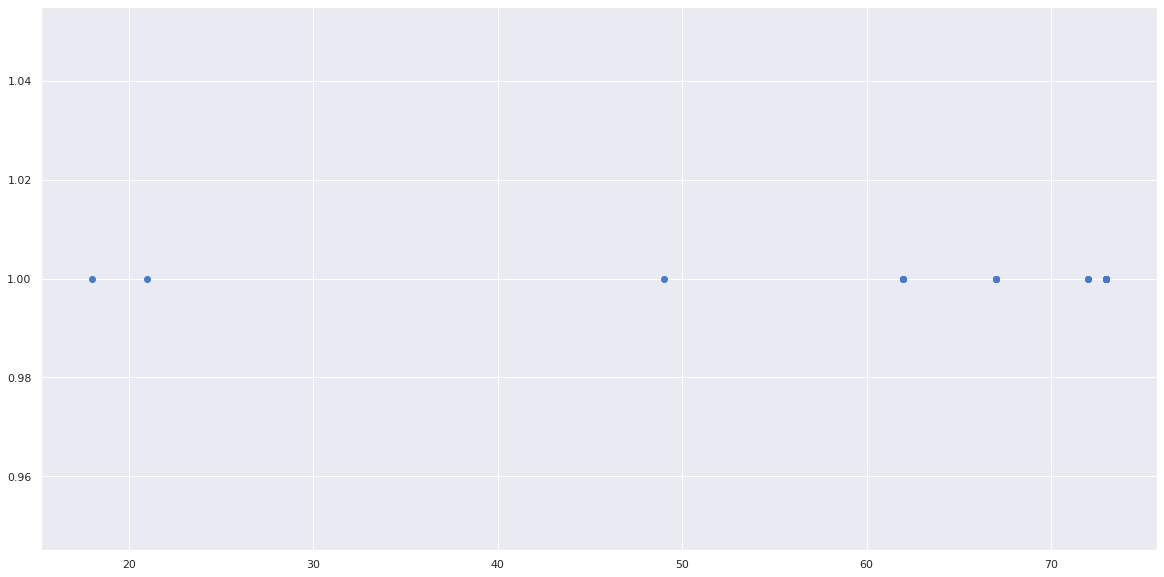

In [1068]:
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
plt.scatter(x = df_new['AGE'], y = df_new['SALE PRICE'])

#Task 3: Feature Engineering. If we would like to predict the house sale price. transfer (cateogorical features). how We select the important features.

In [1069]:
#general summary of dataset
df.describe(include='all').transpose()

count unique                      top  freq  \
NEIGHBORHOOD                      13196     61           FLUSHING-NORTH  1304   
BUILDING CLASS CATEGORY           13196     40  01 ONE FAMILY DWELLINGS  4564   
TAX CLASS AT PRESENT              13196     10                        1  7382   
BLOCK                           13196.0    NaN                      NaN   NaN   
LOT                             13196.0    NaN                      NaN   NaN   
BUILDING CLASS AT PRESENT         13196     97                       A1  2141   
ADDRESS                           13196  12979        21-36 28TH STREET    10   
ZIP CODE                        13196.0    NaN                      NaN   NaN   
RESIDENTIAL UNITS               13196.0    NaN                      NaN   NaN   
COMMERCIAL UNITS                13196.0    NaN                      NaN   NaN   
TOTAL UNITS                     13196.0    NaN                      NaN   NaN   
LAND SQUARE FEET                13196.0    NaN                      NaN   NaN   
GROSS SQUARE FEET               13196.0    NaN                      NaN   NaN   
YEAR BUILT                      13196.0    NaN                      NaN   NaN   
TAX CLASS AT TIME OF SALE       13196.0    NaN                      NaN   NaN   
BUILDING CLASS AT TIME OF SALE    13196     98                       A1  2147   
SALE PRICE                      13196.0    NaN                      NaN   NaN   
SALE DATE                         13196    308      2020-09-09 00:00:00   136   
YEAR SELL                       13196.0    NaN                      NaN   NaN   
MONTH SELL                      13196.0    NaN                      NaN   NaN   
AGE                             13196.0    NaN                      NaN   NaN   

                                    first       last            mean  \
NEIGHBORHOOD                          NaT        NaT             NaN   
BUILDING CLASS CATEGORY               NaT        NaT             NaN   
TAX CLASS AT PRESENT                  NaT        NaT             NaN   
BLOCK                                 NaT        NaT     6855.029403   
LOT                                   NaT        NaT       33.355411   
BUILDING CLASS AT PRESENT             NaT        NaT             NaN   
ADDRESS                               NaT        NaT             NaN   
ZIP CODE                              NaT        NaT    11374.871249   
RESIDENTIAL UNITS                     NaT        NaT        1.439148   
COMMERCIAL UNITS                      NaT        NaT        0.424977   
TOTAL UNITS                           NaT        NaT        1.471734   
LAND SQUARE FEET                      NaT        NaT     3328.875568   
GROSS SQUARE FEET                     NaT        NaT     2103.902849   
YEAR BUILT                            NaT        NaT      1944.03054   
TAX CLASS AT TIME OF SALE             NaT        NaT        1.527508   
BUILDING CLASS AT TIME OF SALE        NaT        NaT             NaN   
SALE PRICE                            NaT        NaT  1071191.064565   
SALE DATE                      2020-01-01 2020-12-31             NaN   
YEAR SELL                             NaT        NaT          2020.0   
MONTH SELL                            NaT        NaT         6.48348   
AGE                                   NaT        NaT        77.96946   

                                           std      min       25%       50%  \
NEIGHBORHOOD                               NaN      NaN       NaN       NaN   
BUILDING CLASS CATEGORY                    NaN      NaN       NaN       NaN   
TAX CLASS AT PRESENT                       NaN      NaN       NaN       NaN   
BLOCK                              4513.257661     15.0   2975.75    6429.0   
LOT                                  20.490738      1.0      16.0      41.0   
BUILDING CLASS AT PRESENT                  NaN      NaN       NaN       NaN   
ADDRESS                                    NaN      NaN       NaN       NaN   
ZIP CODE                          

## convert all `categorical` columns to `numerical`

###NEIGHBORHOOD

In [1070]:
len(df['NEIGHBORHOOD'].unique())

61

> As we can see, We have `61` unique value so I will not using one hot encoding may be use Labelencoder or target encoding

> in this column I will use `Label encoding`

In [1071]:
encoder = LabelEncoder()
df['NEIGHBORHOOD'] = encoder.fit_transform(df['NEIGHBORHOOD'])

In [1072]:
df['NEIGHBORHOOD'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

###BUILDING CLASS CATEGORY

In [1073]:
len(df['BUILDING CLASS CATEGORY'].unique())

40

> As we can see, We have `40` unique value so it's may be to using one hot encoding ,Labelencoder or target encoding

> in this column I will use `Target encoding`

In [1074]:
encoder = TargetEncoder()
df['BUILDING CLASS CATEGORY'] = encoder.fit_transform(df['BUILDING CLASS CATEGORY'], df['SALE PRICE'])

In [1075]:
df['BUILDING CLASS CATEGORY'].unique()

array([1.07119106e+06, 6.80915232e+05, 7.05560320e+05, 8.04024502e+05,
       1.46681696e+06, 5.43624875e+05, 7.36760568e+05, 8.15593848e+05,
       2.87128080e+06, 1.30617085e+07, 2.93046773e+05, 3.78286535e+06,
       1.64690666e+06, 4.35025074e+06, 3.63751888e+05, 3.65811051e+05,
       2.03148668e+06, 4.79897241e+06, 7.85031617e+05, 9.95269369e+05,
       3.44457108e+05, 4.05539062e+06, 4.29079622e+06, 1.29618308e+07,
       4.89014638e+06, 2.21389886e+07, 6.74808525e+05, 3.79724360e+06,
       8.66689568e+05, 2.82681818e+06, 1.43824172e+06, 9.88441766e+05,
       4.21752751e+06, 4.77072733e+06, 2.35699527e+06, 8.20588678e+05,
       2.21765594e+08])

###TAX CLASS AT PRESENT

In [1076]:
len(df['TAX CLASS AT PRESENT'].unique())

10

> As we can see, We have `10` unique value so I will not using one hot encoding may be use Labelencoder or target encoding

> in this column I will use `one hot encoding`

In [1077]:
df = pd.get_dummies(df, columns=['TAX CLASS AT PRESENT'])

In [1078]:
df.head()

NEIGHBORHOOD  BUILDING CLASS CATEGORY    BLOCK   LOT  \
0             0             1.071191e+06  14260.0  80.0   
1             1             6.809152e+05    949.0  41.0   
2             1             7.055603e+05    949.0  41.0   
3             2             6.809152e+05  15830.0  20.0   
4             2             6.809152e+05  15830.0  27.0   

  BUILDING CLASS AT PRESENT                ADDRESS  ZIP CODE  \
0                        V7      N/A ROCKAWAY BLVD   11434.0   
1                        A5      19-62 81ST STREET   11370.0   
2                        R2   19-37 80TH STREET, 1   11370.0   
3                        A5   3-20 BEACH 41 STREET   11691.0   
4                        A5  336 BEACH 41ST STREET   11691.0   

   RESIDENTIAL UNITS  COMMERCIAL UNITS  TOTAL UNITS  ...  \
0                0.0               0.0          0.0  ...   
1                1.0               0.0          1.0  ...   
2                1.0               1.0          1.0  ...   
3                1.0               0.0          1.0  ...   
4                1.0               0.0          1.0  ...   

   TAX CLASS AT PRESENT_1  TAX CLASS AT PRESENT_1A  TAX CLASS AT PRESENT_1B  \
0                       0                        0                        0   
1                       1                        0                        0   
2                       0                        0                        0   
3                       1                        0                        0   
4                       1                        0                        0   

   TAX CLASS AT PRESENT_1C TAX CLASS AT PRESENT_1D  TAX CLASS AT PRESENT_2  \
0                        0                       0                       0   
1                        0                       0                       0   
2                        0                       0                       1   
3                        0                       0                       0   
4                        0                       0                       0   

  TAX CLASS AT PRESENT_2A  TAX CLASS AT PRESENT_2B  TAX CLASS AT PRESENT_2C  \
0                       0                        0                        0   
1                       0                        0                        0   
2                       0                        0                        0   
3                       0                        0                        0   
4                       0                        0                        0   

   TAX CLASS AT PRESENT_4  
0                       1  
1                       0  
2                       0  
3                       0  
4                       0  

[5 rows x 30 columns]

###BUILDING CLASS AT PRESENT

In [1079]:
len(df['BUILDING CLASS AT PRESENT'].unique())

97

> As we can see, We have `97` unique value so I will not using one hot encoding may be use Labelencoder or target encoding

> in this column I will use `Target encoding`

In [1080]:
encoder = TargetEncoder()
df['BUILDING CLASS AT PRESENT'] = encoder.fit_transform(df['BUILDING CLASS AT PRESENT'], df['SALE PRICE'])

In [1081]:
df['BUILDING CLASS AT PRESENT'].unique()

array([1.07119106e+06, 6.55017699e+05, 7.03467908e+05, 6.54164930e+05,
       5.75475624e+05, 3.18420526e+05, 6.71584223e+05, 7.81046031e+05,
       7.19246705e+05, 8.05870131e+05, 9.36104270e+05, 1.46681696e+06,
       5.40346045e+05, 7.30948638e+05, 7.68483069e+05, 2.61721500e+06,
       1.58352370e+07, 2.93046773e+05, 5.00979523e+06, 8.77905444e+05,
       1.11270324e+06, 3.15834054e+06, 1.37213978e+06, 3.99740453e+06,
       1.03768005e+06, 3.14667285e+06, 9.54398516e+06, 3.63751888e+05,
       3.65811051e+05, 2.02510568e+06, 1.92317696e+06, 1.01145249e+07,
       1.38100718e+06, 1.46589008e+06, 7.83750744e+05, 9.95269369e+05,
       3.44457108e+05, 2.33788177e+06, 3.33571537e+06, 5.93594138e+06,
       3.70643700e+06, 2.45606809e+06, 6.25185085e+06, 6.05738465e+06,
       4.33528057e+07, 5.93092766e+06, 5.56084765e+06, 1.21906721e+06,
       6.30029412e+06, 1.58849393e+07, 4.85844685e+05, 7.27420080e+05,
       5.02311623e+05, 3.79724360e+06, 8.66689568e+05, 7.41318519e+05,
      

###ADDRESS

In [1082]:
len(df['ADDRESS'].unique())

12979

> As we can see, We have `12979` unique value so I will not using one hot encoding may be use Labelencoder or target encoding

> but at all i will drop this column becasue there are another columns represent the same information so I will drop this column

In [1083]:
df.drop(['ADDRESS'], axis = 1, inplace = True)

###BUILDING CLASS AT TIME OF SALE

In [1084]:
len(df['BUILDING CLASS AT TIME OF SALE'].unique())

98

> As we can see, We have `98` unique value so I will not using one hot encoding may be use Labelencoder or target encoding

> in this column I will use `Target encoding`

In [1085]:
encoder = TargetEncoder()
df['BUILDING CLASS AT TIME OF SALE'] = encoder.fit_transform(df['BUILDING CLASS AT TIME OF SALE'], df['SALE PRICE'])

In [1086]:
df['BUILDING CLASS AT TIME OF SALE'].unique()

array([1.07119106e+06, 6.54428664e+05, 7.05560320e+05, 6.57431545e+05,
       5.75475624e+05, 3.18420526e+05, 6.73466723e+05, 7.78490083e+05,
       7.12768355e+05, 8.08469000e+05, 9.37696267e+05, 1.46681696e+06,
       5.41028446e+05, 7.37006657e+05, 7.68483069e+05, 2.87128080e+06,
       1.58352370e+07, 2.93046773e+05, 3.79976187e+06, 8.81205270e+05,
       1.11526593e+06, 3.15834054e+06, 1.37213978e+06, 3.99740453e+06,
       1.03768005e+06, 3.14667285e+06, 9.54398516e+06, 3.63751888e+05,
       3.65811051e+05, 2.03148668e+06, 1.92317696e+06, 1.01145249e+07,
       1.38100718e+06, 1.46589008e+06, 7.85031617e+05, 9.95269369e+05,
       3.44457108e+05, 2.33788177e+06, 3.33571537e+06, 5.84092362e+06,
       3.70643700e+06, 2.45606809e+06, 6.25185085e+06, 6.05738465e+06,
       4.33528057e+07, 5.93092766e+06, 5.56084765e+06, 1.21906721e+06,
       6.30029412e+06, 1.58849393e+07, 4.85844685e+05, 7.27420080e+05,
       5.02311623e+05, 3.79724360e+06, 8.66689568e+05, 7.47527103e+05,
      

###SALE DATE

In [1087]:
len(df['SALE DATE'].unique())

308

> As we can see, We have `SALE DATE` unique value so I will not using one hot encoding may be use Labelencoder or target encoding

> but at all i will drop this column becasue this column is not important in our task and I have the same information in another two columns `[YEAR SELL, MONTH, SELL]`

In [1088]:
df.drop(['SALE DATE'], axis = 1, inplace = True)

##Various Scales

> In this part I will make all columns has the same range of values

> I will use `StandardScaler` method to make this task

In [1089]:
#general summary of dataset
df.describe(include='all').transpose()

count          mean           std  \
NEIGHBORHOOD                    13196.0  3.154274e+01  1.715761e+01   
BUILDING CLASS CATEGORY         13196.0  1.058359e+06  3.692465e+06   
BLOCK                           13196.0  6.855029e+03  4.513258e+03   
LOT                             13196.0  3.335541e+01  2.049074e+01   
BUILDING CLASS AT PRESENT       13196.0  1.046973e+06  3.778259e+06   
ZIP CODE                        13196.0  1.137487e+04  1.210915e+02   
RESIDENTIAL UNITS               13196.0  1.439148e+00  6.188976e-01   
COMMERCIAL UNITS                13196.0  4.249773e-01  5.034724e-01   
TOTAL UNITS                     13196.0  1.471734e+00  6.015300e-01   
LAND SQUARE FEET                13196.0  3.328876e+03  8.729534e+02   
GROSS SQUARE FEET               13196.0  2.103903e+03  4.651544e+02   
YEAR BUILT                      13196.0  1.944031e+03  1.865639e+01   
TAX CLASS AT TIME OF SALE       13196.0  1.527508e+00  7.730304e-01   
BUILDING CLASS AT TIME OF SALE  13196.0  1.049335e+06  3.778897e+06   
SALE PRICE                      13196.0  1.071191e+06  6.308970e+06   
YEAR SELL                       13196.0  2.020000e+03  0.000000e+00   
MONTH SELL                      13196.0  6.483480e+00  3.703417e+00   
AGE                             13196.0  7.796946e+01  1.865639e+01   
TAX CLASS AT PRESENT_1          13196.0  5.594119e-01  4.964765e-01   
TAX CLASS AT PRESENT_1A         13196.0  1.341316e-02  1.150402e-01   
TAX CLASS AT PRESENT_1B         13196.0  1.060928e-02  1.024574e-01   
TAX CLASS AT PRESENT_1C         13196.0  7.578054e-05  8.705202e-03   
TAX CLASS AT PRESENT_1D         13196.0  5.456199e-03  7.366709e-02   
TAX CLASS AT PRESENT_2          13196.0  3.319188e-01  4.709198e-01   
TAX CLASS AT PRESENT_2A         13196.0  1.265535e-02  1.117861e-01   
TAX CLASS AT PRESENT_2B         13196.0  1.288269e-03  3.587070e-02   
TAX CLASS AT PRESENT_2C         13196.0  7.350712e-03  8.542384e-02   
TAX CLASS AT PRESENT_4          13196.0  5.782055e-02  2.334126e-01   

                                          min            25%            50%  \
NEIGHBORHOOD                         0.000000      20.000000      31.000000   
BUILDING CLASS CATEGORY         293046.773042  674808.524904  680915.231595   
BLOCK                               15.000000    2975.750000    6429.000000   
LOT                                  1.000000      16.000000      41.000000   
BUILDING CLASS AT PRESENT       293046.773042  575475.623853  671584.223260   
ZIP CODE                         11001.000000   11361.000000   11375.000000   
RESIDENTIAL UNITS                    0.000000       1.000000       1.000000   
COMMERCIAL UNITS                     0.000000       0.000000       0.000000   
TOTAL UNITS                          0.000000       1.000000       1.000000   
LAND SQUARE FEET                   600.000000    2500.000000    3809.000000   
GROSS SQUARE FEET                 1125.000000    1698.000000    2350.000000   
YEAR BUILT                        1890.000000    1930.000000    1949.000000   
TAX CLASS AT TIME OF SALE            1.000000       1.000000       1.000000   
BUILDING CLASS AT TIME OF SALE  293046.773042  575475.623853  673466.722869   
SALE PRICE                           1.000000  369000.000000  615000.000000   
YEAR SELL                         2020.000000    2020.000000    2020.000000   
MONTH SELL                           1.000000       3.000000       7.000000   
AGE                                 17.000000      70.000000      73.000000   
TAX CLASS AT PRESENT_1               0.000000       0.000000       1.000000   
TAX CLASS AT PRESENT_1A              0.000000       0.000000       0.000000   
TAX CLASS AT PRESENT_1B              0.000000       0.000000       0.000000   
TAX CLASS AT PRESENT_1C              0.000000       0.000000       0.000000   
TAX CLASS AT PRESENT_1D              0.000000       0.000000       0.000000   
TAX CLASS AT PRESENT_2               0.000000       0.000000       0.000000   

In [1090]:
#normalize the data values
std_scaler = StandardScaler()
 
df_scaled = std_scaler.fit_transform(df.to_numpy())
df = pd.DataFrame(df_scaled, columns=list(df.columns))
 
print("Scaled Dataset Using StandardScaler")
df.head()

Scaled Dataset Using StandardScaler


NEIGHBORHOOD  BUILDING CLASS CATEGORY     BLOCK       LOT  \
0     -1.838481                 0.003475  1.640777  2.276461   
1     -1.780195                -0.102224 -1.308645  0.373089   
2     -1.780195                -0.095549 -1.308645  0.373089   
3     -1.721910                -0.102224  1.988655 -0.651803   
4     -1.721910                -0.102224  1.988655 -0.310172   

   BUILDING CLASS AT PRESENT  ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS  \
0                   0.006410  0.488317          -2.325430         -0.844124   
1                  -0.103744 -0.040229          -0.709592         -0.844124   
2                  -0.090920 -0.040229          -0.709592          1.142157   
3                  -0.103744  2.610759          -0.709592         -0.844124   
4                  -0.103744  2.610759          -0.709592         -0.844124   

   TOTAL UNITS  LAND SQUARE FEET  ...  TAX CLASS AT PRESENT_1  \
0    -2.446744          0.550021  ...               -1.126807   
1    -0.784253         -1.751449  ...                0.887463   
2    -0.784253          0.550021  ...               -1.126807   
3    -0.784253         -0.985056  ...                0.887463   
4    -0.784253         -1.150020  ...                0.887463   

   TAX CLASS AT PRESENT_1A  TAX CLASS AT PRESENT_1B  TAX CLASS AT PRESENT_1C  \
0                  -0.1166                -0.103552                -0.008706   
1                  -0.1166                -0.103552                -0.008706   
2                  -0.1166                -0.103552                -0.008706   
3                  -0.1166                -0.103552                -0.008706   
4                  -0.1166                -0.103552                -0.008706   

   TAX CLASS AT PRESENT_1D  TAX CLASS AT PRESENT_2  TAX CLASS AT PRESENT_2A  \
0                -0.074068               -0.704857                -0.113215   
1                -0.074068               -0.704857                -0.113215   
2                -0.074068                1.418727                -0.113215   
3                -0.074068               -0.704857                -0.113215   
4                -0.074068               -0.704857                -0.113215   

   TAX CLASS AT PRESENT_2B  TAX CLASS AT PRESENT_2C  TAX CLASS AT PRESENT_4  
0                -0.035916                -0.086053                4.036693  
1                -0.035916                -0.086053               -0.247728  
2                -0.035916                -0.086053               -0.247728  
3                -0.035916                -0.086053               -0.247728  
4                -0.035916                -0.086053               -0.247728  

[5 rows x 28 columns]

In [1091]:
#general summary of dataset
df.describe(include='all').transpose()

count          mean       std       min  \
NEIGHBORHOOD                    13196.0  6.892200e-17  1.000038 -1.838481   
BUILDING CLASS CATEGORY         13196.0  1.938431e-17  1.000038 -0.207271   
BLOCK                           13196.0  3.446100e-17  1.000038 -1.515599   
LOT                             13196.0 -1.550745e-16  1.000038 -1.579086   
BUILDING CLASS AT PRESENT       13196.0 -4.307625e-18  1.000038 -0.199551   
ZIP CODE                        13196.0  5.513760e-16  1.000038 -3.087627   
RESIDENTIAL UNITS               13196.0 -6.892200e-17  1.000038 -2.325430   
COMMERCIAL UNITS                13196.0 -1.206135e-16  1.000038 -0.844124   
TOTAL UNITS                     13196.0 -1.184597e-16  1.000038 -2.446744   
LAND SQUARE FEET                13196.0 -3.446100e-17  1.000038 -3.126145   
GROSS SQUARE FEET               13196.0 -1.550745e-16  1.000038 -2.104549   
YEAR BUILT                      13196.0 -1.154443e-15  1.000038 -2.896198   
TAX CLASS AT TIME OF SALE       13196.0  6.030675e-17  1.000038 -0.682416   
BUILDING CLASS AT TIME OF SALE  13196.0 -2.153812e-17  1.000038 -0.200142   
SALE PRICE                      13196.0  4.307625e-18  1.000038 -0.169795   
YEAR SELL                       13196.0  0.000000e+00  0.000000  0.000000   
MONTH SELL                      13196.0 -3.230719e-17  1.000038 -1.480710   
AGE                             13196.0 -3.790710e-16  1.000038 -3.268144   
TAX CLASS AT PRESENT_1          13196.0  1.378440e-16  1.000038 -1.126807   
TAX CLASS AT PRESENT_1A         13196.0  3.015337e-17  1.000038 -0.116600   
TAX CLASS AT PRESENT_1B         13196.0  8.615250e-18  1.000038 -0.103552   
TAX CLASS AT PRESENT_1C         13196.0  2.153812e-18  1.000038 -0.008706   
TAX CLASS AT PRESENT_1D         13196.0  1.723050e-17  1.000038 -0.074068   
TAX CLASS AT PRESENT_2          13196.0  8.615250e-17  1.000038 -0.704857   
TAX CLASS AT PRESENT_2A         13196.0 -3.446100e-17  1.000038 -0.113215   
TAX CLASS AT PRESENT_2B         13196.0 -5.384531e-19  1.000038 -0.035916   
TAX CLASS AT PRESENT_2C         13196.0  0.000000e+00  1.000038 -0.086053   
TAX CLASS AT PRESENT_4          13196.0  5.169150e-17  1.000038 -0.247728   

                                     25%       50%       75%         max  
NEIGHBORHOOD                   -0.672773 -0.031634  0.900932    1.658642  
BUILDING CLASS CATEGORY        -0.103878 -0.102224 -0.068882   59.774594  
BLOCK                          -0.859562 -0.094399  0.830689    2.103875  
LOT                            -0.847020  0.373089  0.373089    3.057331  
BUILDING CLASS AT PRESENT      -0.124797 -0.099359 -0.070386   58.420286  
ZIP CODE                       -0.114556  0.001063  0.372697    2.660310  
RESIDENTIAL UNITS              -0.709592 -0.709592  0.906245    2.522083  
COMMERCIAL UNITS               -0.844124 -0.844124  1.142157    3.128438  
TOTAL UNITS                    -0.784253 -0.784253  0.878237    2.540728  
LAND SQUARE FEET               -0.949543  0.550021  0.550021    2.788484  
GROSS SQUARE FEET              -0.872653  0.529086  0.675279    2.356505  
YEAR BUILT                     -0.752079  0.266378  0.427187    3.268144  
TAX CLASS AT TIME OF SALE      -0.682416 -0.682416  0.611243    3.198562  
BUILDING CLASS AT TIME OF SALE -0.125401 -0.099469 -0.071676   58.409805  
SALE PRICE                     -0.111305 -0.072311 -0.031098   58.368129  
YEAR SELL                       0.000000  0.000000  0.000000    0.000000  
MONTH SELL                     -0.940648  0.139477  0.949570    1.489632  
AGE                            -0.427187 -0.266378  0.752079    2.896198  
TAX CLASS AT PRESENT_1         -1.126807  0.887463  0.887463    0.887463  
TAX CLASS AT PRESENT_1A        -0.116600 -0.116600 -0.116600    8.576344  
TAX CLASS AT PRESENT_1B        -0.103552 -0.103552 -0.103552    9.656974  
TAX CLASS AT PRESENT_1C        -0.008706 -0.008706 -0.008706  114.869491  
TAX CLASS AT PRESENT_1D        -0.074068 -0.074068 -0.074068   13.501029  


##Feature Selection

In [1092]:
#specify training columns
X = df.copy()
X.drop('SALE PRICE', axis=1, inplace=True)

In [1093]:
Y = df['SALE PRICE']
print(Y.shape)

(13196,)


In [1094]:
#create RandomForest Model
model = RandomForestRegressor(n_estimators=200)
model.fit(X, Y)

RandomForestRegressor(n_estimators=200)

In [1095]:
#Get the important features
Importance_Feat =  model.feature_importances_

In [1096]:
#create a new data frame to know the important features
final_df = pd.DataFrame({'Features': pd.DataFrame(X).columns, 'Importances': Importance_Feat})
final_df.set_index('Importances')

Features
Importances                                 
3.424813e-02                    NEIGHBORHOOD
1.643784e-01         BUILDING CLASS CATEGORY
4.396362e-02                           BLOCK
1.681408e-01                             LOT
1.891974e-01       BUILDING CLASS AT PRESENT
2.426078e-02                        ZIP CODE
1.038864e-03               RESIDENTIAL UNITS
1.561562e-03                COMMERCIAL UNITS
4.543752e-03                     TOTAL UNITS
6.909763e-03                LAND SQUARE FEET
4.379290e-03               GROSS SQUARE FEET
5.089380e-02                      YEAR BUILT
2.197490e-04       TAX CLASS AT TIME OF SALE
1.753907e-01  BUILDING CLASS AT TIME OF SALE
0.000000e+00                       YEAR SELL
7.320269e-02                      MONTH SELL
5.562275e-02                             AGE
2.639222e-05          TAX CLASS AT PRESENT_1
5.072268e-07         TAX CLASS AT PRESENT_1A
7.807362e-05         TAX CLASS AT PRESENT_1B
7.639307e-07         TAX CLASS AT PRESENT_1C
1.064842e-07         TAX CLASS AT PRESENT_1D
1.727944e-03          TAX CLASS AT PRESENT_2
5.406256e-05         TAX CLASS AT PRESENT_2A
1.090895e-05         TAX CLASS AT PRESENT_2B
1.629778e-06         TAX CLASS AT PRESENT_2C
1.476216e-04          TAX CLASS AT PRESENT_4

In [1097]:
#sort the data frame of features
final_df = final_df.sort_values('Importances')
final_df

Features   Importances
14                       YEAR SELL  0.000000e+00
21         TAX CLASS AT PRESENT_1D  1.064842e-07
18         TAX CLASS AT PRESENT_1A  5.072268e-07
20         TAX CLASS AT PRESENT_1C  7.639307e-07
25         TAX CLASS AT PRESENT_2C  1.629778e-06
24         TAX CLASS AT PRESENT_2B  1.090895e-05
17          TAX CLASS AT PRESENT_1  2.639222e-05
23         TAX CLASS AT PRESENT_2A  5.406256e-05
19         TAX CLASS AT PRESENT_1B  7.807362e-05
26          TAX CLASS AT PRESENT_4  1.476216e-04
12       TAX CLASS AT TIME OF SALE  2.197490e-04
6                RESIDENTIAL UNITS  1.038864e-03
7                 COMMERCIAL UNITS  1.561562e-03
22          TAX CLASS AT PRESENT_2  1.727944e-03
10               GROSS SQUARE FEET  4.379290e-03
8                      TOTAL UNITS  4.543752e-03
9                 LAND SQUARE FEET  6.909763e-03
5                         ZIP CODE  2.426078e-02
0                     NEIGHBORHOOD  3.424813e-02
2                            BLOCK  4.396362e-02
11                      YEAR BUILT  5.089380e-02
16                             AGE  5.562275e-02
15                      MONTH SELL  7.320269e-02
1          BUILDING CLASS CATEGORY  1.643784e-01
3                              LOT  1.681408e-01
13  BUILDING CLASS AT TIME OF SALE  1.753907e-01
4        BUILDING CLASS AT PRESENT  1.891974e-01

In [1098]:
final_df.shape

(27, 2)

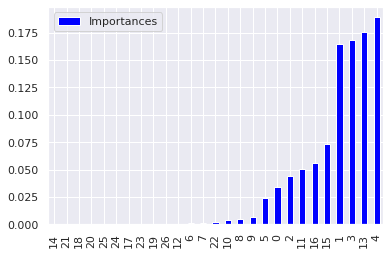

In [1099]:
#plot important features in bar diagram
final_df.plot.bar(color = 'blue')

In [1100]:
final_df['Features'][14:].values

array(['GROSS SQUARE FEET', 'TOTAL UNITS', 'LAND SQUARE FEET', 'ZIP CODE',
       'NEIGHBORHOOD', 'BLOCK', 'YEAR BUILT', 'AGE', 'MONTH SELL',
       'BUILDING CLASS CATEGORY', 'LOT', 'BUILDING CLASS AT TIME OF SALE',
       'BUILDING CLASS AT PRESENT'], dtype=object)

In [1101]:
#take the names of the best features
imp_features = final_df['Features'][14:].values
imp_features

array(['GROSS SQUARE FEET', 'TOTAL UNITS', 'LAND SQUARE FEET', 'ZIP CODE',
       'NEIGHBORHOOD', 'BLOCK', 'YEAR BUILT', 'AGE', 'MONTH SELL',
       'BUILDING CLASS CATEGORY', 'LOT', 'BUILDING CLASS AT TIME OF SALE',
       'BUILDING CLASS AT PRESENT'], dtype=object)

##correlation matrix

Text(0.5, 1.0, 'Variable Correlation')

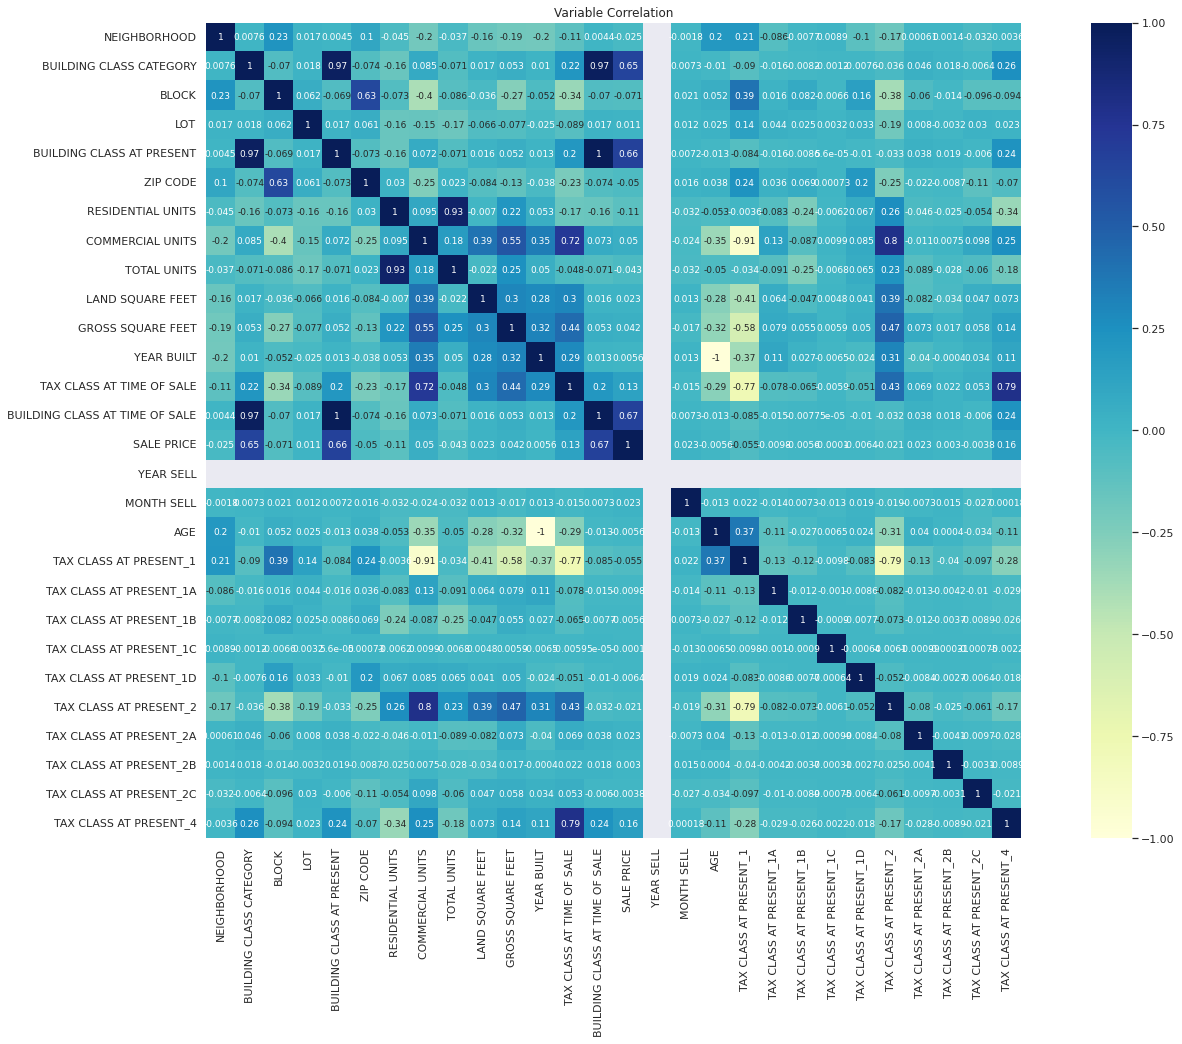

In [1102]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(corrmat, cmap = 'YlGnBu', square=True, annot= True, annot_kws={"size": 9})
plt.title('Variable Correlation')

##Build a MODEL

In [1103]:
#important features
X = df[list(imp_features)]

In [1104]:
X.head()

GROSS SQUARE FEET  TOTAL UNITS  LAND SQUARE FEET  ZIP CODE  NEIGHBORHOOD  \
0           0.529086    -2.446744          0.550021  0.488317     -1.838481   
1          -1.891708    -0.784253         -1.751449 -0.040229     -1.780195   
2           0.675279    -0.784253          0.550021 -0.040229     -1.780195   
3          -1.349932    -0.784253         -0.985056  2.610759     -1.721910   
4          -1.620820    -0.784253         -1.150020  2.610759     -1.721910   

      BLOCK  YEAR BUILT       AGE  MONTH SELL  BUILDING CLASS CATEGORY  \
0  1.640777    0.266378 -0.266378    0.139477                 0.003475   
1 -1.308645    0.051966 -0.051966    0.409508                -0.102224   
2 -1.308645    0.266378 -0.266378   -0.940648                -0.095549   
3  1.988655    3.268144 -3.268144    1.489632                -0.102224   
4  1.988655    3.268144 -3.268144   -0.130555                -0.102224   

        LOT  BUILDING CLASS AT TIME OF SALE  BUILDING CLASS AT PRESENT  
0  2.276461                        0.005784                   0.006410  
1  0.373089                       -0.104507                  -0.103744  
2  0.373089                       -0.090976                  -0.090920  
3 -0.651803                       -0.104507                  -0.103744  
4 -0.310172                       -0.104507                  -0.103744

In [1105]:
#target value
Y.head()

0    0.483427
1   -0.077135
2   -0.103221
3   -0.122242
4   -0.112731
Name: SALE PRICE, dtype: float64

In [1106]:
#splite the data into Train and Test by 70% for training to 30% for testing
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = .3, random_state = 42, shuffle = True)
print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)

(9237, 13)
(3959, 13)
(9237,)
(3959,)


###Random Forest Model

In [1107]:
#create RandomForest Model
model_imp = RandomForestRegressor(n_estimators=100, random_state = 42)
model_imp.fit(X, Y)

RandomForestRegressor(random_state=42)

In [1108]:
#test the accuracy of model on training set
print('RandomForestRegressor Train Score is : ' , model_imp.score(xTrain, yTrain))

RandomForestRegressor Train Score is :  0.9174706470060328


In [1109]:
y_pred = model_imp.predict(xTest)
print('MAE:',metrics.mean_absolute_error(yTest,y_pred))
print('MSE:',metrics.mean_squared_error(yTest,y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(yTest,y_pred)))
print('R^2 =',metrics.explained_variance_score(yTest,y_pred))

MAE: 0.044121281727938146
MSE: 0.22557525614433308
RMSE: 0.47494763516027017
R^2 = 0.7822082245672743


###LR MODEL

In [1110]:
# Create linear regression model
regressor = LinearRegression()
regressor.fit(xTrain,yTrain)

LinearRegression()

In [1111]:
#make data prediction
yPred = regressor.predict(xTest)

In [1112]:
print('MAE:',metrics.mean_absolute_error(yTest,yPred))
print('MSE:',metrics.mean_squared_error(yTest,yPred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(yTest,yPred)))
print('R^2 =',metrics.explained_variance_score(yTest,yPred))

MAE: 0.1526186265433456
MSE: 1.4813550455631188
RMSE: 1.2171092989387267
R^2 = -0.4303089692526463


###Knn MODEL

In [1113]:
# Create KNN regression model
knn=KNeighborsRegressor()
knn.fit(xTrain,yTrain)

KNeighborsRegressor()

In [1114]:
#make data prediction
yPred = knn.predict(xTest)

In [1115]:
print('MAE:',metrics.mean_absolute_error(yTest,yPred))
print('MSE:',metrics.mean_squared_error(yTest,yPred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(yTest,yPred)))
print('R^2 =',metrics.explained_variance_score(yTest,yPred))

MAE: 0.09373900811248001
MSE: 1.0683716245862205
RMSE: 1.0336206386224205
R^2 = -0.03143233063369322


###SVR MODEL

In [1116]:
# Create SVR regression model
svr=SVR()
svr.fit(xTrain,yTrain)

SVR()

In [1117]:
#make data prediction
yPred = svr.predict(xTest)

In [1118]:
print('MAE:',metrics.mean_absolute_error(yTest,yPred))
print('MSE:',metrics.mean_squared_error(yTest,yPred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(yTest,yPred)))
print('R^2 =',metrics.explained_variance_score(yTest,yPred))

MAE: 0.10352412792766308
MSE: 0.9706966257028151
RMSE: 0.9852393748236086
R^2 = 0.06389536315270627


###DecisionTreeRegressor MODEL

In [1119]:
# Create DT regression model
dt=DecisionTreeRegressor()
dt.fit(xTrain,yTrain)

DecisionTreeRegressor()

In [1120]:
#make data prediction
yPred = dt.predict(xTest)

In [1121]:
print('MAE:',metrics.mean_absolute_error(yTest,yPred))
print('MSE:',metrics.mean_squared_error(yTest,yPred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(yTest,yPred)))
print('R^2 =',metrics.explained_variance_score(yTest,yPred))

MAE: 0.10584743298128872
MSE: 1.7700121412852143
RMSE: 1.3304180325315853
R^2 = -0.7089870092124253


###GBM MODEL

In [1122]:
# Create GBM regression model
gbm=GradientBoostingRegressor()
gbm.fit(xTrain,yTrain)

GradientBoostingRegressor()

In [1123]:
#make data prediction
yPred = gbm.predict(xTest)

In [1124]:
print('MAE:',metrics.mean_absolute_error(yTest,yPred))
print('MSE:',metrics.mean_squared_error(yTest,yPred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(yTest,yPred)))
print('R^2 =',metrics.explained_variance_score(yTest,yPred))

MAE: 0.11086922354059094
MSE: 1.6729595945181237
RMSE: 1.2934293929388352
R^2 = -0.6152973044641699


###AdaBoostRegressor MODEL

In [1125]:
# Create AdaBoostRegressor model
ada=AdaBoostRegressor()
ada.fit(xTrain,yTrain)

AdaBoostRegressor()

In [1126]:
#make data prediction
yPred = ada.predict(xTest)

In [1127]:
print('MAE:',metrics.mean_absolute_error(yTest,yPred))
print('MSE:',metrics.mean_squared_error(yTest,yPred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(yTest,yPred)))
print('R^2 =',metrics.explained_variance_score(yTest,yPred))

MAE: 0.2950733655447152
MSE: 1.9252894325166252
RMSE: 1.3875479928696612
R^2 = -0.8178937325470772


###XGB MODEL

In [1128]:
# Create XGB regression model
xgb=XGBRegressor()
xgb.fit(xTrain,yTrain)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [1129]:
#make data prediction
yPred = xgb.predict(xTest)

In [1130]:
print('MAE:',metrics.mean_absolute_error(yTest,yPred))
print('MSE:',metrics.mean_squared_error(yTest,yPred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(yTest,yPred)))
print('R^2 =',metrics.explained_variance_score(yTest,yPred))

MAE: 0.09579550480809353
MSE: 1.632424516721212
RMSE: 1.2776636946869908
R^2 = -0.5761757922791593


#Ref

[R](https://www.pluralsight.com/guides/cleaning-up-data-from-outliers)
/[R](https://contrib.scikit-learn.org/category_encoders/targetencoder.html)
/[R](https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64)
/[R](https://stackoverflow.com/questions/54265717/cannot-import-category-encoders-module)
/[R](https://www.kaggle.com/code/eric8395/nyc-property-sales-eda-analysis-w-regression/notebook)
/[R](https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f)
/[R](https://www.yourdatateacher.com/2021/10/11/feature-selection-with-random-forest/)
/[R](https://xgboost.readthedocs.io/en/stable/parameter.html)
/[R](https://www.datacamp.com/community/tutorials/feature-selection-python)